# Beaver River diabase and anorthosite xenoliths inclusions in the Beaver Bay Complex rock magnetism compilation.

In summer 2019 and January 2020 , we visited the Institute for Rock Magnetism and performed rock magnetic experiments on a number of the specimens of Bever River diabase and anorthosite xenoliths. Here is  brief list of the experiments. 
- Hysteresis loops and backfield curves on Princeton and Lake Shore VSM machines
- MPMS FC-ZFC-RTSIRM cycles on Quantum Design MPMS machines
- Anisotropy of magnetic susceptibility experiments on AGICO AMS machine

## Import necessary Python packages

In [1]:
import numpy as np
import pandas as pd
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from random import randrange
import random
import seaborn as sns
from scipy import special
from scipy.optimize import minimize
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats.mstats import mquantiles
import statsmodels.api as sm
import math
from statistics import mean
from statistics import stdev

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Define functions 

### Make backfield curves

In [2]:
# defining a function, take in an excel sheet, take in the index of the specimen you want, return dictionary of B field and sample moment and specimen name; 
# specimen_index starts from 0
def get_VSM_bf_data(excel_sheet, specimen_index, frac = 0.1, frac_der = 0.1):
    excel_sheet = excel_sheet
    specimen_index = specimen_index
    Blist = excel_sheet.iloc[:,0 + specimen_index * 3].tolist()[5:] # field list, unit is mT
#     print(Blist)
    Blist = [-i for i in Blist]
    logBlist = np.log10(Blist)
    
    Mlist = excel_sheet.iloc[:,1 + specimen_index * 3].tolist()[5:] # moment list, unit is Am2/kg
#     print(Mlist)
    Mlist = [(i-min(Mlist)) for i in Mlist]
    lowess = sm.nonparametric.lowess
    lowessed = lowess(Mlist, Blist, frac=frac)
    
    # use the lowess curved to calculate a median destructive field
    # the definition for the median destructive field is the strength of the alternating magnetic field required to eliminate one-half of the remanent saturation magnetization
    saturation_m = max(lowessed[:,1])
    median_m = 0.5*saturation_m
    MDF = -1 # initialize fake value for MDF
    for i in range(len(lowessed[:,1])-1):
        this_difference = lowessed[:,1][i]-median_m
        next_difference = lowessed[:,1][i+1]-median_m
        if this_difference == 0:
            MDF = lowessed[:,0][i]
            break
        elif this_difference > 0 and next_difference < 0:
            MDF = (lowessed[:,0][i] + lowessed[:,0][i+1])/2
            break
            
    Der = np.diff(lowessed[:,1])/np.diff(np.log10(lowessed[:,0]))
    Der = [-j for j in Der]
    Der = Der[1:]
    Der = [k/max(Der) for k in Der]
    lowessed_der = lowess(Der, logBlist[2:], frac=frac_der)
    specimen_name = excel_sheet.columns[1 + specimen_index * 3]
    return {'Blist':Blist, 'Log_Blist':logBlist, 'Mlist':Mlist, 'Name':specimen_name, 'Lowessed':lowessed, 'Derivative':Der, 'Lowessed_der':lowessed_der, 'MDM': median_m, 'MDF': MDF}

# plotting function directly output the plots as you specify the index of specimen in the list, and plots smoothed data
def plot_VSM_bf_data(excel_sheet, specimen_index, frac = 0.1, log = True, savefig = False, figname = '_VSM_bf.pdf'):
    data = get_VSM_bf_data(excel_sheet, specimen_index, frac = frac)
    
    Blist = data['Blist']
    logBlist = data['Log_Blist']
    Mlist = data['Mlist']
    lowessed = data['Lowessed']
#     Mlist = [i-Mmax for i in Mlist]
    specimen_name = data['Name']
    MDM = data['MDM']
    MDF = data['MDF']

    plt.figure(figsize=(10,5))
    if log == True:
        plt.scatter(logBlist, Mlist, 15,color = 'grey', label = 'original data')
        plt.plot(logBlist, Mlist, color = 'black', label = 'original curve')
        plt.plot(np.log10(lowessed[:,0]), lowessed[:,1], color = 'red', label = 'smoothed curve')
        plt.plot([logBlist[1], np.log10(MDF)], [MDM, MDM], linestyle = 'dashed', color = 'grey', alpha = 0.5, label = 'median destructive field')
        plt.plot([np.log10(MDF), np.log10(MDF)], [min(Mlist), MDM], '--', alpha = 0.5, color = 'grey')
        plt.xticks([0, 1.0, 2.0, np.log10(500)], [1.0, 10.0, 100.0, 500.0])
        plt.xlabel('log B (mT)')
    else:
        plt.scatter(Blist, Mlist, 8, color = 'grey', label = 'original data')
        plt.plot(Blist, Mlist, color = 'black', label = 'original curve')
        plt.plot(lowessed[:,0], lowessed[:,1], color = 'red', label = 'smoothed curve')
        plt.plot([min(Blist), MDF], [MDM, MDM], '--', color = 'grey', alpha = 0.5, label = 'median destructive field')
        plt.plot([MDF, MDF], [min(Mlist), MDM], '--', alpha = 0.5, color = 'grey')
        plt.xlabel('B (mT)')
    
    
#     plt.plot(lowessed[:,0], lowessed[:,1], color = 'red')
    plt.ylim(min(Mlist)-(max(Mlist)-min(Mlist))/50, max(Mlist)+(max(Mlist)-min(Mlist))/50)
    
    plt.ylabel('M (Am$^2$/kg)')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
    plt.title(specimen_name + ' backfield curve')
    plt.legend()
    if savefig == True:
        plt.savefig('../Figure/Rock_mag_plots/'+specimen_name+figname)
    plt.show()
    return MDM, MDF

# plotting function for derivative of bf data
def plot_VSM_bf_der_data(excel_sheet, specimen_index, frac = 0.1, frac_der = 0.1):
    data = get_VSM_bf_data(excel_sheet, specimen_index, frac = frac)
    
    Blist = data['Blist']
    logBlist = data['Log_Blist']
#     Mlist = [i-Mmax for i in Mlist]
    specimen_name = data['Name']
    Der = data['Derivative']
    lowessed_der = data['Lowessed_der']
    
    plt.figure(figsize=(10,5))
    plt.scatter(logBlist[2:], Der, 15,color = 'grey', label = 'original data')
    plt.plot(lowessed_der[:,0], lowessed_der[:,1], color = 'orange', label = 'smoothed curve')
#     plt.xscale('log')
    plt.ylim(float(min(Der)*0.9),float(max(Der)*1.1))
    plt.xlabel('log B (mT)')
    plt.ylabel('dM/dB')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
    plt.title(specimen_name + ' coercivity spectrum')
    plt.legend()
    plt.show()
#     print(Der)
    return lowessed_der



#### make backfield curves from Lake Shore VSM data

These data were acquired using the new Lake Shore VSM at the IRM in Jan 2020. The function below is the same as the one above except that the way it reads in VSM data file is adjusted for the Lake Shore format. 

In [3]:
# making a few functions for reading and plottting Lake Shore backfield data
# mass in unit of gram
def get_Lake_Shore_data(file, specimen_name, frac = 0.1, frac_der = 0.1, mass = 0.):
    if mass == 0.:
        raise ValueError('mass cannott be 0 !')
    data = pd.read_csv(file, sep=',', header = 4, encoding = "ISO-8859-1")
    
    Blist = data.iloc[:,3].tolist()
    Mlist = np.array(data.iloc[:,4].tolist())/mass*1000
    Blist = [-1000*i for i in Blist]
    logBlist = np.log10(Blist)
    
    Mlist = [(i-min(Mlist)) for i in Mlist]
    lowess = sm.nonparametric.lowess
    lowessed = lowess(Mlist, Blist, frac=frac)
    
    # use the lowess curved to calculate a median destructive field
    # the definition for the median destructive field is the strength of the alternating magnetic field required to eliminate one-half of the remanent saturation magnetization
    saturation_m = max(lowessed[:,1])
    median_m = 0.5*saturation_m
    MDF = -1 # initialize fake value for MDF
    for i in range(len(lowessed[:,1])-1):
        this_difference = lowessed[:,1][i]-median_m
        next_difference = lowessed[:,1][i+1]-median_m
        if this_difference == 0:
            MDF = lowessed[:,0][i]
            break
        elif this_difference > 0 and next_difference < 0:
            MDF = (lowessed[:,0][i] + lowessed[:,0][i+1])/2
            break
            
            
    Der = np.diff(lowessed[:,1])/np.diff(np.log10(lowessed[:,0]))
    Der = [-j for j in Der]
    Der = Der[1:]
    Der = [k/max(Der) for k in Der]
    lowessed_der = lowess(Der, logBlist[2:], frac=frac_der)
    return {'Blist':Blist, 'Log_Blist':logBlist, 'Mlist':Mlist, 'Name':specimen_name, 'Lowessed':lowessed, 'Derivative':Der, 'Lowessed_der':lowessed_der, 'MDM': median_m, 'MDF': MDF}

def plot_Lake_Shore_VSM_bf_data(file, specimen_name, frac = 0.1, log = True, mass = 0., savefig = False, figname = '_VSM_bf.pdf'):
    data = get_Lake_Shore_data(file, specimen_name, mass = mass )
    
    Blist = data['Blist']
    logBlist = data['Log_Blist']
    Mlist = data['Mlist']
    lowessed = data['Lowessed']
#     Mlist = [i-Mmax for i in Mlist]
    specimen_name = data['Name']
    MDM = data['MDM']
    MDF = data['MDF']
    
    plt.figure(figsize=(10,5))
    if log == True:
        plt.scatter(logBlist, Mlist, 15,color = 'grey', label = 'original data')
        plt.plot(logBlist, Mlist, color = 'black', label = 'original curve')
        plt.plot(np.log10(lowessed[:,0]), lowessed[:,1], color = 'red', label = 'smoothed curve')
        plt.plot([logBlist[0], np.log10(MDF)], [MDM, MDM], linestyle = 'dashed', color = 'grey', alpha = 0.5, label = 'median destructive field')
        plt.plot([np.log10(MDF), np.log10(MDF)], [min(Mlist), MDM], '--', alpha = 0.5, color = 'grey')
        plt.xticks([0, 1.0, 2.0, 3.0], np.power(10, [0, 1.0, 2.0, 3.0]))
        plt.xlabel('B (mT)')
    else:
        plt.scatter(Blist, Mlist, 8, color = 'grey', label = 'original data')
        plt.plot(Blist, Mlist, color = 'black', label = 'original curve')
        plt.plot(lowessed[:,0], lowessed[:,1], color = 'red', label = 'smoothed curve')
        plt.plot([min(Blist), MDF], [MDM, MDM], '--', color = 'grey', alpha = 0.5, label = 'median destructive field')
        plt.plot([MDF, MDF], [min(Mlist), MDM], '--', alpha = 0.5, color = 'grey')
        plt.xlabel('B (mT)')
   
#     plt.plot(lowessed[:,0], lowessed[:,1], color = 'red')
    plt.ylim(min(Mlist)-(max(Mlist)-min(Mlist))/50, max(Mlist)+(max(Mlist)-min(Mlist))/50)
    
    plt.ylabel('M (Am2/kg)')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
    plt.title(specimen_name + ' backfield curve')
    plt.legend()
    if savefig == True:
        plt.savefig('../Figure/Rock_mag_plots/'+specimen_name+figname)
    plt.show()
    return MDM, MDF

# plotting function for derivative of bf data
def plot_Lake_Shore_VSM_bf_der_data(file, specimen_name, frac = 0.1, frac_der = 0.1, mass = 0.):
    Blist = get_Lake_Shore_data(file, specimen_name, frac = frac, mass = mass)['Blist']
    logBlist = get_Lake_Shore_data(file, specimen_name, mass = mass)['Log_Blist']
#     Mlist = [i-Mmax for i in Mlist]
    specimen_name = get_Lake_Shore_data(file, specimen_name, frac = frac, mass = mass)['Name']
    Der = get_Lake_Shore_data(file, specimen_name, frac = frac, mass = mass)['Derivative']
    lowessed_der = get_Lake_Shore_data(file, specimen_name, frac = frac, frac_der = frac_der, mass = mass)['Lowessed_der']
    
    plt.figure(figsize=(10,5))
    plt.scatter(logBlist[2:], Der, 15,color = 'grey', label = 'original data')
    plt.plot(lowessed_der[:,0], lowessed_der[:,1], color = 'orange', label = 'smoothed curve')
#     plt.xscale('log')
    plt.ylim(float(min(Der)*0.9),float(max(Der)*1.1))
    plt.xlabel('log B (mT)')
    plt.ylabel('dM/dB')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
    plt.title(specimen_name + ' coercivity spectrum')
    plt.legend()
    plt.show()
#     print(Der)
    return lowessed_der




### Skew-normal distribution function, optimization, and error analysis

1. According to Maxbauer (2016), the MaxUnmix program uses a skew-normal distribution with a user-determined component input to approximate the coercivity spectrum for a given set of B field. In python scipy package there is also a function scipy.stats.skewnorm or scipy.stats.norm that uses the same implementation as that in R. Here we explore the application in python. 

- B is a given field value 
- Bhi or Bh is the mean coercivity of an individual grain population
- DP is the dispersion parameter, given by standard deviation in log space
- Si is the skewness factor

- Pi is a proportion factor that describes the height of the distribution for each component (pi can range from 0 to 1, nor- malized such that a value of 1 is equivalent to the maximum of C), 
- w() is the skew-normal probability density function, Si is a para- meter describing skewness (for Si less than 1 distributions skew left, and vice versa)
- Cm represents the modeled approximation of C.

in function scipy.stats.skewnorm,
skewnorm.pdf(x, a, loc, scale)

- x is given input == B
- a is skewness == Si
- loc is used to shift the distrubution == Bhi
- scale is used to scale the amplitutde of the distribution == DP

***Very important notice: in the skewness function here Si = 0 is equivalent to no skewness while Si > 0 means having a skewness to the right and Si < 0 means having a skewness to left.***

2. It turns out the optimization function used is Maxbauer 2016 is just a default setting in a built in function optim() in R. Here we also have the equivalent in scipy package, which is scipy.optimize.minimize(). The default setting in R uses 'Nelder and Mead 1965' and this is waht we are going to use here. 

3. The error analysis of this kind of multivariate functions are tricky. And the description given in Maxbauer 2016 wasn't immediately clear. It turns out that the uncertainties of the parameters (Pi, Bhi, Dp, Si) and the uncertainty envelopes of the fitting curves were calculated independently. 

- The resampling of the parameters were calculated using the rnorm() function in R which generates multivariate normal random variates in a given space x. The equivalent function in python is scipy.stats.multivariate_normal(). 
- The uncertainty envelope for the fitted curve, however, is calculated by resampling the raw data points (randomly picking a given proportion of initial data sets) and redo the fitting process. 
- question: are the parameters generated from the second process normally distributed?
- caveat: resampling the raw data, or the log-treated, axis-flipped data?

Maxbauer, D. P., Feinberg, J. M., & Fox, D. L. (2016). MAX UnMix: A web application for unmixing magnetic coercivity distributions. Computers & Geosciences, 95, 140-145. Doi: 10.1016/j.cageo.2016.07.009. 

### Function for Cm and uncertainty bounds calculation



In [4]:
def Cm(Blist, Si=0, Bhi=1.5, DP=1, proportion=1):
    '''
    Blist is a list of field values
    Si is skewness, default is 0 for no skewness
    Bhi is the location of the mean of the skew normal distribution
    DP is the proportion factor that describes the height of the distribution
    '''
    Cm = skewnorm.pdf(Blist, Si, loc = Bhi, scale = DP)*proportion
    return Cm

def stats_list_in_list(Blist, list_in_list): # all lists in list should be of same dimension
    
    convert_array = np.array(list_in_list)
    
    mean = np.percentile(convert_array,50, axis=0)
    upper = np.percentile(convert_array,97.5, axis=0)
    lower = np.percentile(convert_array,2.5, axis=0)
#     print(mean, upper, lower)
    return {'mean':mean, 'upper':upper, 'lower':lower}

### fit function

In [5]:
def fit_function(logBlist, dMdBlist, in_list):
    '''
    this function fits the data of logB and dMdB to a skew normal distribution 
    it uses the user input in_list as initial guess for the parameters
    
    Format of in_list should follow: [Si, Bhi, DP] which is used by the Cm function
    one can initiate three components for fitting at most
    
    '''
    
    num_components = len(in_list)//4
    
    if num_components == 1:
        bounds = ((-1,1), (0,4), (0,100), (0,1))
    if num_components == 2:
        bounds = ((-1,1), (0,4), (0,100), (0,1),
                  (-1,1), (0,4), (0,100), (0,1))
    if num_components == 3:
        bounds = ((-1,1), (0,4), (0,100), (0,1),
                  (-1,1), (0,4), (0,100), (0,1), 
                  (-1,1), (0,4), (0,100), (0,1))
        
    def minimize_in_list(in_list):
        if num_components == 1:
            cm = cm1 = Cm(logBlist, in_list[0], in_list[1], in_list[2], in_list[3])
        elif num_components == 2:
            cm1 = Cm(logBlist, in_list[0], in_list[1], in_list[2], in_list[3])
            cm2 = Cm(logBlist, in_list[4], in_list[5], in_list[6], in_list[7])
            cm = np.add(cm1, cm2)
        elif num_components == 3:
            cm1 = Cm(logBlist, in_list[0], in_list[1], in_list[2], in_list[3])
            cm2 = Cm(logBlist, in_list[4], in_list[5], in_list[6], in_list[7])
            cm3 = Cm(logBlist, in_list[8], in_list[9], in_list[10], in_list[11])
            cm = np.sum([cm1, cm2, cm3], axis=0) 
        else:
            raise NameError('only 1-3 components are allowed')

        loss = np.abs(np.subtract(dMdBlist,cm))
        
        return np.sum(loss**2)
    
    output = minimize(minimize_in_list, in_list, method = 'Nelder-Mead')
    result = output.x
#     print(output.success)
    if num_components == 1:
        cm = cm1 = Cm(logBlist, result[0], result[1], result[2], result[3])
        return {'minimize_result':output, 'result_parameters':result, 'components':[cm1], 'all_components':cm}
    
    elif num_components == 2:
        cm1 = Cm(logBlist, result[0], result[1], result[2], result[3])
        cm2 = Cm(logBlist, result[4], result[5], result[6], result[7])
        cm = np.add(cm1, cm2)
        return {'minimize_result':output, 'result_parameters':result, 'components':[cm1, cm2], 'all_components':cm}
    
    elif num_components == 3:
        cm1 = Cm(logBlist, result[0], result[1], result[2], result[3])
        cm2 = Cm(logBlist, result[4], result[5], result[6], result[7])
        cm3 = Cm(logBlist, result[8], result[9], result[10], result[11])
        cm = np.sum([cm1, cm2, cm3], axis=0) 
        return {'minimize_result':output, 'result_parameters':result, 'components':[cm1,cm2,cm3], 'all_components':cm}
    
    return 

### error estimate

In [6]:
# error envolope estimate
def error_estimate(logBlist, dMdBlist, in_list, proportion = 0.95, n = 100, frac = 0.15, frac_der = 0.15):
    num_components = len(in_list)//4
    num_resample = int(proportion*len(logBlist))
    
    fit_result = fit_function(logBlist, dMdBlist, in_list)
    result_in_list = fit_result['result_parameters']
    original_cm = fit_result['all_components']
    result_components = fit_result['components']
    
    resample_result_parameters = list()
    
    data_array = np.array([logBlist, dMdBlist]).T
    
    for i in range(n):
        data_resample = data_array[np.random.choice(data_array.shape[0], num_resample), :].T
#         print(data_resample.shape)
        resample_result_parameters.append(list(fit_function(data_resample[0], data_resample[1], result_in_list)['result_parameters']))
    resample_result_parameters = np.array(resample_result_parameters).T
    
    print('resampling finished')
    
    if num_components == 1:
        # parameters
        
        Si_list_1 = resample_result_parameters[0]
        Bhi_list_1 = resample_result_parameters[1]
        DP_list_1 = resample_result_parameters[2]
        Proportion_list_1 = resample_result_parameters[3]
        
        Si_std_1 = stdev(Si_list_1)
        Bhi_std_1 = stdev(Bhi_list_1)
        DP_std_1 = stdev(DP_list_1)
        Proportion_std_1 = stdev(Proportion_list_1)
        
        print('parameter uncertainty calculation finished')
        
        # individual components
        holder_cm_1 = list()
        
        for m in range(len(Si_list_1)):
            holder_cm_1.append(Cm(logBlist, Si_list_1[m], Bhi_list_1[m], DP_list_1[m], Proportion_list_1[m]))
            
        stats_1 = stats_list_in_list(logBlist, holder_cm_1)
        
        print('fitting uncertainty envelope estimate finished')
        
        return {'stds':[Si_std_1, Bhi_std_1, DP_std_1, Proportion_std_1], 
                'means':[stats_1['mean']],
                'upper_bounds':[stats_1['upper']], 
                'lower_bounds':[stats_1['lower']], 
                'original_cm':original_cm}
    
    elif num_components == 2:
        
        # parameters

        Si_list_1 = resample_result_parameters[0]
        Bhi_list_1 = resample_result_parameters[1]
        DP_list_1 = resample_result_parameters[2]
        Proportion_list_1 = resample_result_parameters[3]
        
        Si_list_2 = resample_result_parameters[4]
        Bhi_list_2 = resample_result_parameters[5]
        DP_list_2 = resample_result_parameters[6]
        Proportion_list_2 = resample_result_parameters[7]
        
        Si_std_1 = stdev(Si_list_1)
        Bhi_std_1 = stdev(Bhi_list_1)
        DP_std_1 = stdev(DP_list_1)
        Proportion_std_1 = stdev(Proportion_list_1)
        
        Si_std_2 = stdev(Si_list_2)
        Bhi_std_2 = stdev(Bhi_list_2)
        DP_std_2 = stdev(DP_list_2)
        Proportion_std_2 = stdev(Proportion_list_2)
        
        print('parameter calculation finished')
        
        # individual components
        holder_cm_1 = list()
        holder_cm_2 = list()
        holder_cm_sum = list()
        
        for m in range(len(Si_list_1)):
            cm1 = Cm(logBlist, Si_list_1[m], Bhi_list_1[m], DP_list_1[m], Proportion_list_1[m])
            cm2 = Cm(logBlist, Si_list_2[m], Bhi_list_2[m], DP_list_2[m], Proportion_list_2[m])
            
            holder_cm_1.append(cm1)
            holder_cm_2.append(cm2)
            holder_cm_sum.append(np.add(cm1, cm2))
            
        stats_1 = stats_list_in_list(logBlist, holder_cm_1)
        stats_2 = stats_list_in_list(logBlist, holder_cm_2)
        stats_sum = stats_list_in_list(logBlist, holder_cm_sum)
        print('fitting uncertainty envelope estimate finished')
        
        return {'stds':[Si_std_1, Bhi_std_1, DP_std_1, Proportion_std_1,
                                    Si_std_2, Bhi_std_2, DP_std_2, Proportion_std_2], 
                'means':[stats_sum['mean'], stats_1['mean'], stats_2['mean']],
                'upper_bounds':[stats_sum['upper'], stats_1['upper'], stats_2['upper']], 
                'lower_bounds':[stats_sum['lower'], stats_1['lower'], stats_2['lower']], 
                'original_cm':original_cm}
        
    elif num_components == 3:
        # parameters

        Si_list_1 = resample_result_parameters[0]
        Bhi_list_1 = resample_result_parameters[1]
        DP_list_1 = resample_result_parameters[2]
        Proportion_list_1 = resample_result_parameters[3]
        
        Si_list_2 = resample_result_parameters[4]
        Bhi_list_2 = resample_result_parameters[5]
        DP_list_2 = resample_result_parameters[6]
        Proportion_list_2 = resample_result_parameters[7]
        
        Si_list_3 = resample_result_parameters[8]
        Bhi_list_3 = resample_result_parameters[9]
        DP_list_3 = resample_result_parameters[10]
        Proportion_list_3 = resample_result_parameters[11]
        
        Si_std_1 = stdev(Si_list_1)
        Bhi_std_1 = stdev(Bhi_list_1)
        DP_std_1 = stdev(DP_list_1)
        Proportion_std_1 = stdev(Proportion_list_1)
        
        Si_std_2 = stdev(Si_list_2)
        Bhi_std_2 = stdev(Bhi_list_2)
        DP_std_2 = stdev(DP_list_2)
        Proportion_std_2 = stdev(Proportion_list_2)
        
        Si_std_3 = stdev(Si_list_3)
        Bhi_std_3 = stdev(Bhi_list_3)
        DP_std_3 = stdev(DP_list_3)
        Proportion_std_3 = stdev(Proportion_list_3)
        
        print('parameter calculation finished')
        
        # individual components
        holder_cm_1 = list()
        holder_cm_2 = list()
        holder_cm_3 = list()
        holder_cm_sum = list()
        
        for m in range(len(Si_list_1)):
            cm1 = Cm(logBlist, Si_list_1[m], Bhi_list_1[m], DP_list_1[m], Proportion_list_1[m])
            cm2 = Cm(logBlist, Si_list_1[m], Bhi_list_2[m], DP_list_2[m], Proportion_list_2[m])
            cm3 = Cm(logBlist, Si_list_1[m], Bhi_list_3[m], DP_list_3[m], Proportion_list_3[m])
            
            holder_cm_1.append(cm1)
            holder_cm_2.append(cm2)
            holder_cm_3.append(cm3)
            holder_cm_sum.append(np.sum([cm1, cm2, cm3], axis=0) )
            
        stats_1 = stats_list_in_list(logBlist, holder_cm_1)
        stats_2 = stats_list_in_list(logBlist, holder_cm_2)
        stats_3 = stats_list_in_list(logBlist, holder_cm_3)
        stats_sum = stats_list_in_list(logBlist, holder_cm_sum)
        print('fitting uncertainty envelope estimate finished')
        
        return {'stds':[Si_std_1, Bhi_std_1, DP_std_1, Proportion_std_1,
                                    Si_std_2, Bhi_std_2, DP_std_2, Proportion_std_2,
                                    Si_std_3, Bhi_std_3, DP_std_3, Proportion_std_3,], 
                'upper_bounds':[stats_sum['upper'],stats_1['upper'], stats_2['upper'], stats_3['upper']], 
                'lower_bounds':[stats_sum['lower'],stats_1['lower'], stats_2['lower'], stats_3['lower']], 
                'means':[stats_sum['mean'],stats_1['mean'], stats_2['mean'], stats_3['mean']], 
                'original_cm':original_cm}

### plot unmix data

In [7]:
# unmix function
def plot_unmix_data(logBlist, dMdBlist, specimen_name, in_list):
    fit_result = fit_function(logBlist, dMdBlist, in_list)
    minimize_result = fit_result['minimize_result']
    result_parameters = fit_result['result_parameters']
    components = fit_result['components']
    all_components = fit_result['all_components']
    
    plt.figure(figsize=(10,5))

    # plot raw data
    plt.scatter(logBlist, dMdBlist, 15, color = 'grey', label = 'original data')
    
    # plot optimized result
    if len(components) != 1:
        for i in range(len(components)):
            plt.plot(logBlist, components[i], color = 'C' + str(i+2), label = 'component ' + str(i+1))
    plt.plot(logBlist, all_components, color = 'orange', label = 'total fit')
    plt.xlabel('log B (mT)')
    plt.ylabel('dM/dB')
    plt.title(specimen_name + ' coercivity spectrum')
    plt.legend()
    plt.show()
    
    return logBlist[np.argmax(all_components)], result_parameters[2]

### plot unmix data with uncertainties

In [8]:
def plot_error_estimate(logBlist, dMdBlist, specimen_name, in_list, proportion = 0.95, n = 100, 
                        init_color_code_components = ['darkorange', 'darkblue', 'purple', 'darkgreen'], init_color_code_error = ['orange', 'blue', 'orchid', 'green'], 
                        savefig = False):
    default_color_code_components = ['darkorange', 'darkblue', 'purple', 'darkgreen']
    default_color_code_error = ['orange', 'blue', 'orchid', 'green']
    
    color_code_components = []
    color_code_error = []
    num_init_color = len(init_color_code_components)
    # this allows customization of color curves
    if num_init_color < 4:
        color_code_components.extend(init_color_code_components)
        color_code_components.extend(default_color_code_components[num_init_color:])
        
        color_code_error.extend(init_color_code_error)
        color_code_error.extend(default_color_code_error[num_init_color:])
        
    else: 
        color_code_components = init_color_code_components
        color_code_error = init_color_code_error
        
    num_components = len(in_list)//4
    error_estimate_result = error_estimate(logBlist, dMdBlist, in_list, proportion, n)
    std_Si_Bhi_DP = error_estimate_result['stds']
    upper_bounds = error_estimate_result['upper_bounds']
    lower_bounds = error_estimate_result['lower_bounds']
    means = error_estimate_result['means']
    original_cm = error_estimate_result['original_cm']
    
#     print('means', means, 'u
# pper', upper_bounds, 'lower', lower_bounds)
    
    plt.figure(figsize = (10,5))
    # plot raw data
    plt.scatter(logBlist, dMdBlist, 15, color = 'grey', label = 'original data')
#     plt.plot(logBlist, original_cm, color = 'darkorange',label = 'original fit')
    # plot mean curves for all components and their sum
    for i in range(len(upper_bounds)):  
        if i == 0:
            label = 'total fit'
        else:
            label = 'component ' + str(i)
        plt.plot(logBlist, means[i], color=color_code_components[i], label = label)
        plt.fill_between(logBlist, upper_bounds[i], lower_bounds[i], color=color_code_error[i], alpha='0.5')
    plt.xticks([0, 1.0, 2.0, 3.0], np.power(10, [0, 1.0, 2.0, 3.0]))
    plt.xlabel('B (mT)')
    plt.ylabel('dM/dB')
    plt.title(specimen_name + ' coercivity spectrum')
    plt.legend()
    if savefig == True:
        plt.savefig('code_output//Rock_mag_plots/' + specimen_name + '_umix.pdf')
    plt.show()
    
    return error_estimate_result, logBlist, dMdBlist

## Load data files

In [9]:
# Loading IRM data file
rockmag_data = pd.ExcelFile('../Data/Rock_mag/2019_IRM_hyst_backfield.xls')
specimen_info = pd.read_excel(rockmag_data, 'Specimen Info')
VSM_bf_measurements = pd.read_excel(rockmag_data, 'VSM backfield measurements')

In [10]:
# Loading 2020 january IRM data file
rockmag_data_2020 = pd.ExcelFile('../Data/Rock_mag/2020_jan_IRM_export.xls')
specimen_info_2020 = pd.read_excel(rockmag_data_2020, 'Specimen Info')
VSM_bf_measurements_2020 = pd.read_excel(rockmag_data_2020, 'VSM backfield measurements')

## AX Backfield curves and unmixing

In [11]:
# lists for plotting all specimen coercivity spectra
All_AX_dMdB = list()
All_BD_dMdB = list()

### AX1-1r

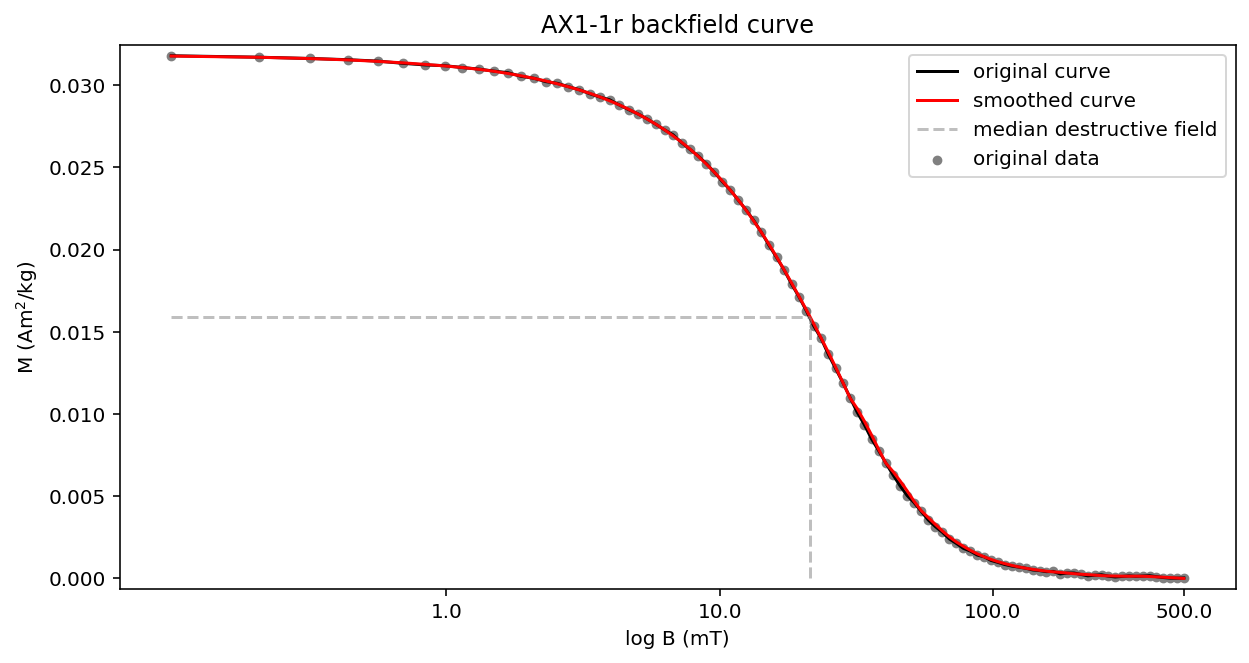

In [12]:
AX1_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 0, 0.1, log = True)

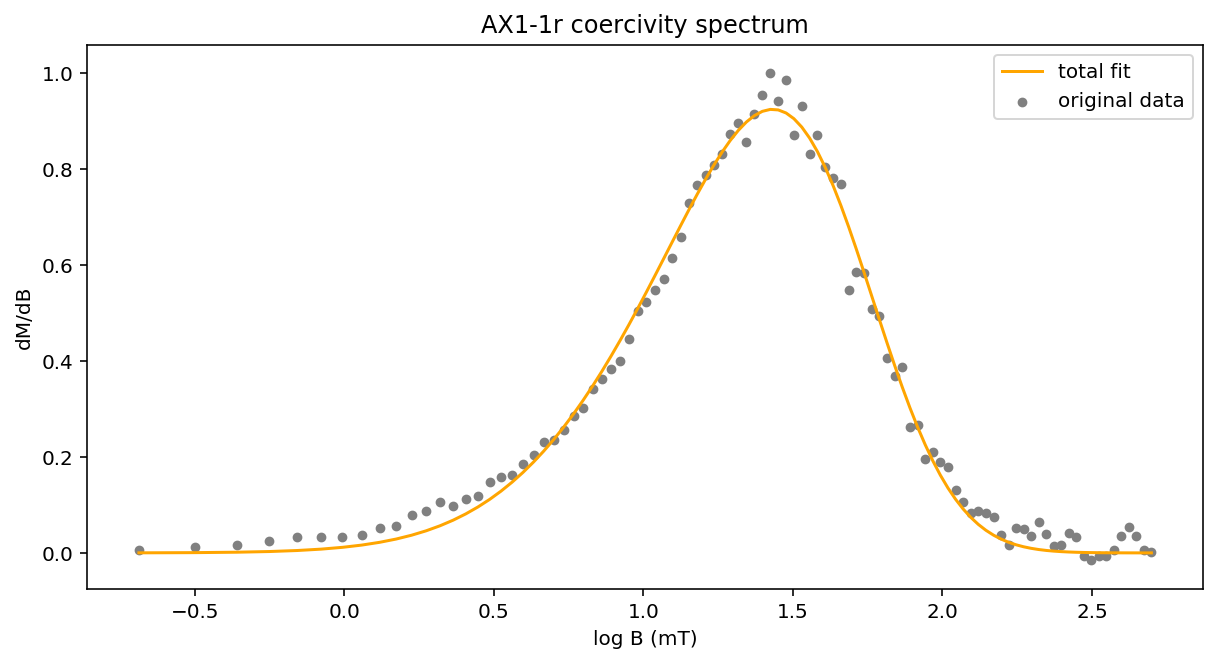

In [13]:
AX1_1_Blist = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.2)['Blist']
AX1_1_Mlist = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.2)['Mlist']
AX1_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.2)['Log_Blist'][2:]
AX1_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.2)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.2)['Name']

AX1_1_in_list = [-.9, 1.5, 1, 1]
AX1_1_fit_result = plot_unmix_data(AX1_1_logBlist, AX1_1_dMdBlist, specimen_name, AX1_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


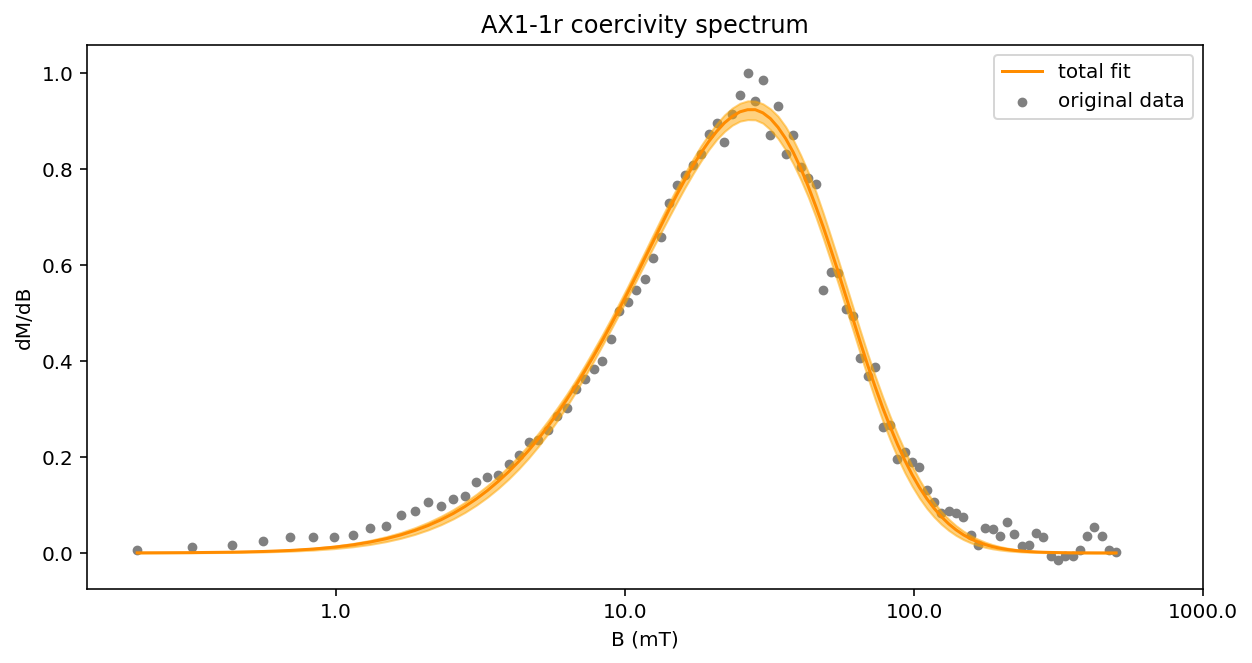

In [14]:
AX1_1_fit_error = plot_error_estimate(AX1_1_logBlist, AX1_1_dMdBlist, specimen_name, AX1_1_in_list, savefig = False)

### AX3-2r
This is a weak sample, VSM data is noisy. We will not use the Princeton VSM data for this sample

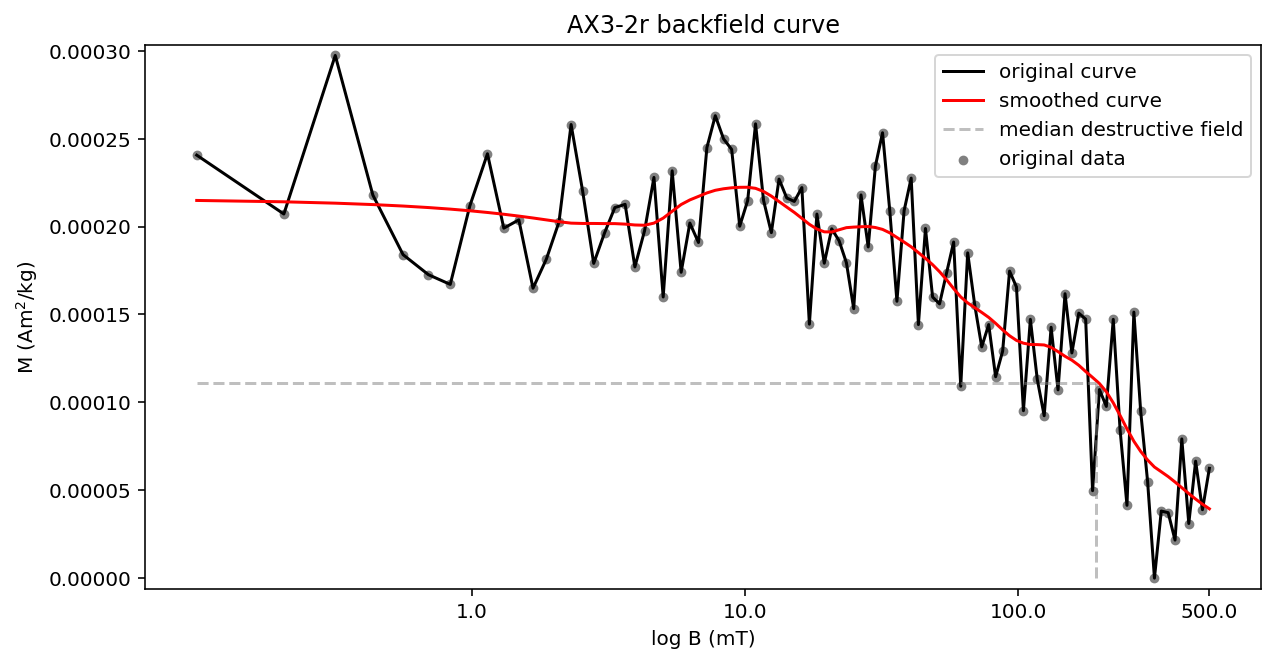

In [15]:
AX3_2_MDF = plot_VSM_bf_data(VSM_bf_measurements, 14, 0.25)

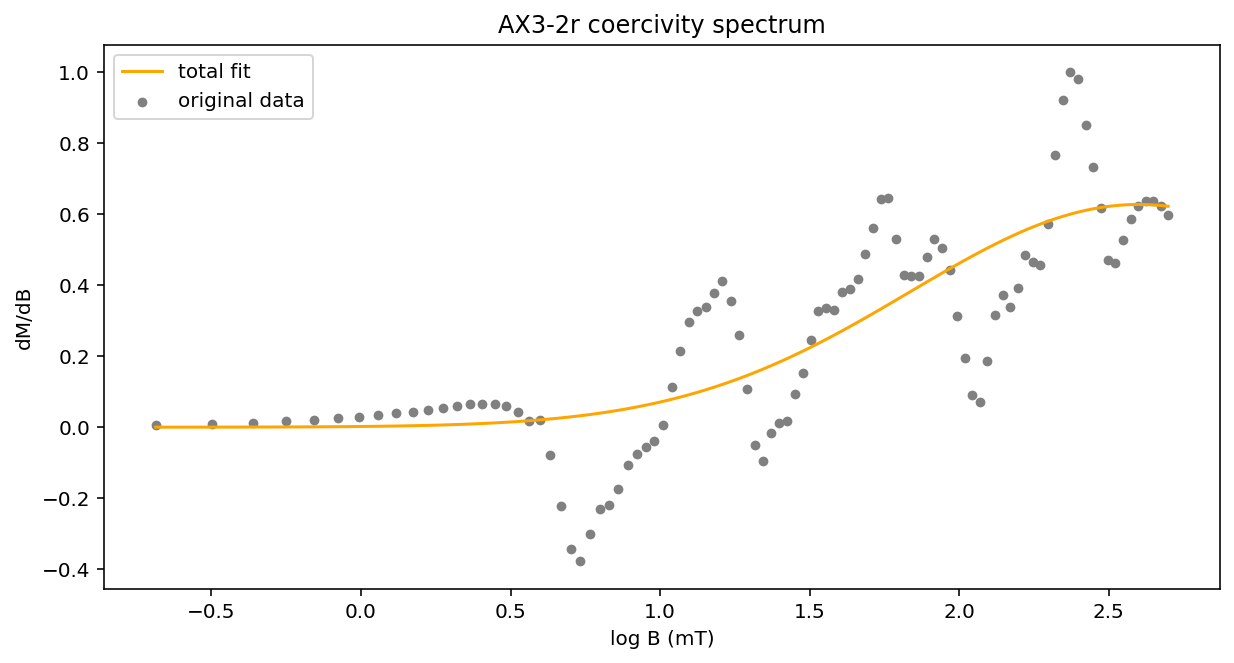

In [16]:
AX3_2_logBlist = get_VSM_bf_data(VSM_bf_measurements, 14, 0.3, 0.1)['Log_Blist'][2:]
AX3_2_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 14, 0.3, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 14, 0.3, 0.1)['Name']

AX3_2_in_list = [1, 2., .2, 1.]
AX3_2_fit_result = plot_unmix_data(AX3_2_logBlist, AX3_2_dMdBlist, specimen_name, AX3_2_in_list)

### AX3-2r Lake Shore

Instead, the new Lake Shore VSM reveals that this specimen has two distinct coercivity peaks. It is likely that this Carlton Peak anorthosite has a population of Fe-Ti oxide and a population of hematite/goethite that might be secondary.

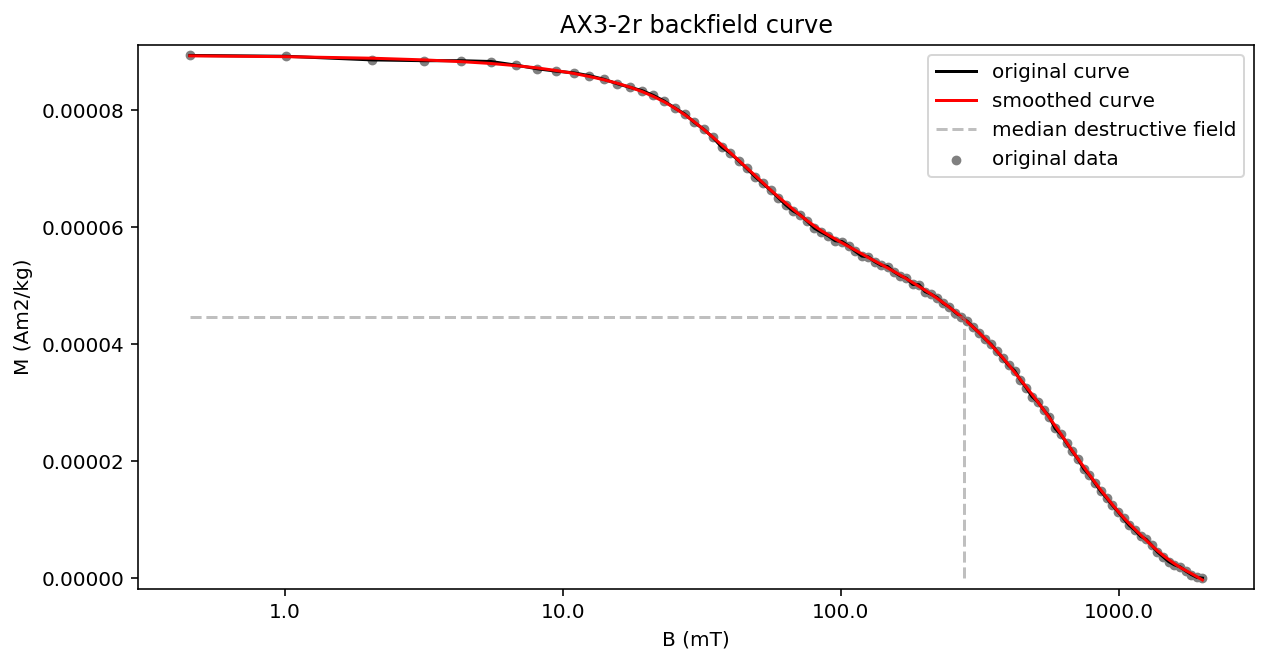

In [17]:
file_path = '../Data/Rock_mag/2020_IRM_data_files/Raw_data/Lake_Shore_VSM/AX3-2r_backfield_2T.csv'
AX3_2_MDF = plot_Lake_Shore_VSM_bf_data(file_path, 'AX3-2r', frac = 0.1, log = True, mass = 0.1451, savefig = False)

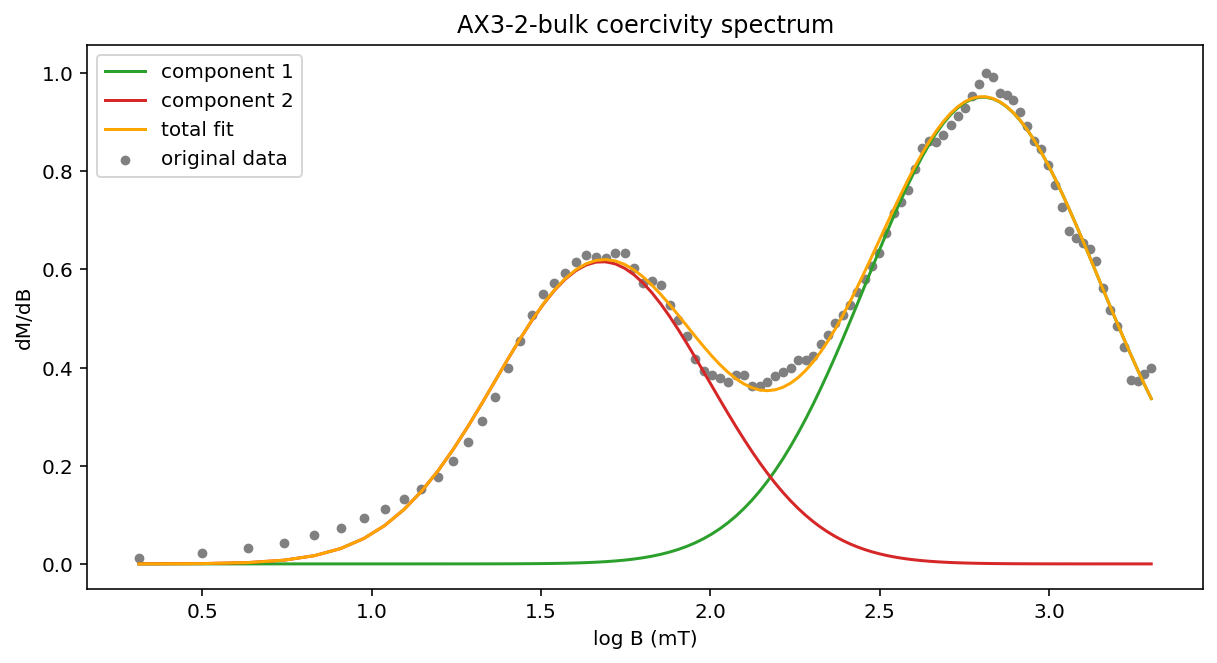

In [18]:
AX3_2_bulk_logBlist = get_Lake_Shore_data(file_path, 'AX3-2-bulk', 0.1, 0.1, mass = 0.1451)['Log_Blist'][2:]
AX3_2_bulk_dMdBlist = get_Lake_Shore_data(file_path, 'AX3-2-bulk', 0.1, 0.1, mass = 0.1451)['Derivative']
specimen_name = get_Lake_Shore_data(file_path, 'AX3-2-bulk', 0.2, 0.15, mass = 0.1451)['Name']
AX3_2_bulk_in_list = [0.2, 3., 2, 0.8,
                       0.2, 1.5, 2, 0.2]
AX3_2_lakeshore_result = plot_unmix_data(AX3_2_bulk_logBlist, AX3_2_bulk_dMdBlist, specimen_name, AX3_2_bulk_in_list)

resampling finished
parameter calculation finished
fitting uncertainty envelope estimate finished


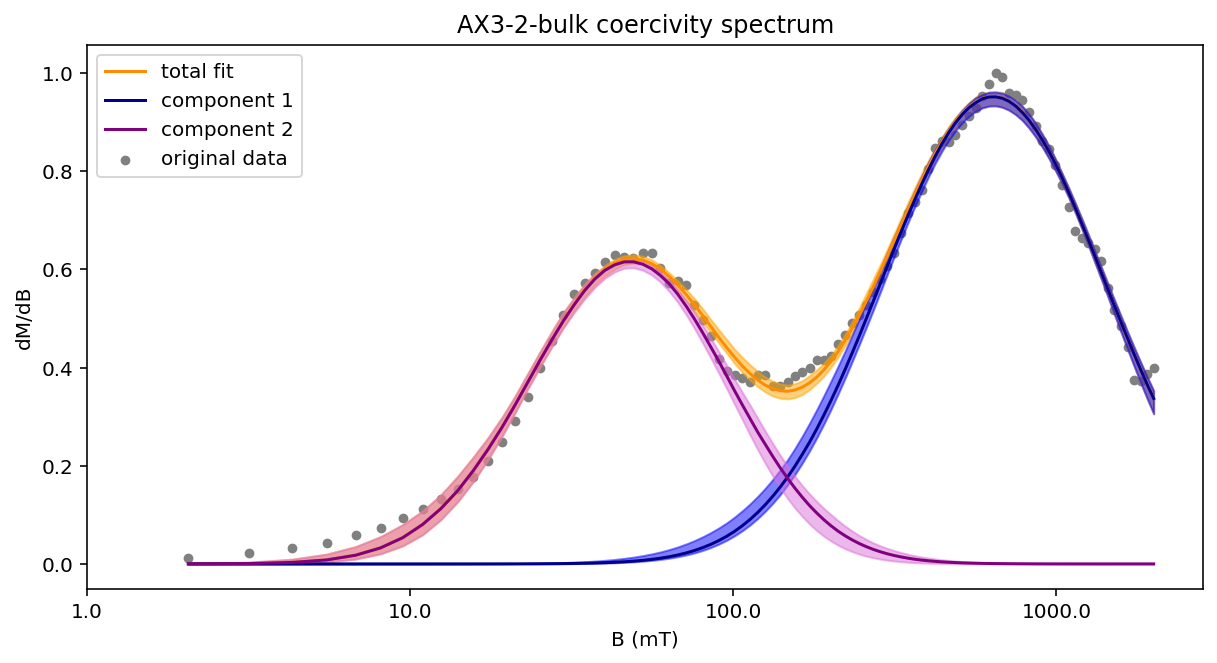

In [19]:
AX3_2_bulk_error = plot_error_estimate(AX3_2_bulk_logBlist, AX3_2_bulk_dMdBlist, specimen_name, AX3_2_bulk_in_list, savefig = False)

### AX5-1r

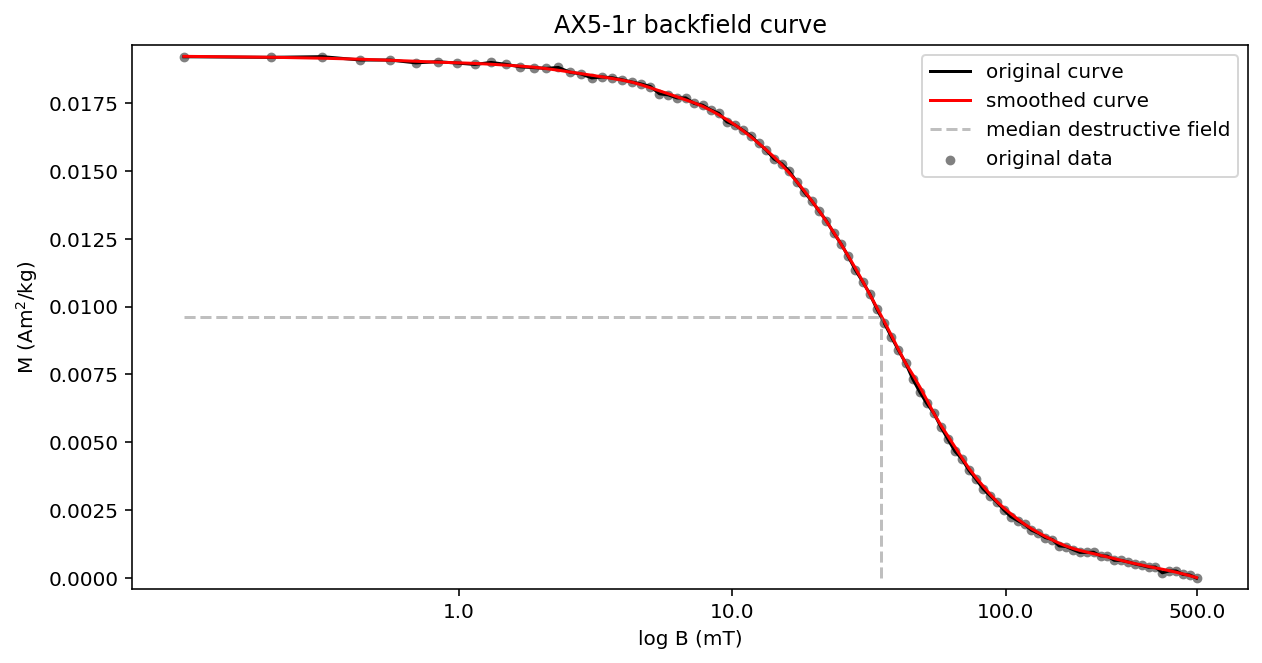

In [20]:
AX5_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 16, 0.1)

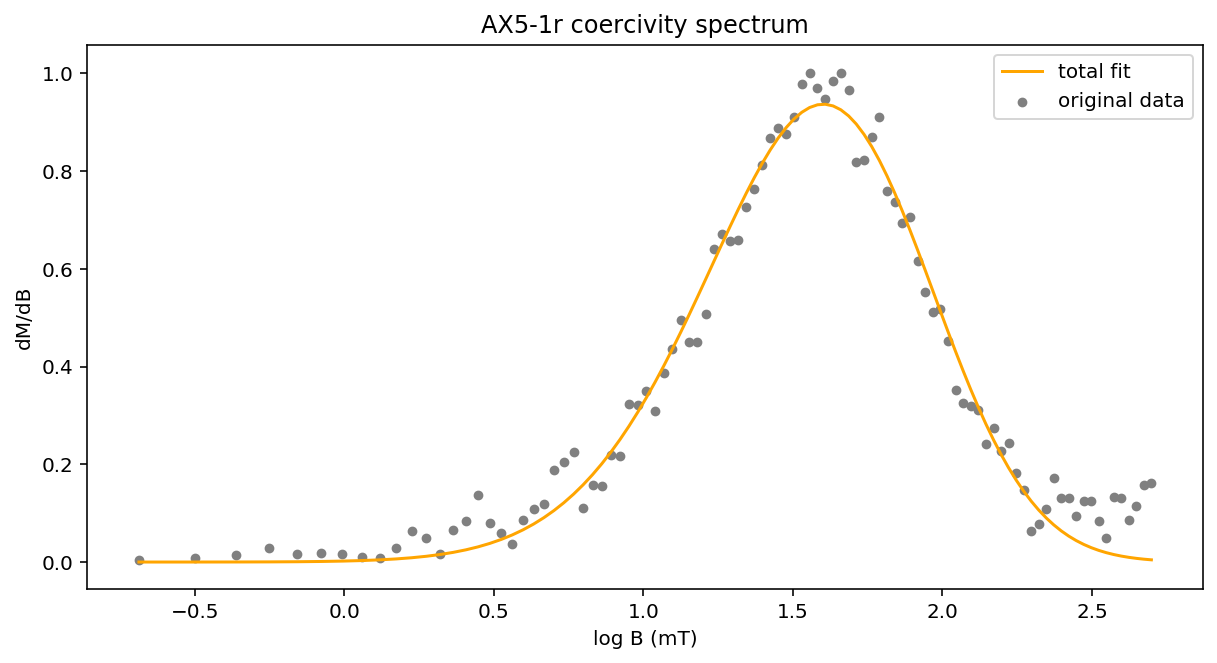

In [21]:
AX5_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 16, 0.05, 0.1)['Log_Blist'][2:]
AX5_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 16, 0.05, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 16, 0.05, 0.1)['Name']

AX5_1_in_list = [1, 2., .2, 1.]
AX5_1_fit_result = plot_unmix_data(AX5_1_logBlist, AX5_1_dMdBlist, specimen_name, AX5_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


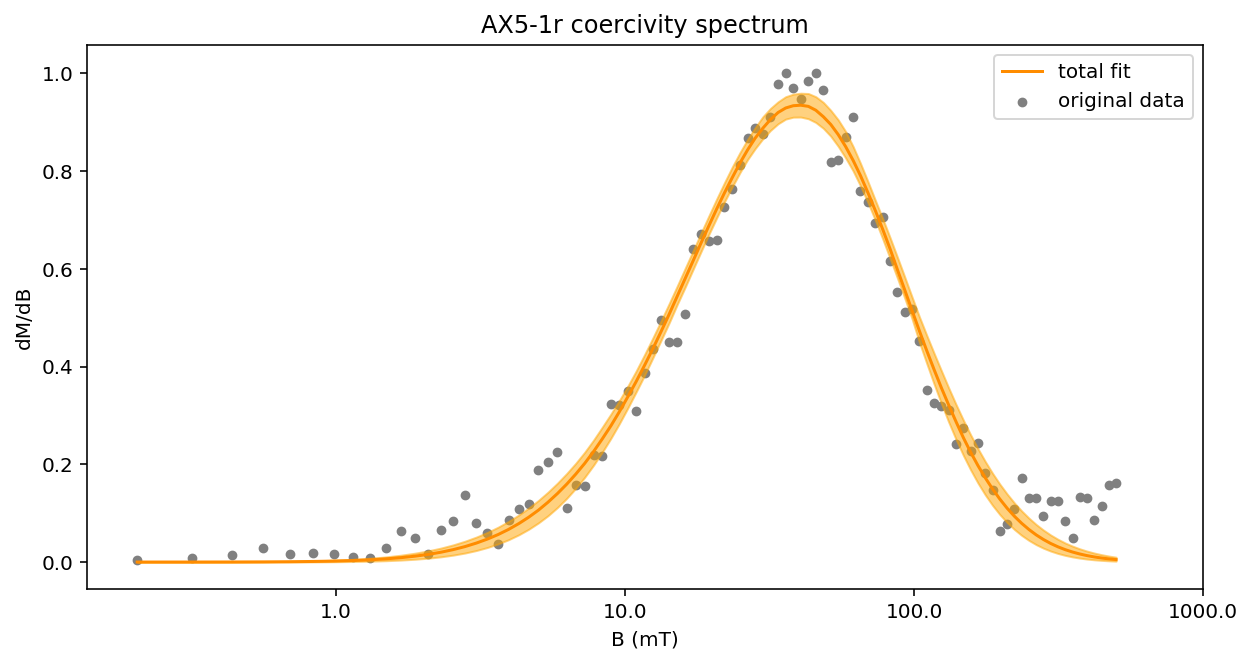

In [22]:
AX5_1_fit_error = plot_error_estimate(AX5_1_logBlist, AX5_1_dMdBlist, specimen_name, AX5_1_in_list, savefig = False)

### AX6-1r

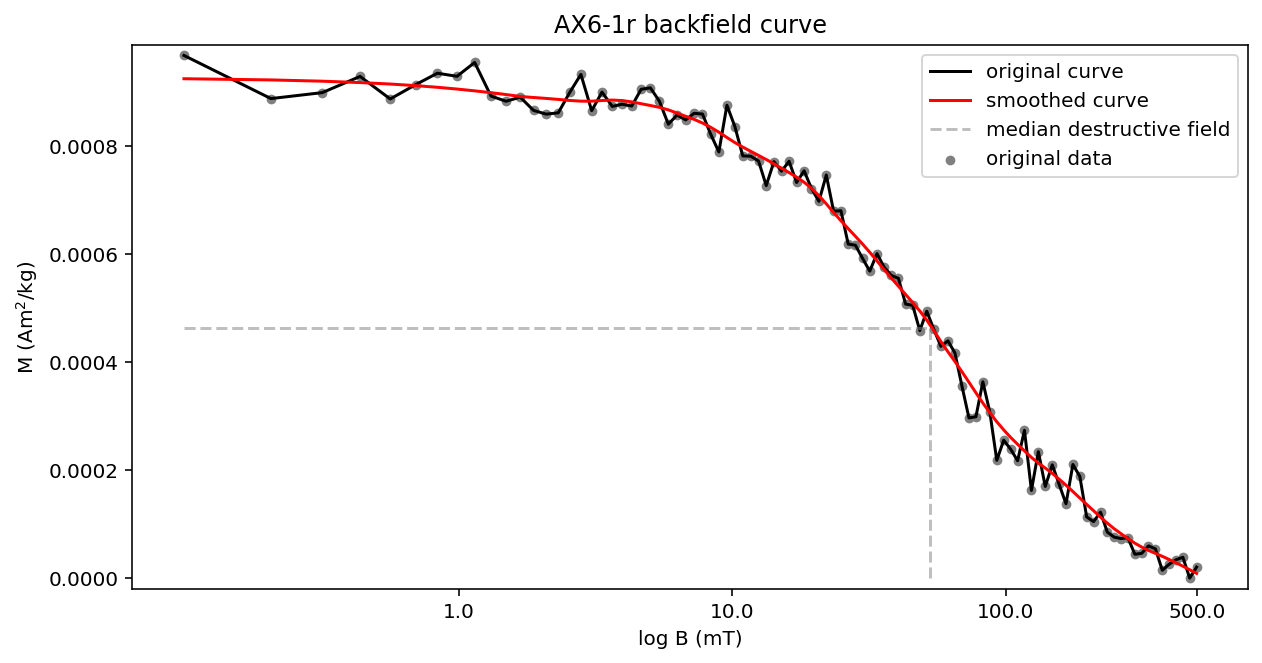

In [23]:
AX6_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 17, 0.2)

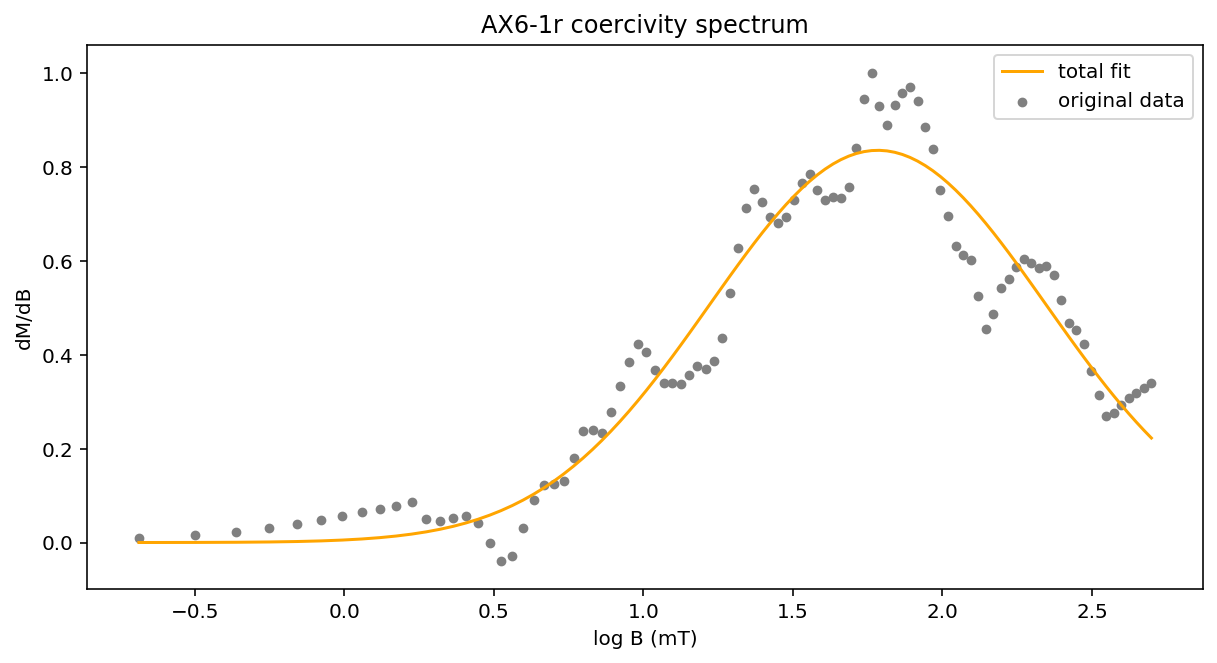

In [24]:
AX6_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 17, 0.2, 0.1)['Log_Blist'][2:]
AX6_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 17, 0.2, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 17, 0.2, 0.1)['Name']

AX6_1_in_list = [1, 2., .2, 1.]
AX6_1_fit_result = plot_unmix_data(AX6_1_logBlist, AX6_1_dMdBlist, specimen_name, AX6_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


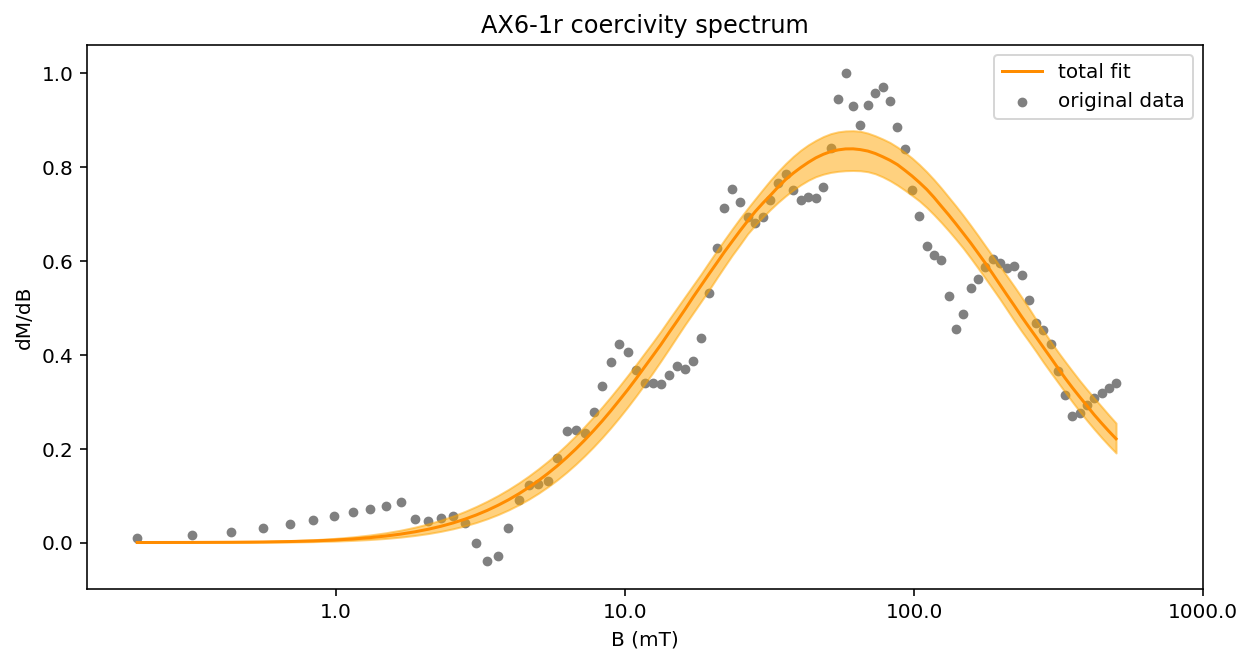

In [25]:
AX6_1_fit_error = plot_error_estimate(AX6_1_logBlist, AX6_1_dMdBlist, specimen_name, AX6_1_in_list, savefig = False)

### AX7-1r

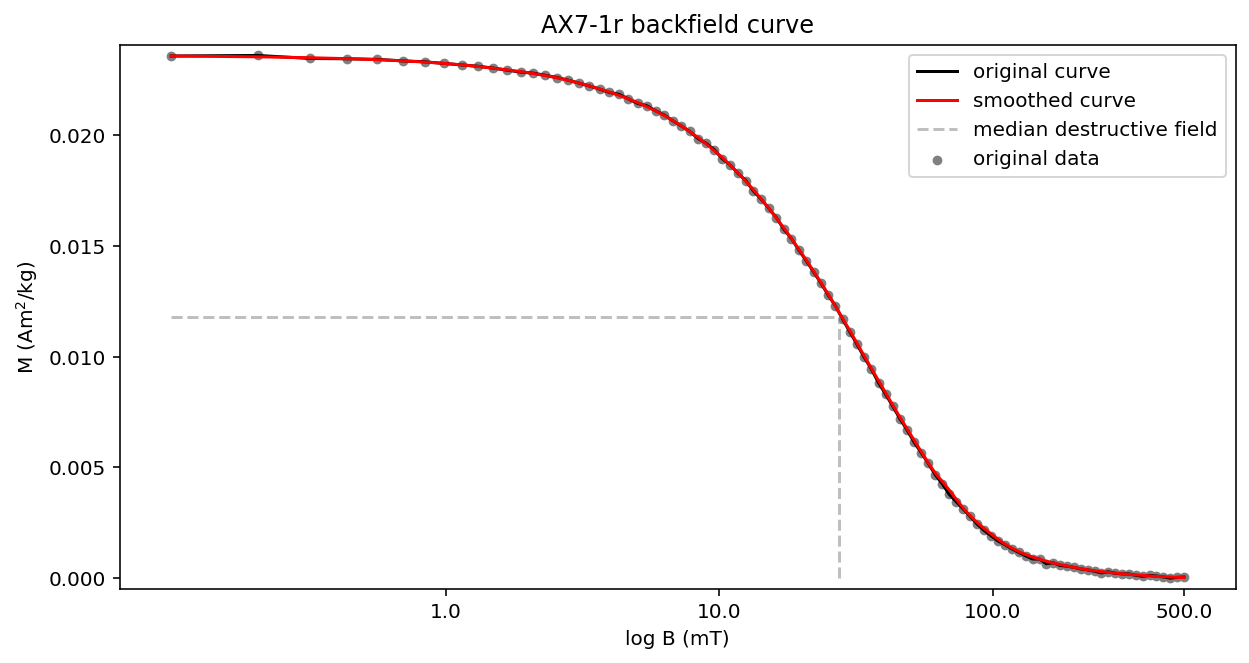

In [26]:
AX7_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 18, 0.1)

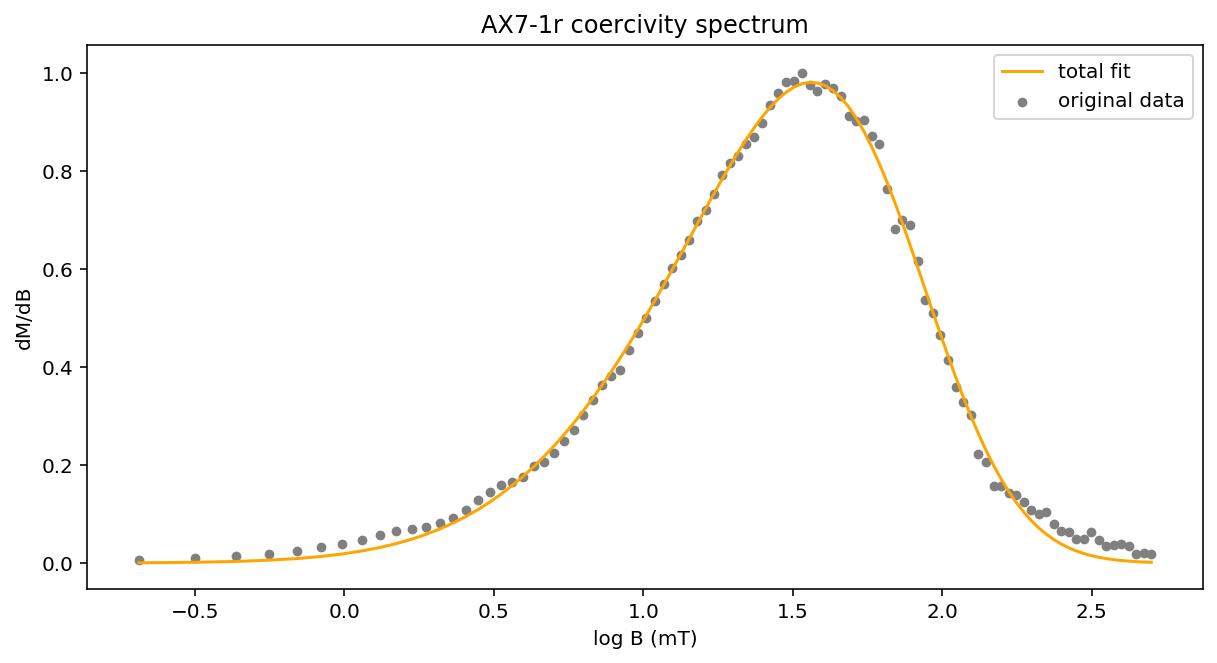

In [27]:
AX7_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 18, 0.08, 0.1)['Log_Blist'][2:]
AX7_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 18, 0.08, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 18, 0.08, 0.1)['Name']

AX7_1_in_list = [1, 2., .2, 1.]
AX7_1_fit_result = plot_unmix_data(AX7_1_logBlist, AX7_1_dMdBlist, specimen_name, AX7_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


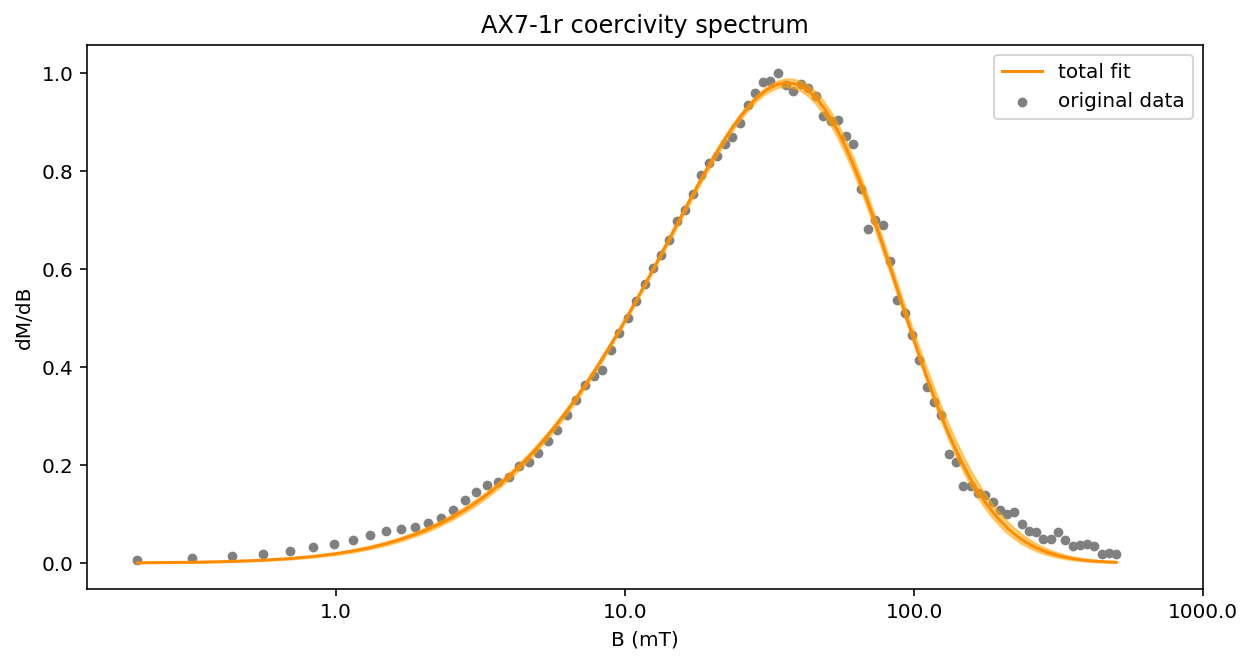

In [28]:
AX7_1_fit_error = plot_error_estimate(AX7_1_logBlist, AX7_1_dMdBlist, specimen_name, AX7_1_in_list, savefig = False)

### AX8-1r

This is a weak sample, VSM data is noisy. We will not use the Princeton VSM data for this sample.

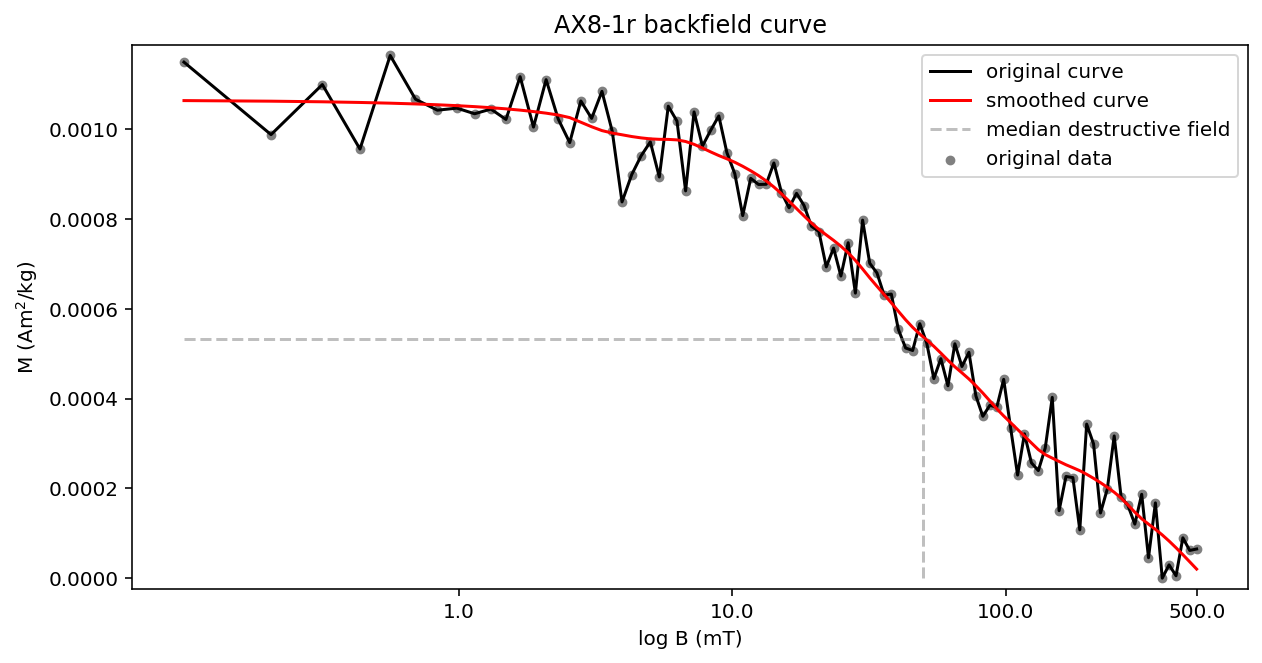

In [29]:
AX8_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 19, 0.25)

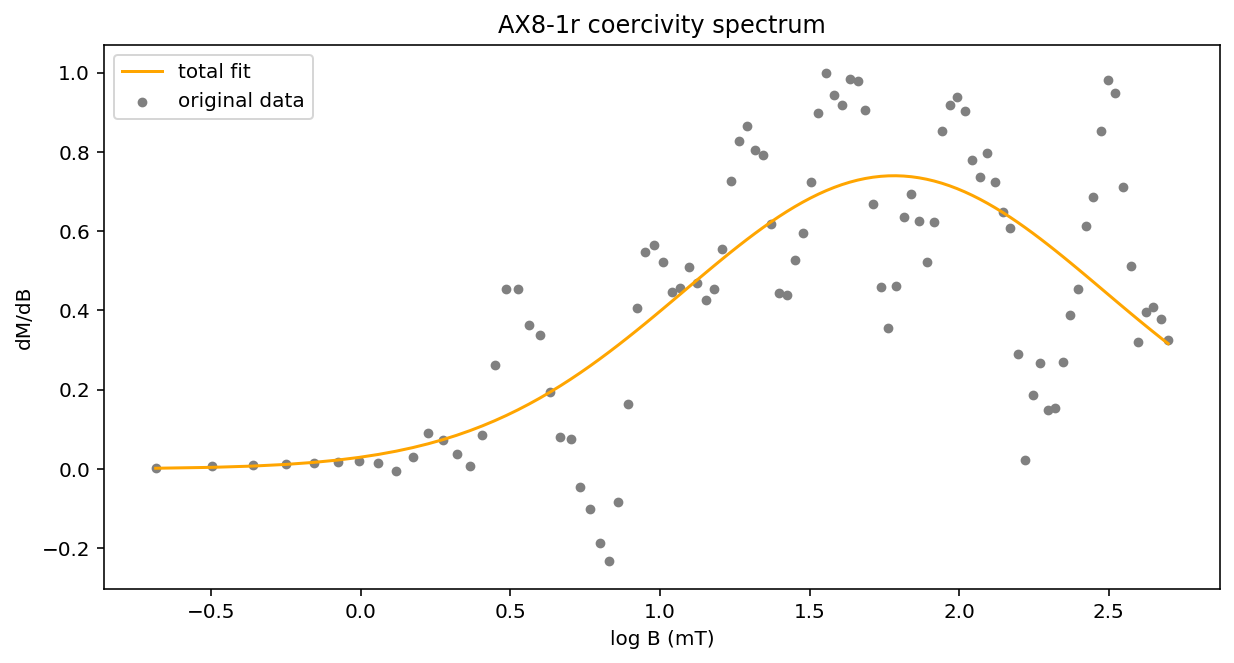

In [30]:
AX8_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 19, 0.15, 0.1)['Log_Blist'][2:]
AX8_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 19, 0.15, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 19, 0.15, 0.1)['Name']

AX8_1_in_list = [1, 2., .2, 1.]
AX8_1_fit_result = plot_unmix_data(AX8_1_logBlist, AX8_1_dMdBlist, specimen_name, AX8_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


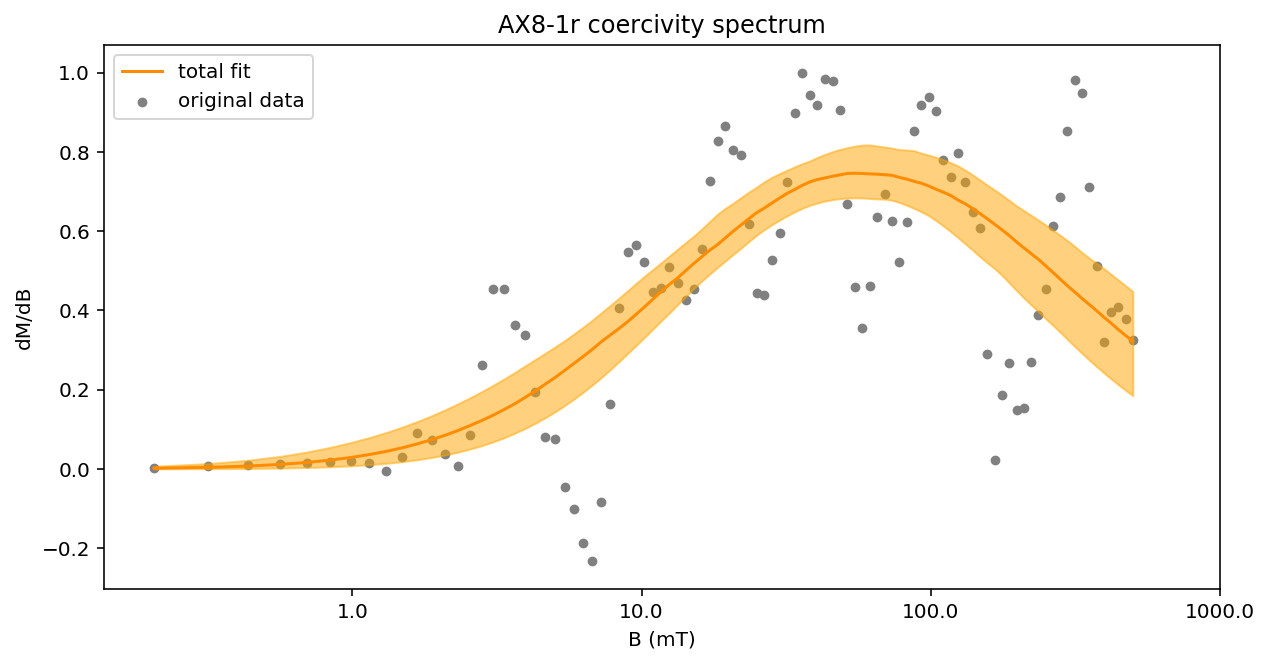

In [31]:
AX8_1_fit_error = plot_error_estimate(AX8_1_logBlist, AX8_1_dMdBlist, specimen_name, AX8_1_in_list, savefig = False)

### AX9-2r
This is a weak sample, VSM data is noisy. We will not use the Princeton VSM data for this sample.

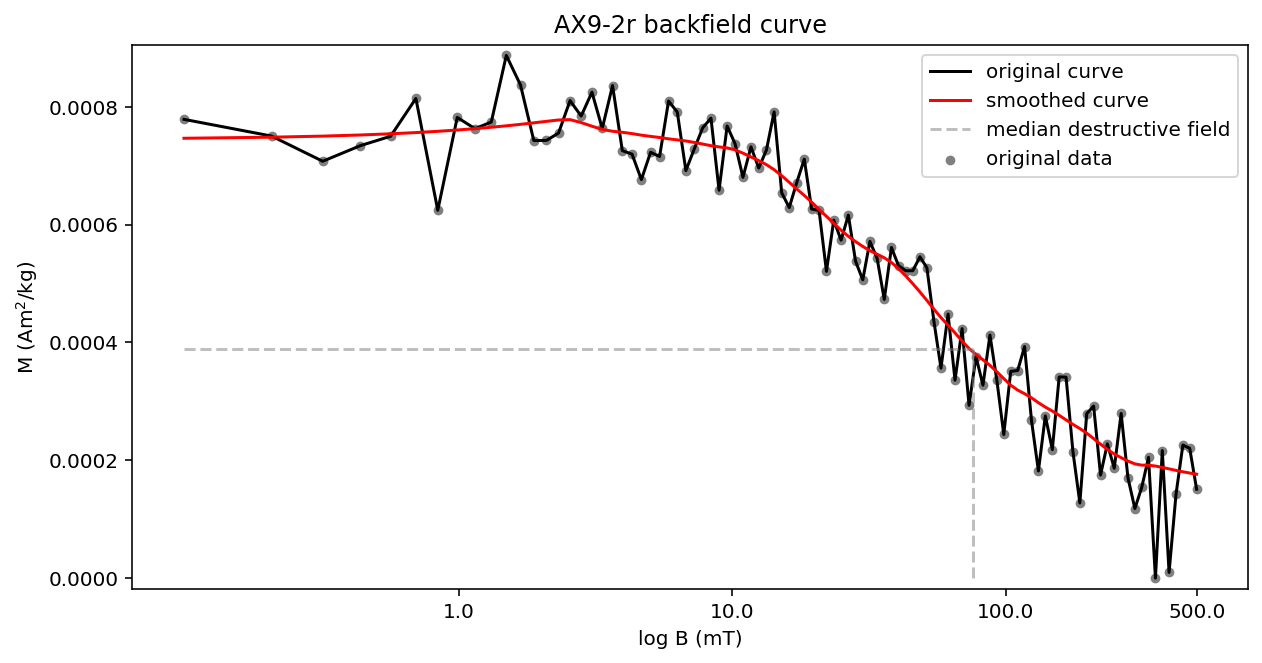

In [32]:
AX9_2_MDF = plot_VSM_bf_data(VSM_bf_measurements, 20, 0.25)

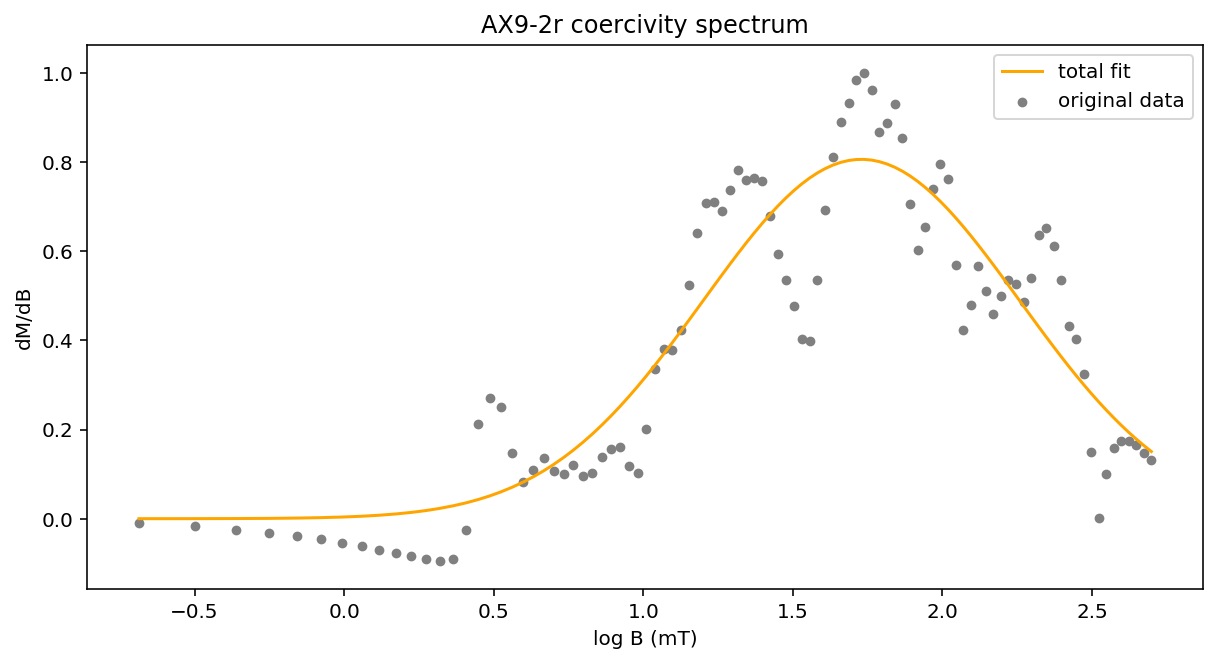

In [33]:
AX9_2_logBlist = get_VSM_bf_data(VSM_bf_measurements, 20, 0.25, 0.1)['Log_Blist'][2:]
AX9_2_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 20, 0.25, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 20, 0.25, 0.1)['Name']

AX9_2_in_list = [1, 2., .2, 1.]
AX9_2_fit_result = plot_unmix_data(AX9_2_logBlist, AX9_2_dMdBlist, specimen_name, AX9_2_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


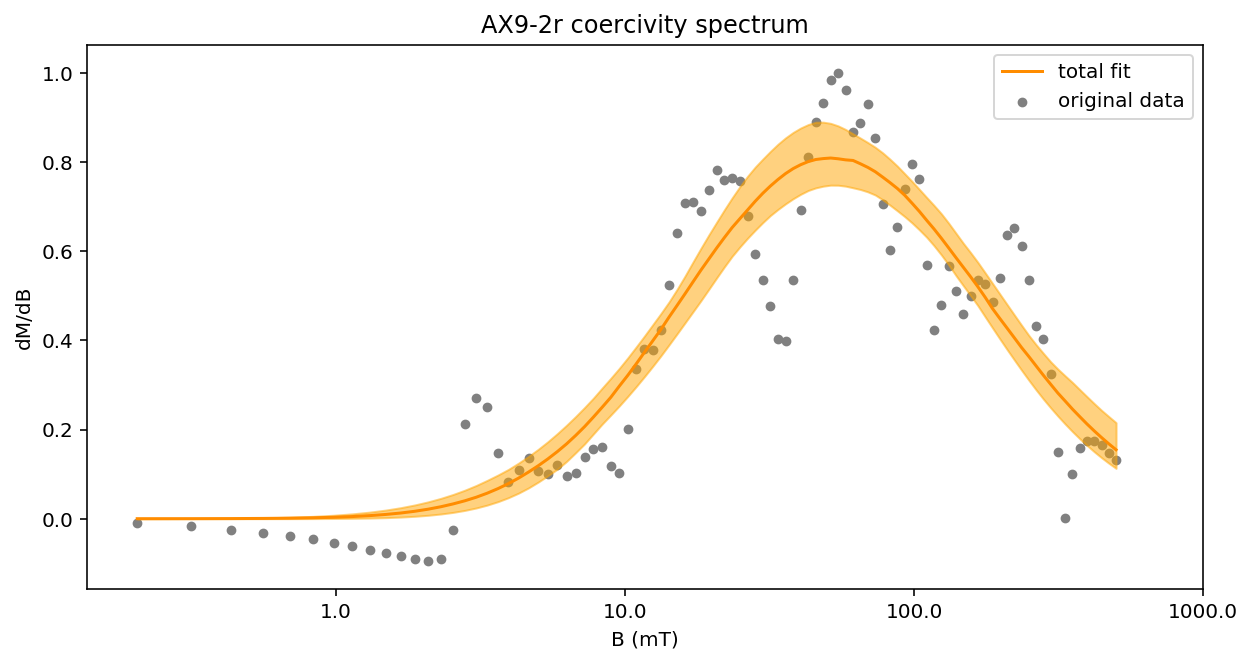

In [34]:
AX9_2_fit_error = plot_error_estimate(AX9_2_logBlist, AX9_2_dMdBlist, specimen_name, AX9_2_in_list, savefig = False)

### AX10-3r

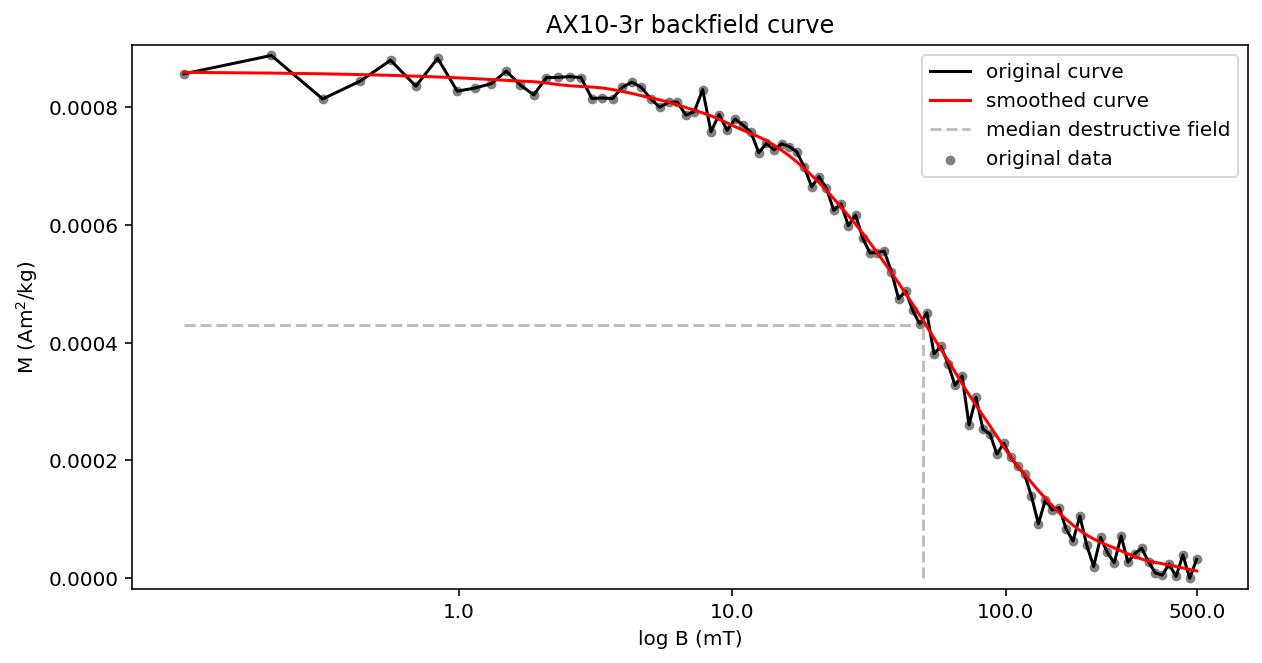

In [35]:
AX10_3_MDF = plot_VSM_bf_data(VSM_bf_measurements, 1, 0.2)

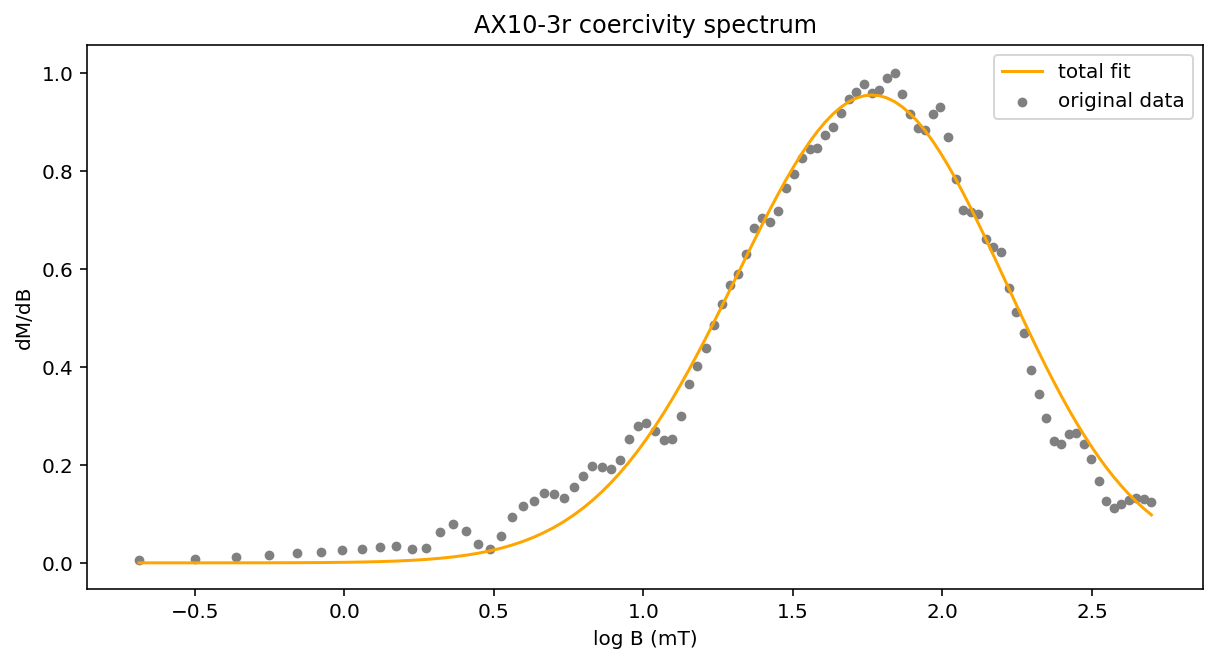

In [36]:
AX10_3_logBlist = get_VSM_bf_data(VSM_bf_measurements, 1, 0.2, 0.1)['Log_Blist'][2:]
AX10_3_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 1, 0.2, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 1, 0.2, 0.1)['Name']

AX10_3_in_list = [1, 2., .2, 1.]
AX10_3_fit_result = plot_unmix_data(AX10_3_logBlist, AX10_3_dMdBlist, specimen_name, AX10_3_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


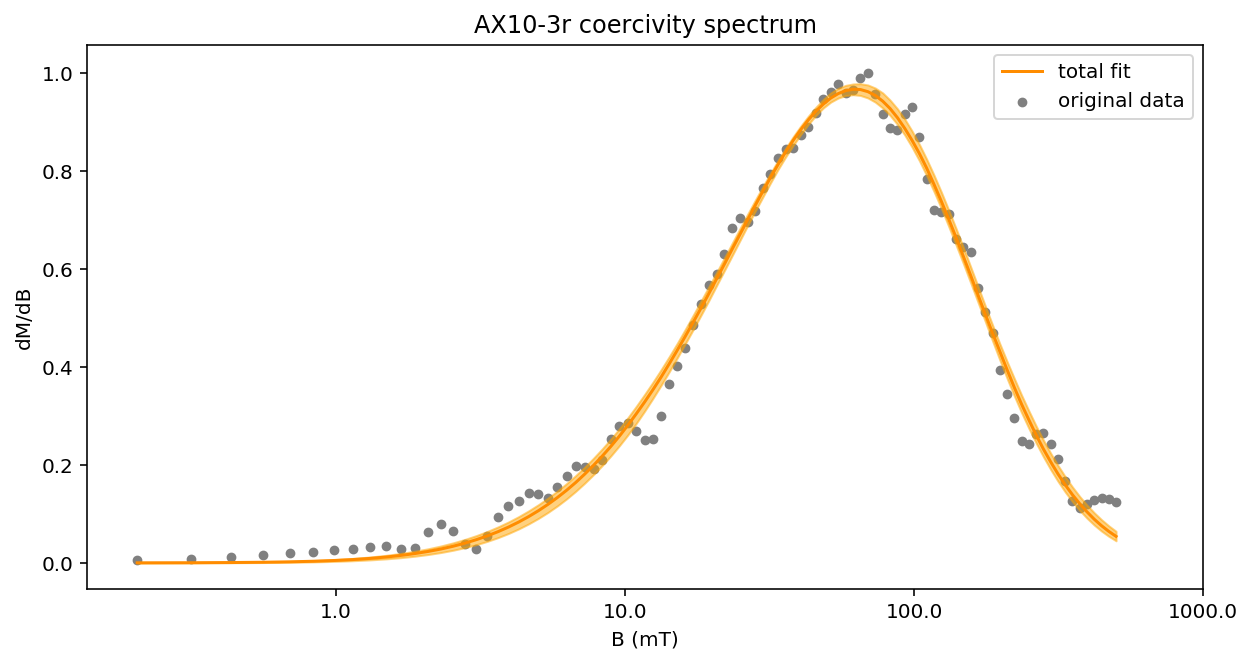

In [37]:
AX10_3_fit_error = plot_error_estimate(AX10_3_logBlist, AX10_3_dMdBlist, specimen_name, AX10_3_in_list, savefig = False)

### AX11-2r

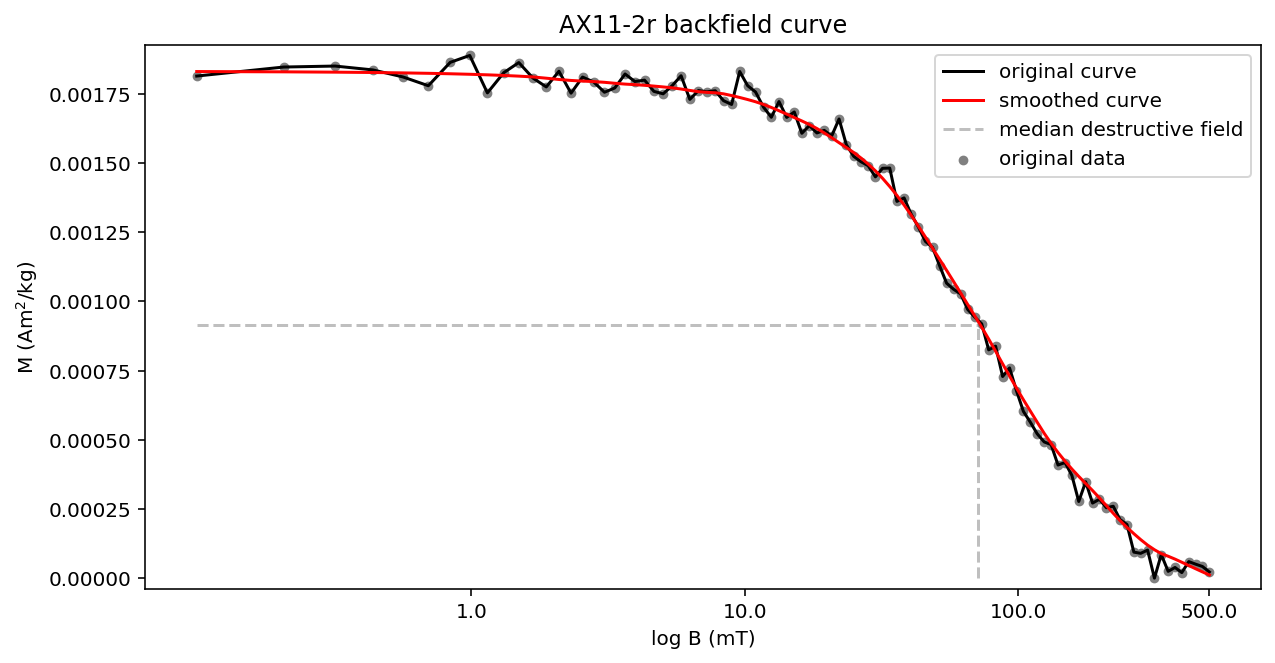

In [38]:
AX11_2_MDF = plot_VSM_bf_data(VSM_bf_measurements, 2, 0.2)

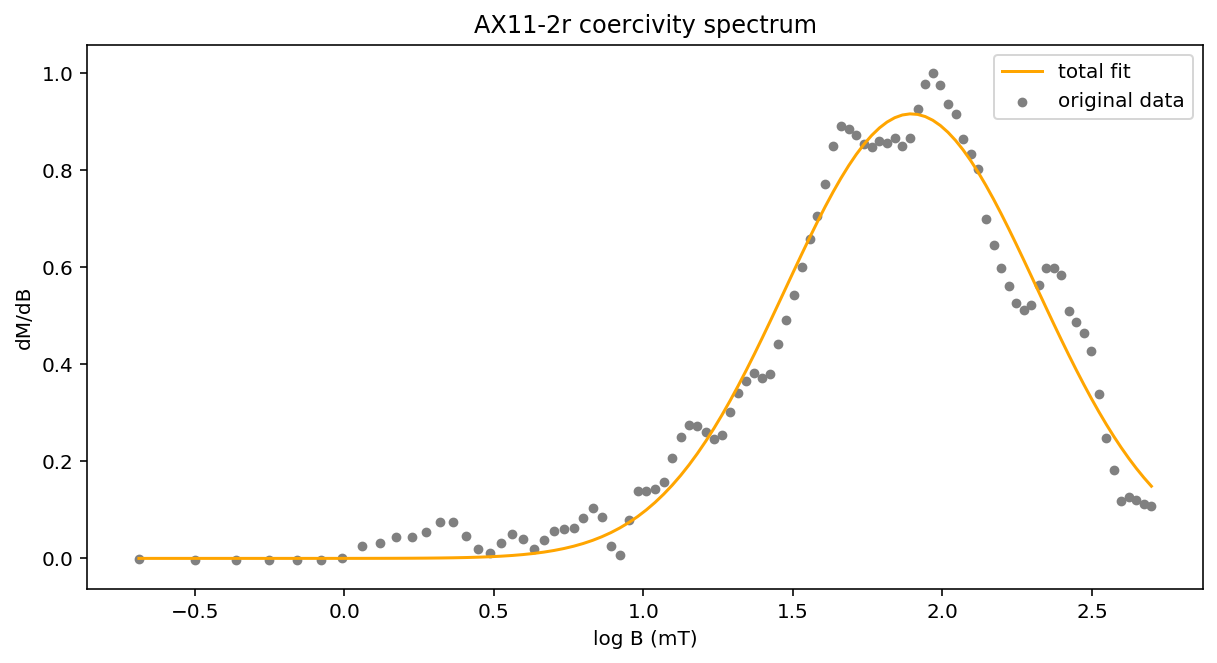

In [39]:
AX11_2_logBlist = get_VSM_bf_data(VSM_bf_measurements, 2, 0.15, 0.1)['Log_Blist'][2:]
AX11_2_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 2, 0.15, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 2, 0.15, 0.1)['Name']

AX11_2_in_list = [1, 2., .2, 1.]
AX11_2_fit_result = plot_unmix_data(AX11_2_logBlist, AX11_2_dMdBlist, specimen_name, AX11_2_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


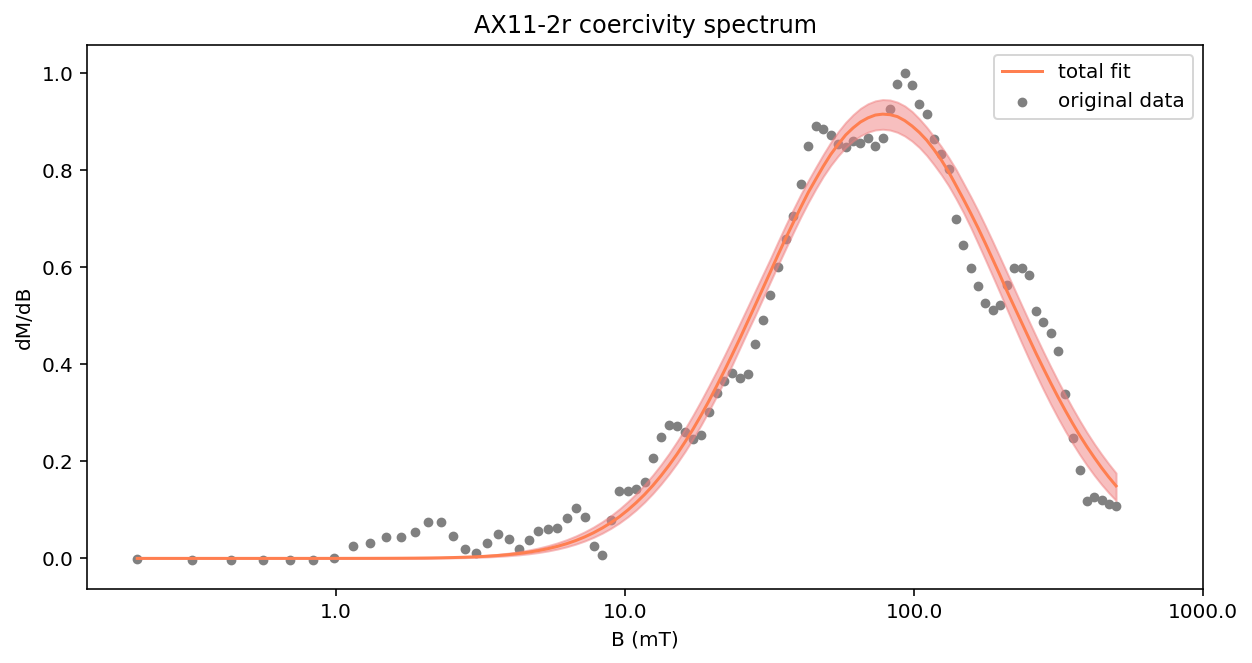

In [40]:
AX11_2_fit_error = plot_error_estimate(AX11_2_logBlist, AX11_2_dMdBlist, specimen_name, AX11_2_in_list, init_color_code_components=['coral'], init_color_code_error=['lightcoral'], savefig = False)

### AX12-6r

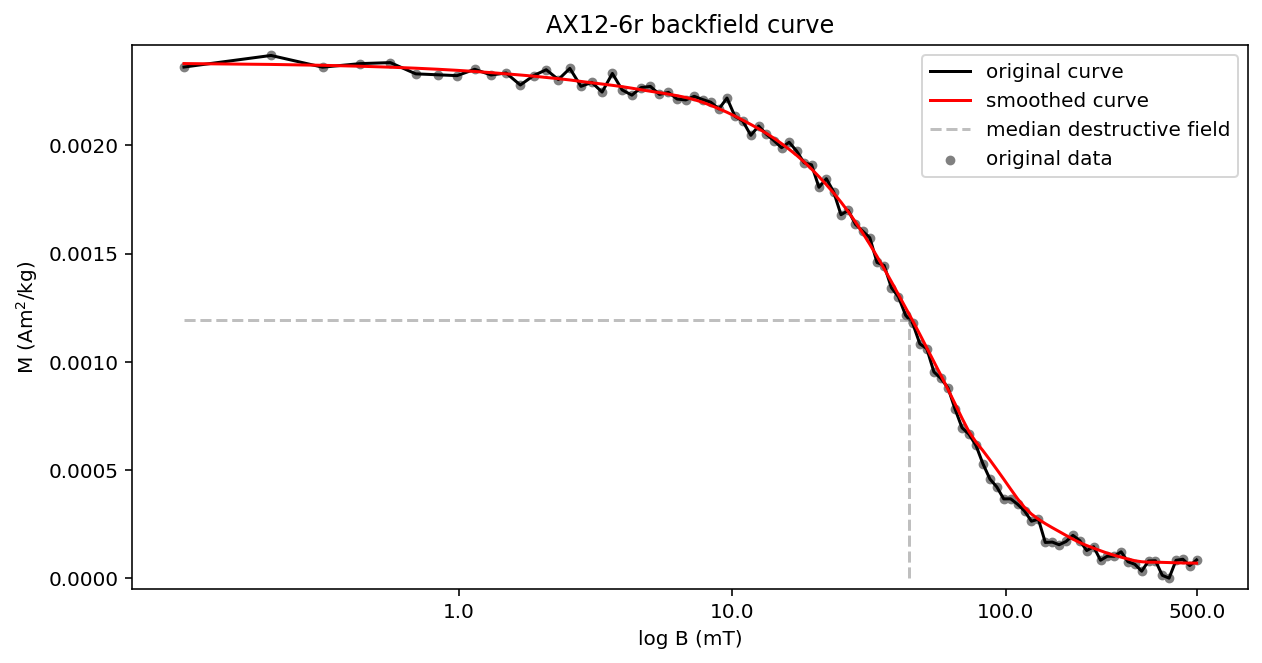

In [41]:
AX12_6_MDF = plot_VSM_bf_data(VSM_bf_measurements, 3, 0.2)

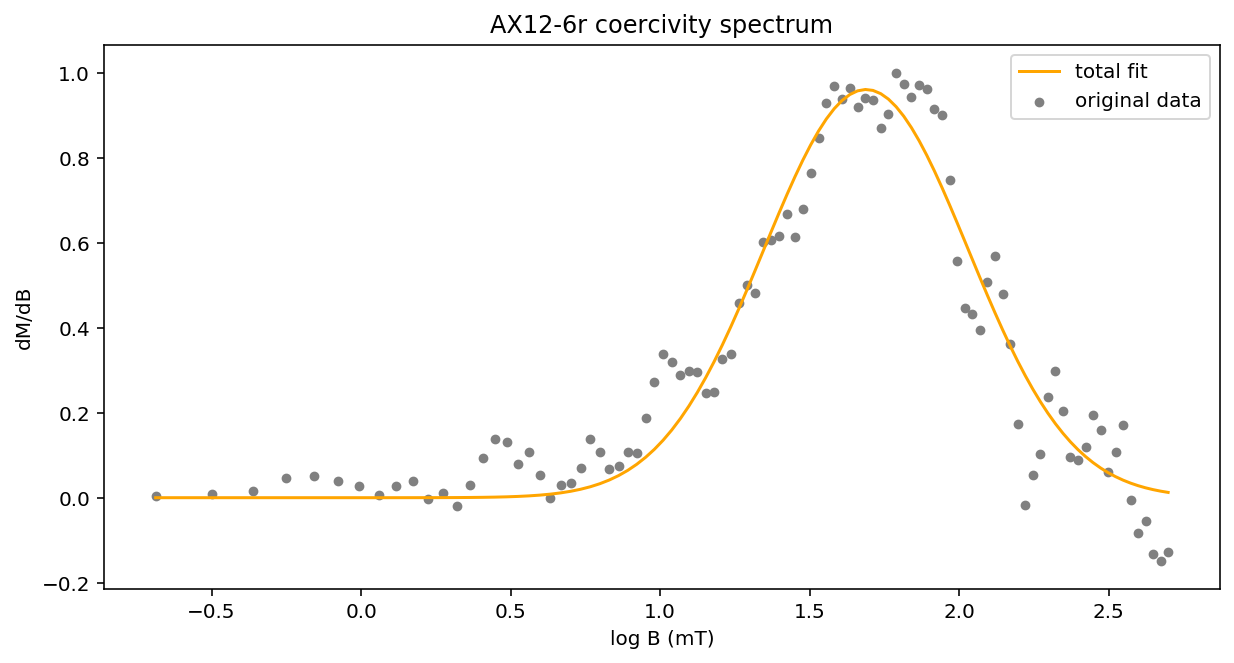

In [42]:
AX12_6_logBlist = get_VSM_bf_data(VSM_bf_measurements, 3, 0.08, 0.1)['Log_Blist'][2:]
AX12_6_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 3, 0.08, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 3, 0.08, 0.1)['Name']

AX12_6_in_list = [1, 2., .2, 1.]
AX12_6_fit_result = plot_unmix_data(AX12_6_logBlist, AX12_6_dMdBlist, specimen_name, AX12_6_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


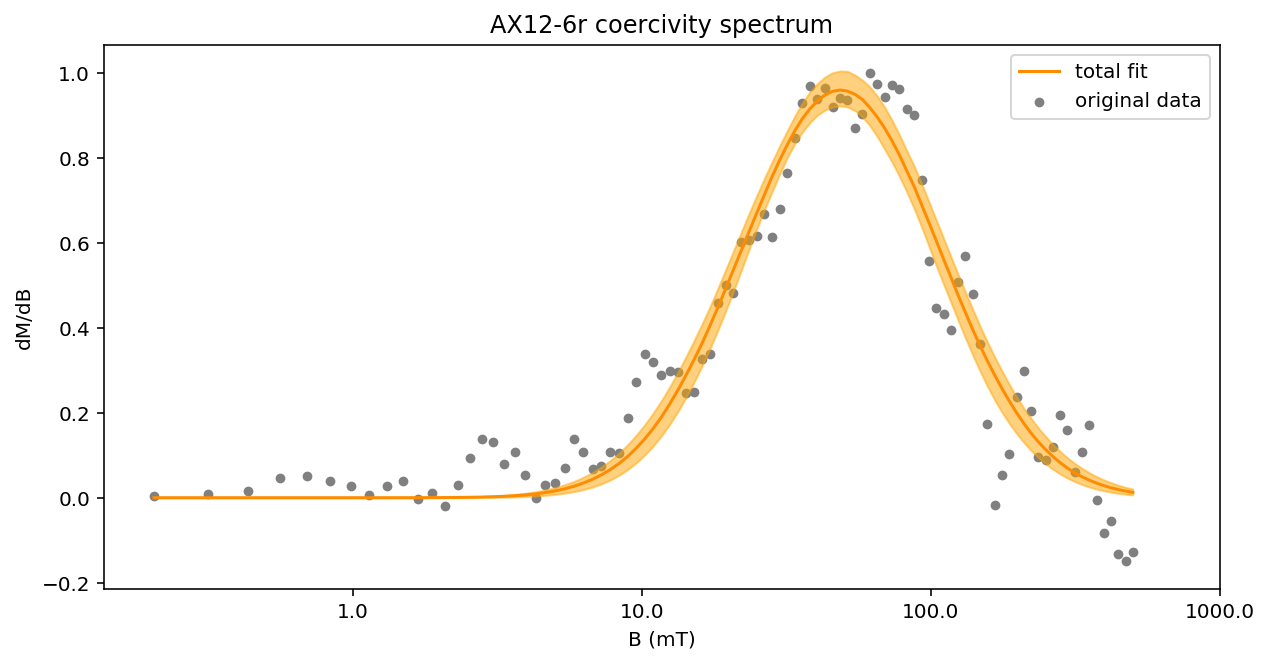

In [43]:
AX12_6_fit_error = plot_error_estimate(AX12_6_logBlist, AX12_6_dMdBlist, specimen_name, AX12_6_in_list, savefig = False)

### AX13-1r

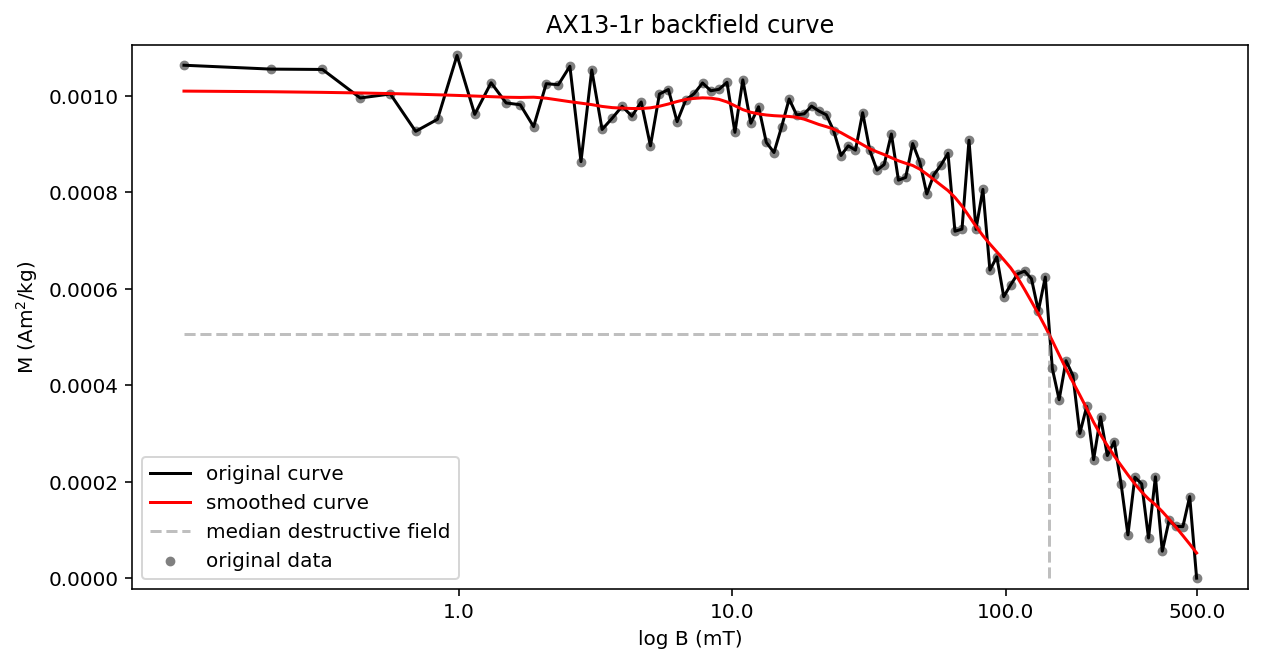

In [44]:
AX13_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 4, 0.2)

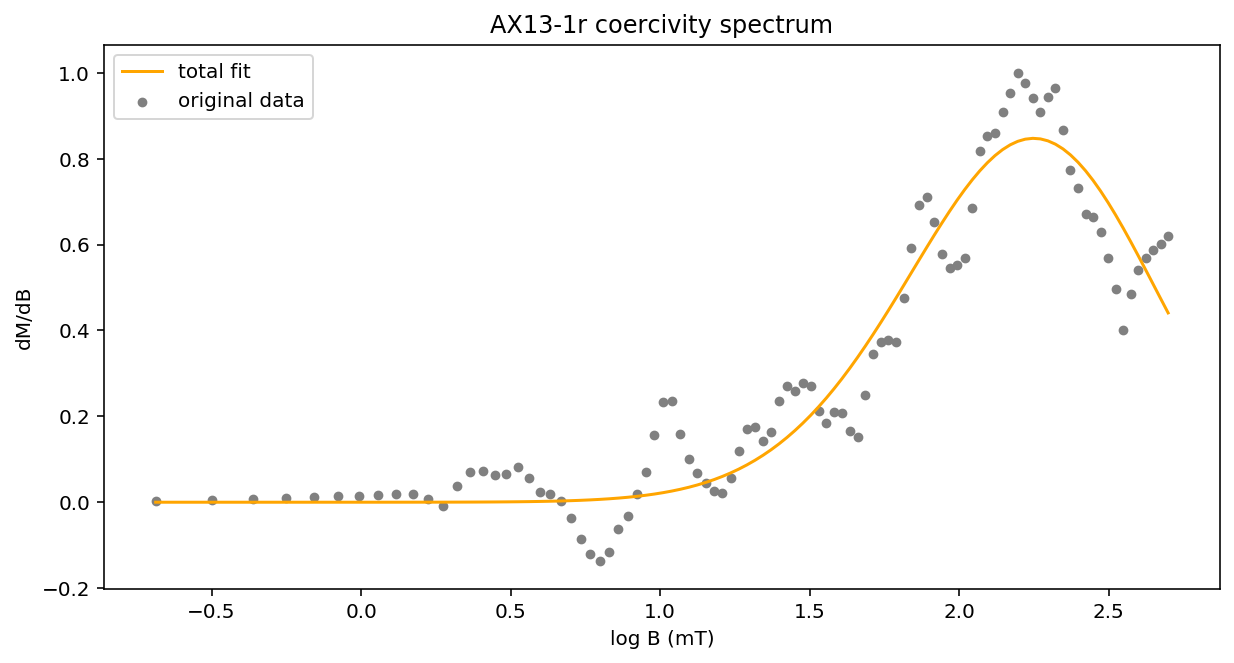

In [45]:
AX13_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 4, 0.2, 0.15)['Log_Blist'][2:]
AX13_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 4, 0.2, 0.15)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 4, 0.2, 0.15)['Name']

AX13_1_in_list = [1, 2., .2, 1.]
AX13_1_fit_result = plot_unmix_data(AX13_1_logBlist, AX13_1_dMdBlist, specimen_name, AX13_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


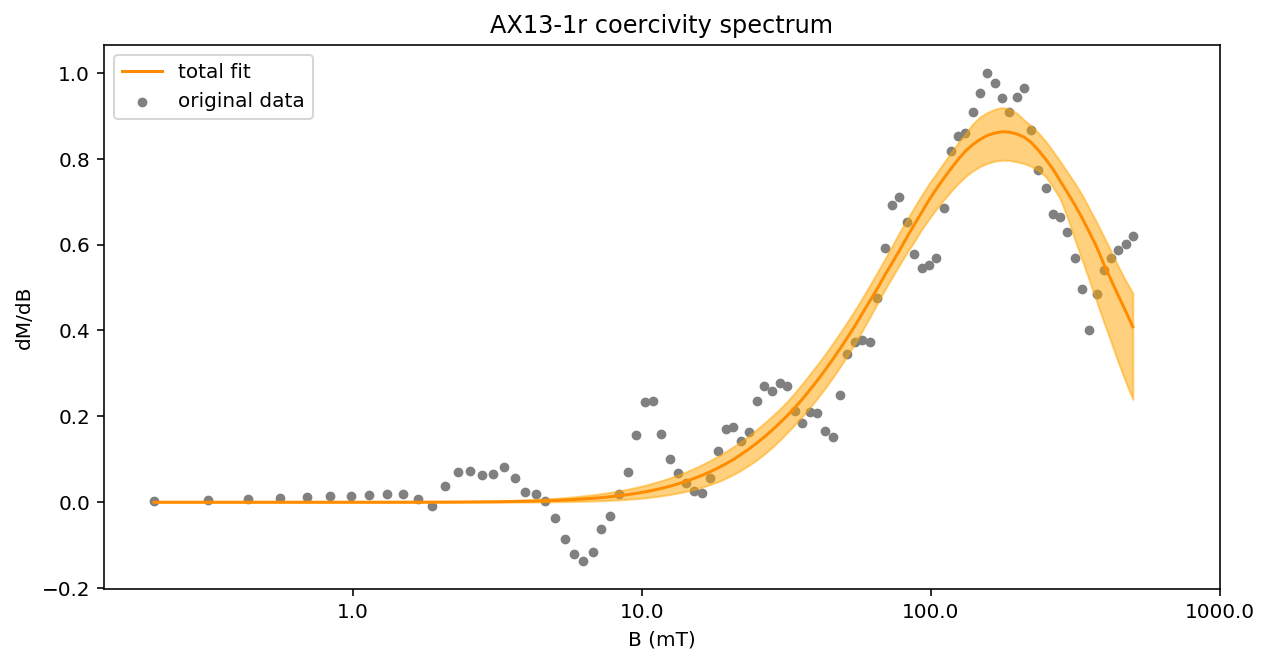

In [46]:
AX13_1_fit_error = plot_error_estimate(AX13_1_logBlist, AX13_1_dMdBlist, specimen_name, AX13_1_in_list, savefig = False)

### AX15-2r
This is a weak sample, VSM data is noisy. We will not use the Princeton VSM data for this sample.

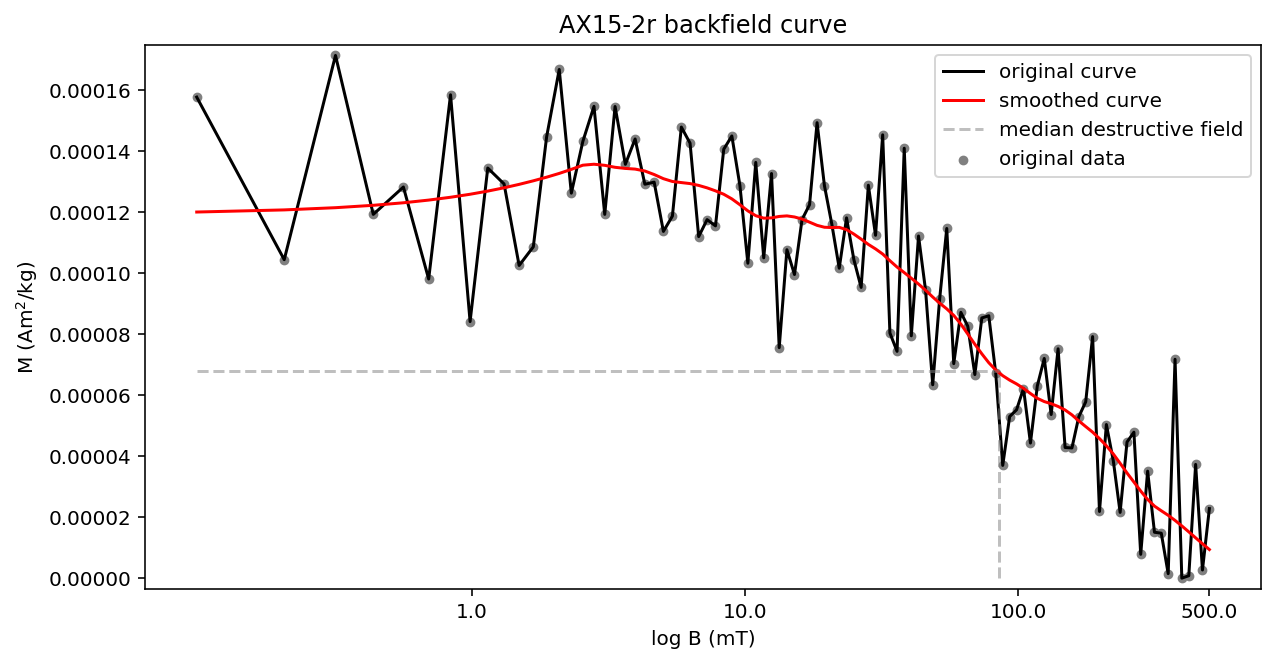

In [47]:
AX15_2_MDF = plot_VSM_bf_data(VSM_bf_measurements, 6, 0.25)

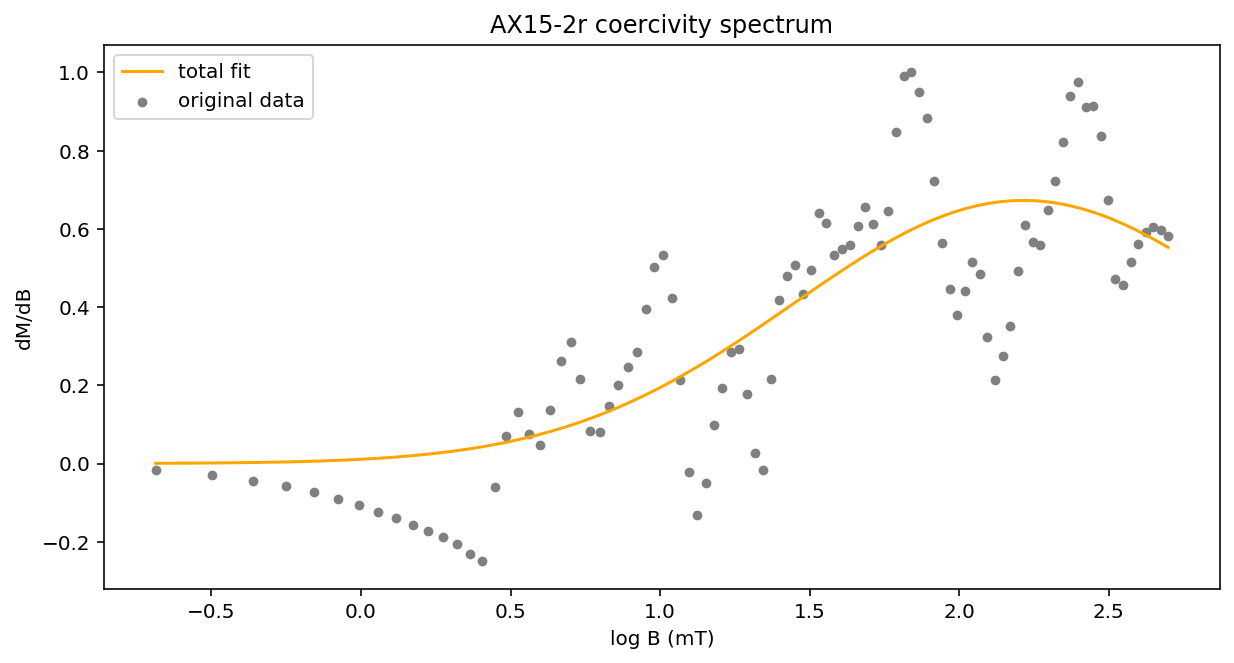

In [48]:
AX15_2_logBlist = get_VSM_bf_data(VSM_bf_measurements, 6, 0.25, 0.1)['Log_Blist'][2:]
AX15_2_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 6, 0.25, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 6, 0.25, 0.1)['Name']

AX15_2_in_list = [1, 2., .2, 1.]
AX15_2_fit_result = plot_unmix_data(AX15_2_logBlist, AX15_2_dMdBlist, specimen_name, AX15_2_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


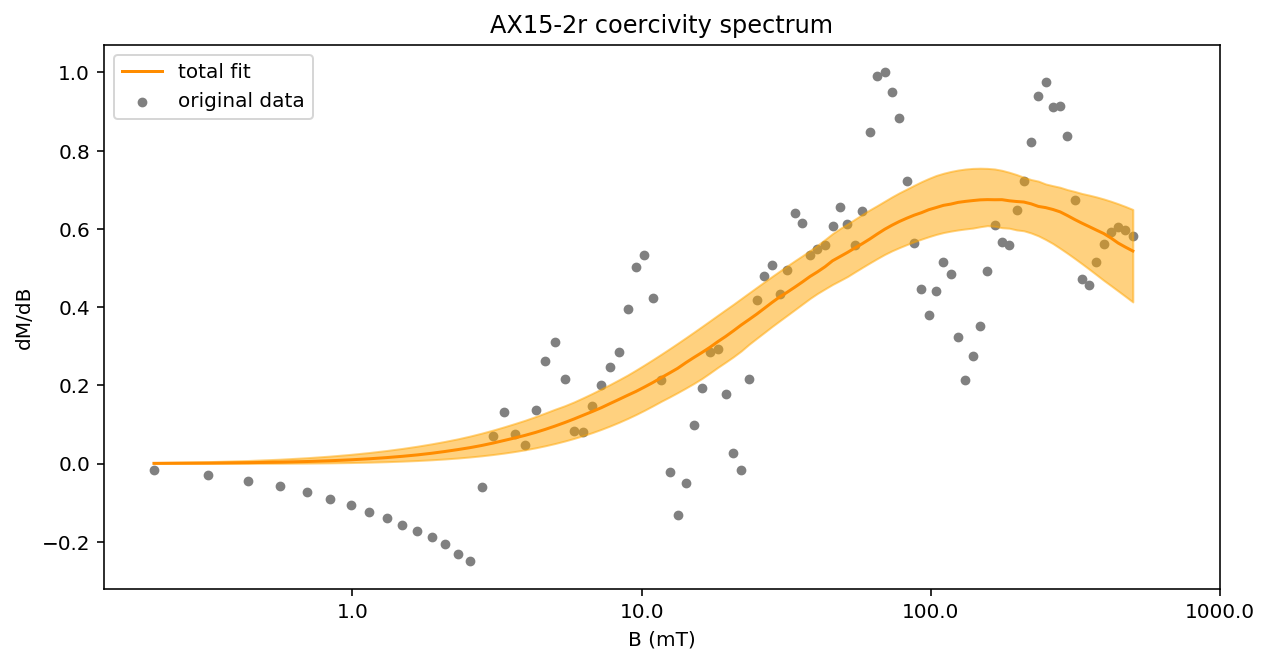

In [49]:
AX15_2_fit_error = plot_error_estimate(AX15_2_logBlist, AX15_2_dMdBlist, specimen_name, AX15_2_in_list, savefig = False)

### AX16-1r
This is a weak sample, VSM data is noisy. We will not use the Princeton VSM data for this sample.

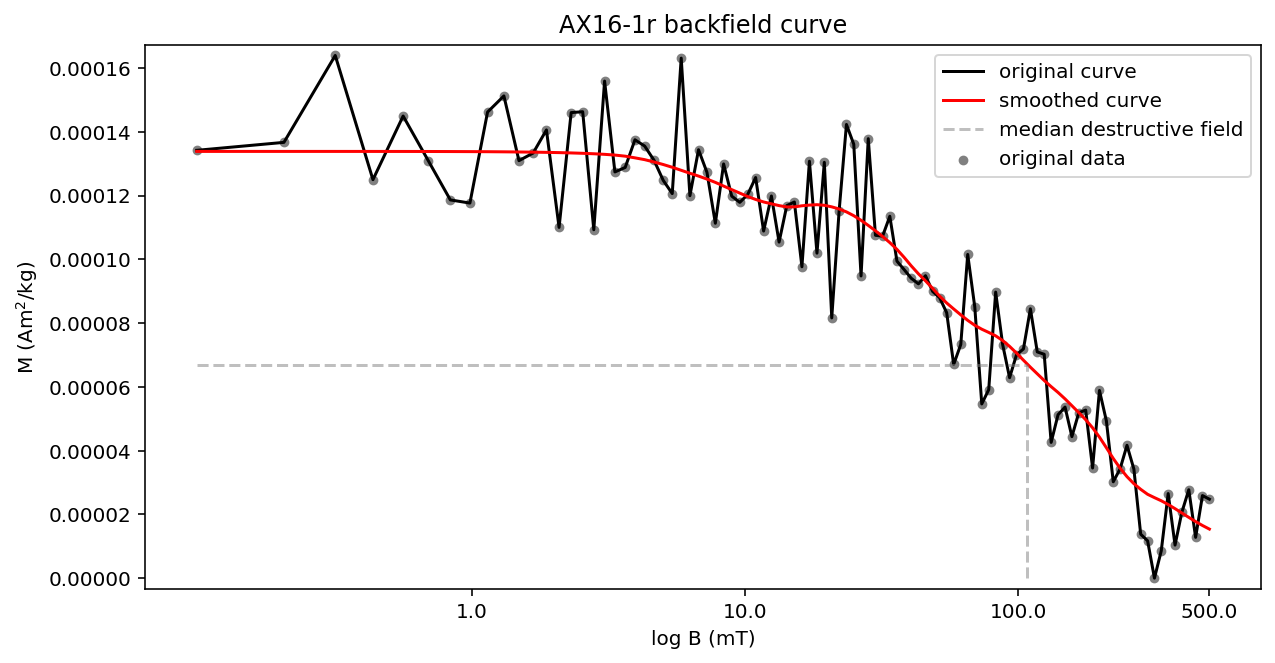

In [50]:
AX16_1_MDF = plot_VSM_bf_data(VSM_bf_measurements, 7, 0.3, savefig = False)

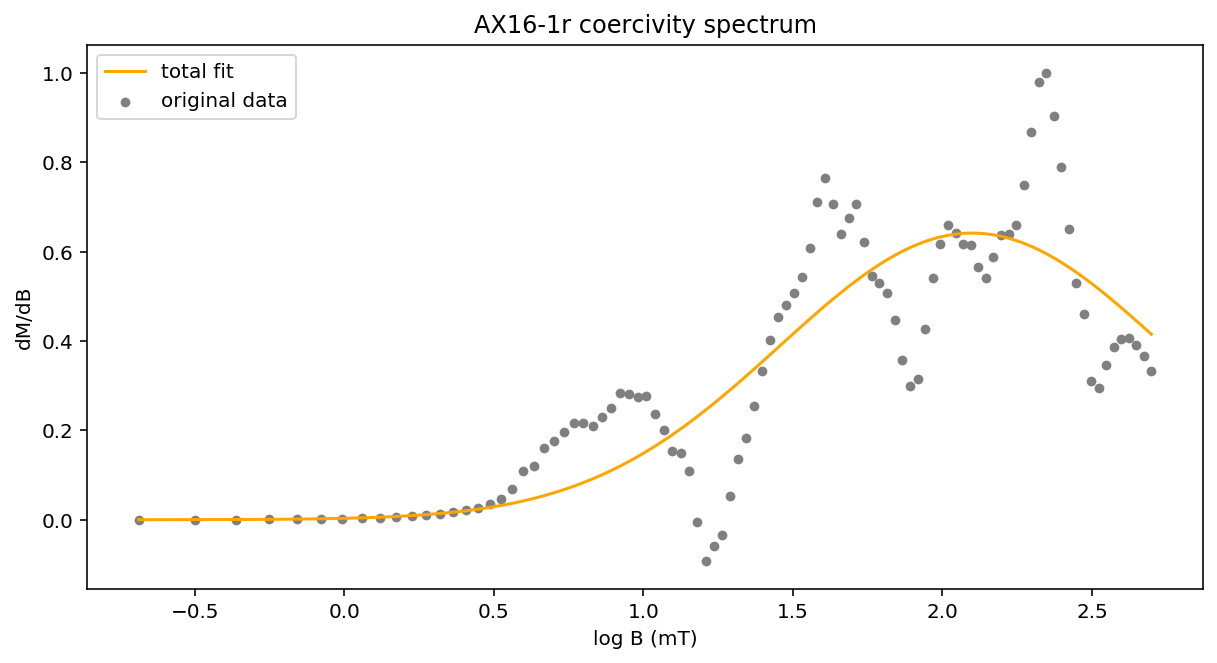

In [51]:
AX16_1_logBlist = get_VSM_bf_data(VSM_bf_measurements, 7, 0.3, 0.1)['Log_Blist'][2:]
AX16_1_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 7, 0.3, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 7, 0.3, 0.1)['Name']

AX16_1_in_list = [1, 2., .2, 1.]
AX16_1_fit_result = plot_unmix_data(AX16_1_logBlist, AX16_1_dMdBlist, specimen_name, AX16_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


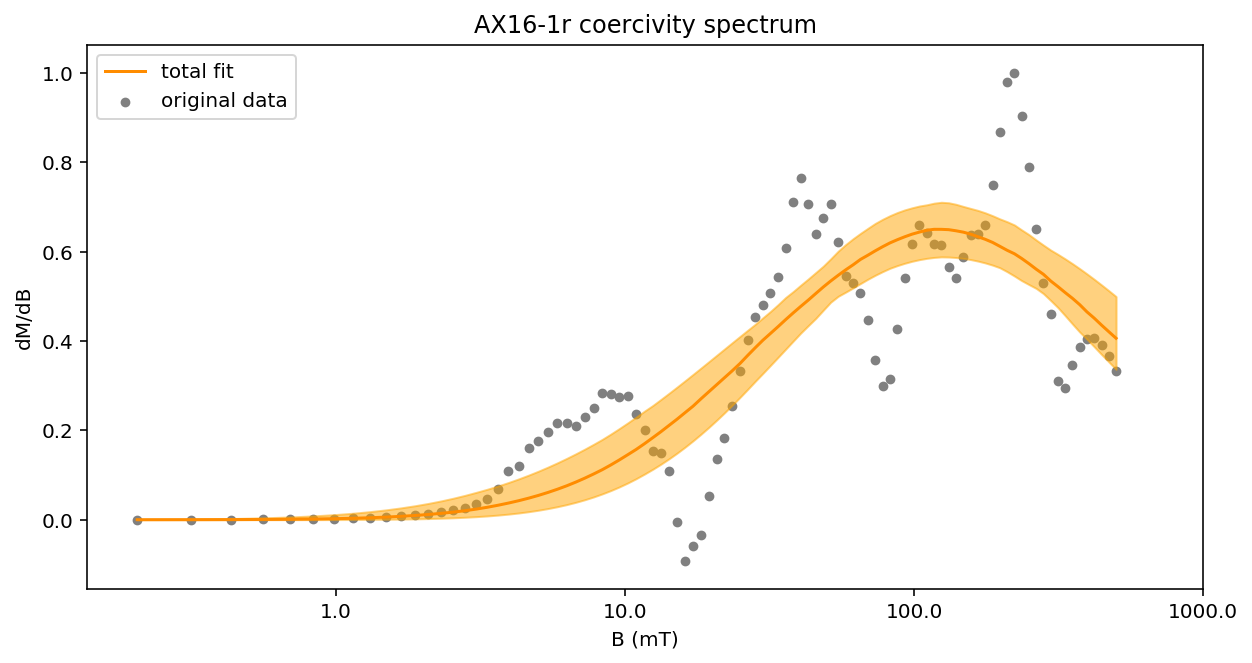

In [52]:
AX16_1_fit_error = plot_error_estimate(AX16_1_logBlist, AX16_1_dMdBlist, specimen_name, AX16_1_in_list, savefig = False)

### AX16-1r Lake Shore

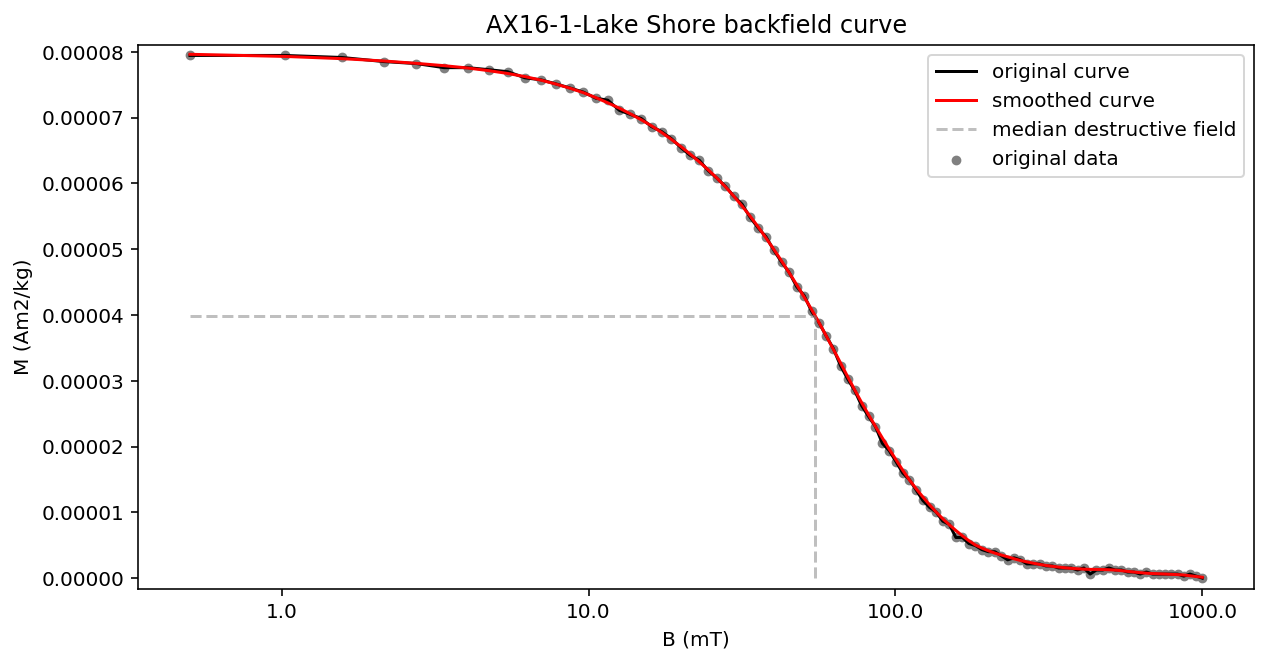

In [53]:
file_path = '../Data/Rock_mag/2020_IRM_data_files/Raw_data/Lake_Shore_VSM/AX16-1r_custom_backfield_hyst-1_backfield.csv'
AX16_1_lakeshore_MDF = plot_Lake_Shore_VSM_bf_data(file_path, 'AX16-1-Lake Shore', frac = 0.1, log = True, mass = 0.3235, savefig = False)

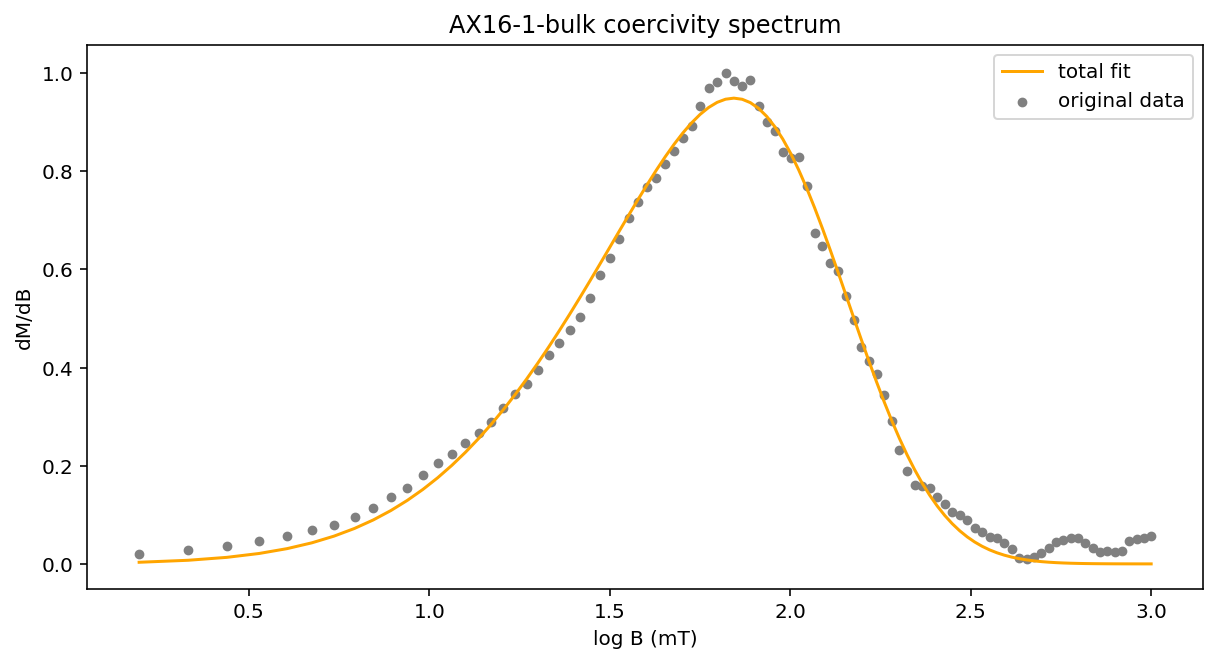

In [54]:
AX16_1_bulk_logBlist = get_Lake_Shore_data(file_path, 'AX16-1-bulk', 0.12, 0.10, mass = 0.3235)['Log_Blist'][2:]
AX16_1_bulk_dMdBlist = get_Lake_Shore_data(file_path, 'AX16-1-bulk', 0.12, 0.10, mass = 0.3235)['Derivative']
specimen_name = get_Lake_Shore_data(file_path, 'AX16-1-bulk', 0.15, 0.12, mass = 0.3235)['Name']
AX16_1_bulk_in_list = [1, 1.7, .1, 1.]
AX16_1_lakeshore_result = plot_unmix_data(AX16_1_bulk_logBlist, AX16_1_bulk_dMdBlist, specimen_name, AX16_1_bulk_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


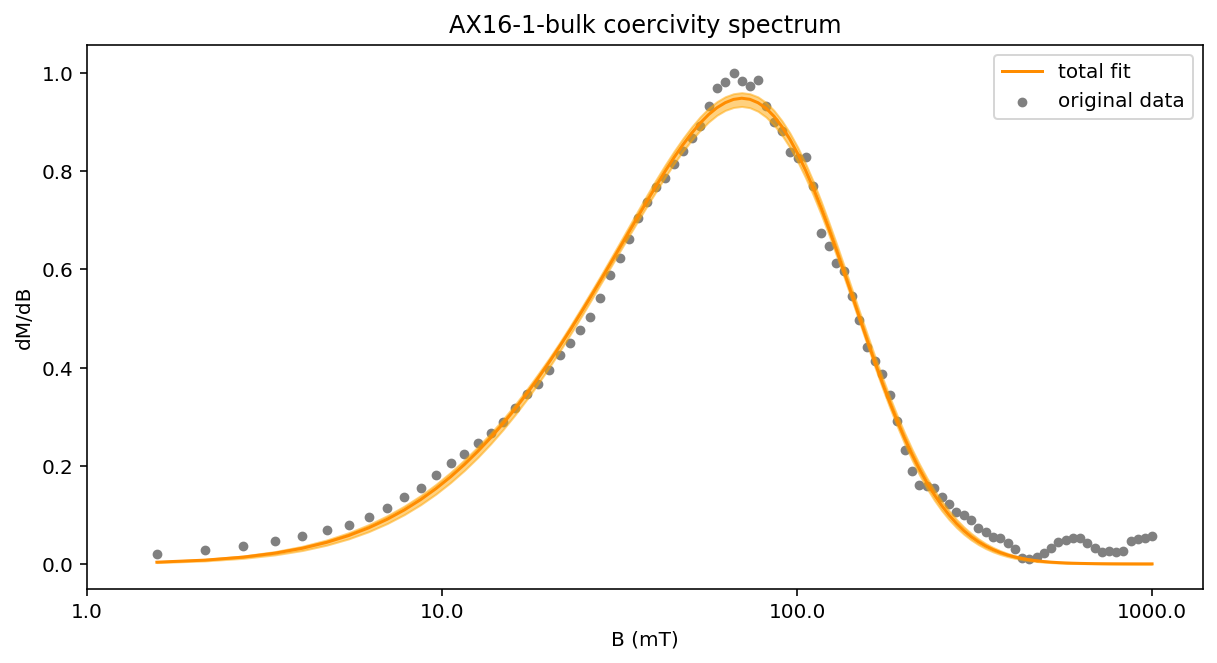

In [55]:
AX16_1_bulk_error = plot_error_estimate(AX16_1_bulk_logBlist, AX16_1_bulk_dMdBlist, specimen_name, AX16_1_bulk_in_list, savefig = False)

## BD Backfield curves and unmixing

### BD1-3r

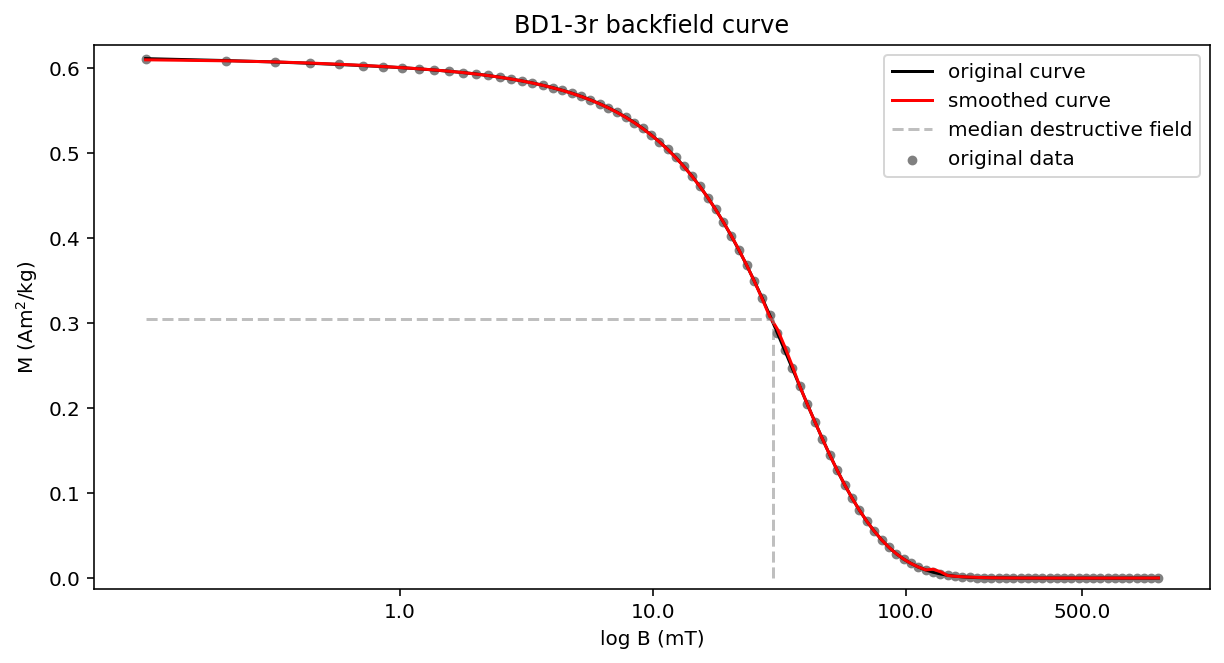

In [56]:
BD1_3_MDF = plot_VSM_bf_data(VSM_bf_measurements, 21, 0.1)

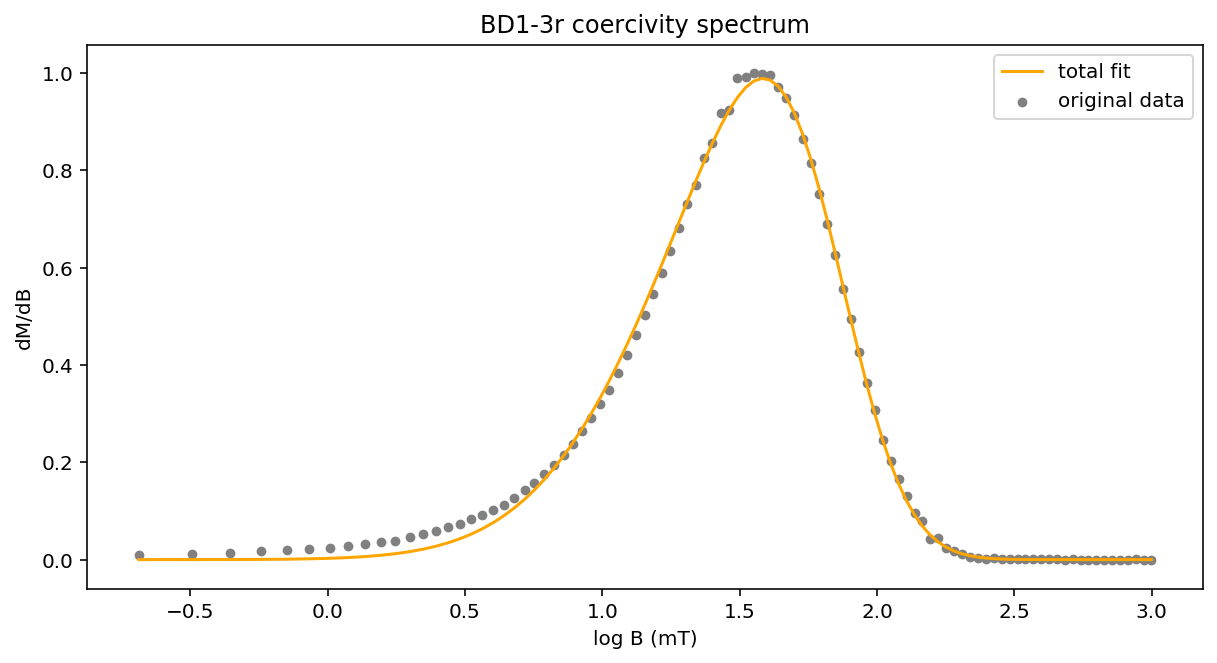

In [57]:
BD1_3_logBlist = get_VSM_bf_data(VSM_bf_measurements, 21, 0.05, 0.2)['Log_Blist'][2:]
BD1_3_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 21, 0.05, 0.2)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 21, 0.05, 0.2)['Name']

BD1_3_in_list = [-1, 2., .2, 1.]
BD1_3_fit_result = plot_unmix_data(BD1_3_logBlist, BD1_3_dMdBlist, specimen_name, BD1_3_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


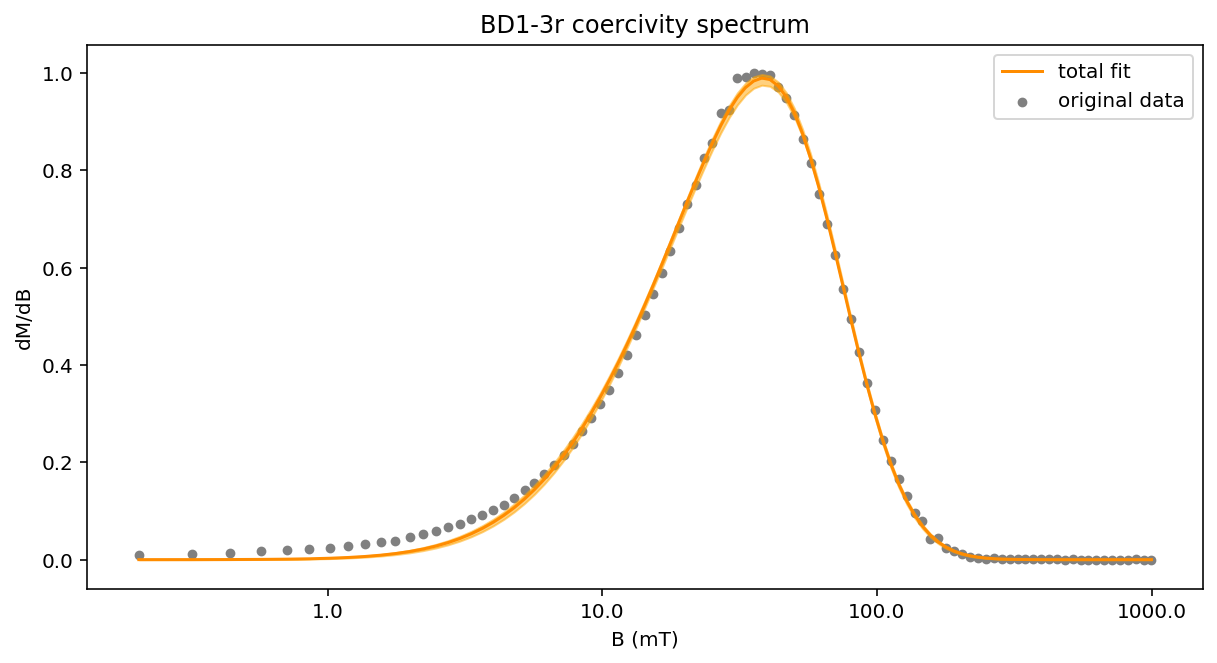

In [58]:
BD1_3_fit_error = plot_error_estimate(BD1_3_logBlist, BD1_3_dMdBlist, specimen_name, BD1_3_in_list, savefig = False)

### BD2-2r

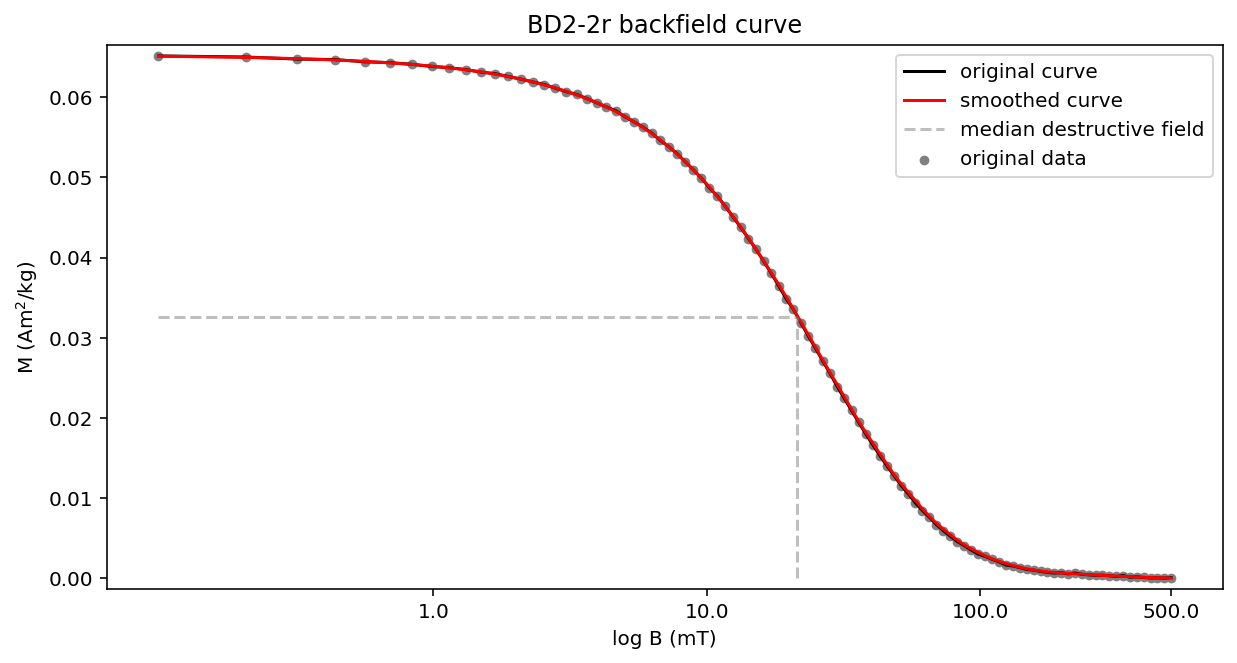

In [59]:
BD2_2_MDF = plot_VSM_bf_data(VSM_bf_measurements, 22, 0.1)

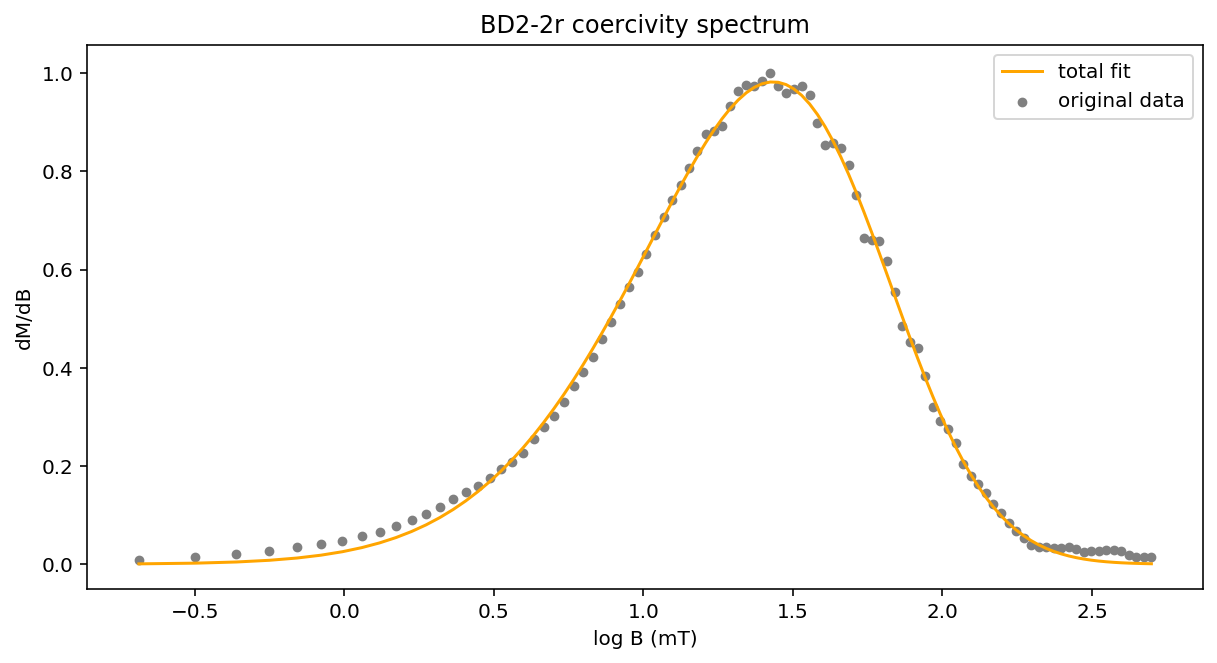

In [60]:
BD2_2_logBlist = get_VSM_bf_data(VSM_bf_measurements, 22, 0.1, 0.1)['Log_Blist'][2:]
BD2_2_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 22, 0.1, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 22, 0.1, 0.1)['Name']

BD2_2_in_list = [-1, 1.5, .2, 1.]
BD2_2_fit_result = plot_unmix_data(BD2_2_logBlist, BD2_2_dMdBlist, specimen_name, BD2_2_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


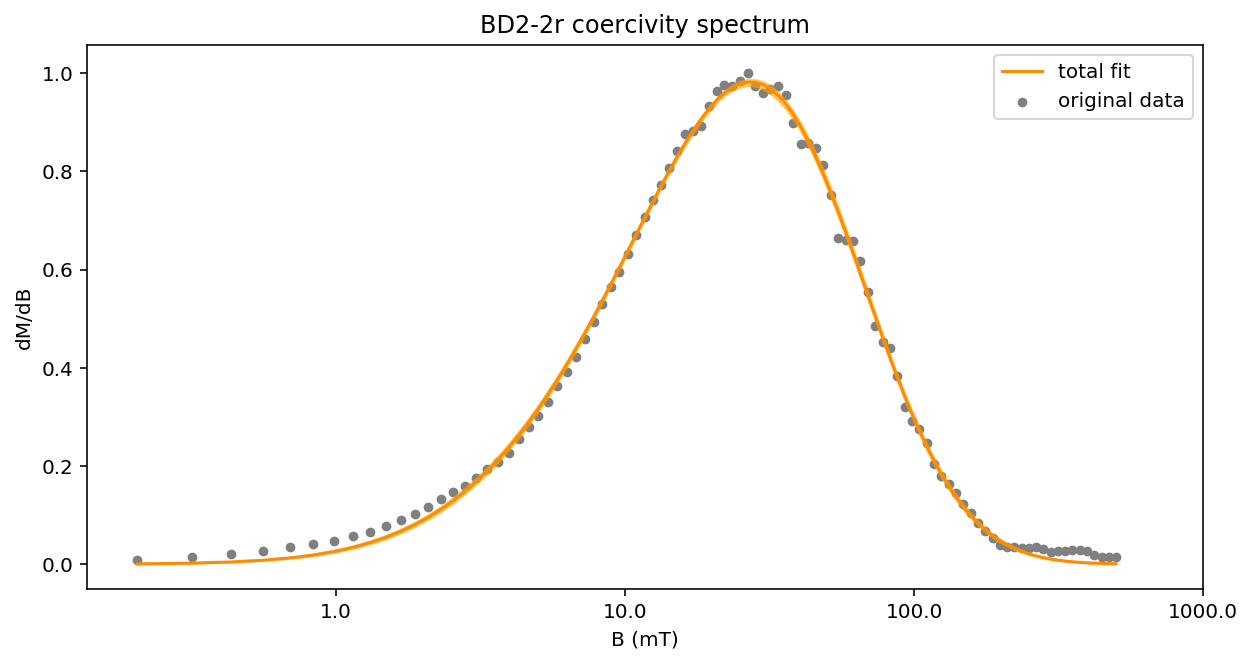

In [61]:
BD2_2_fit_error = plot_error_estimate(BD2_2_logBlist, BD2_2_dMdBlist, specimen_name, BD2_2_in_list, savefig = False)

### BD5-2r

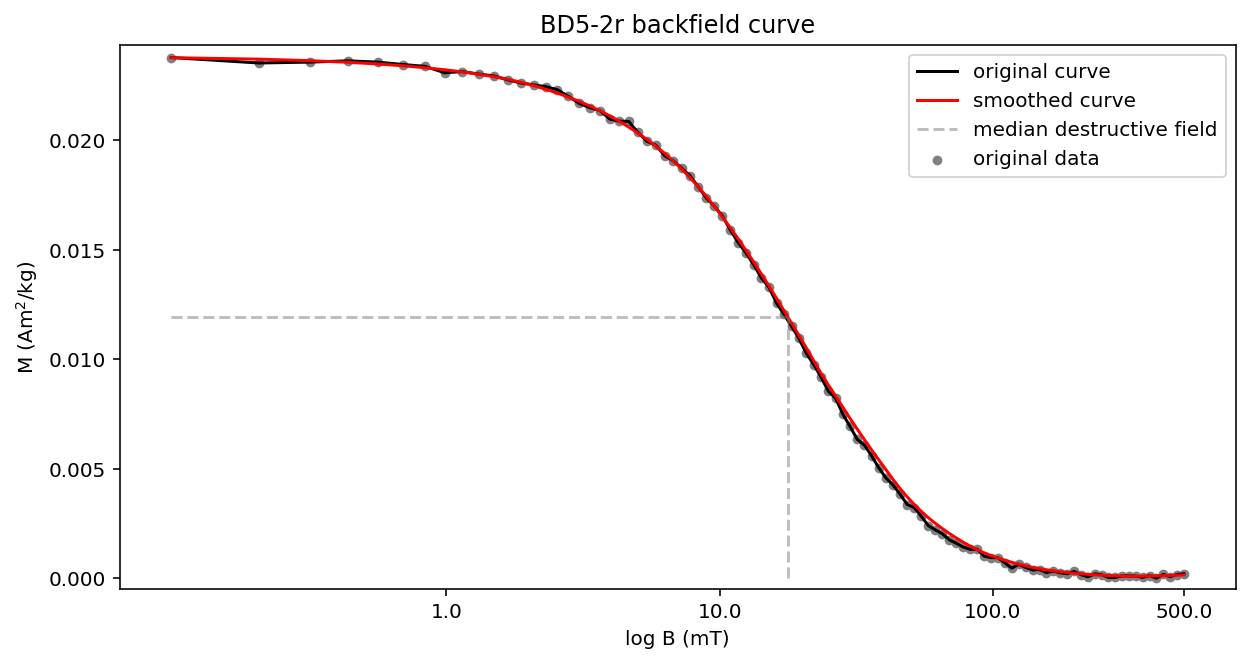

In [62]:
BD5_2_MDF = plot_VSM_bf_data(VSM_bf_measurements, 25, 0.2)

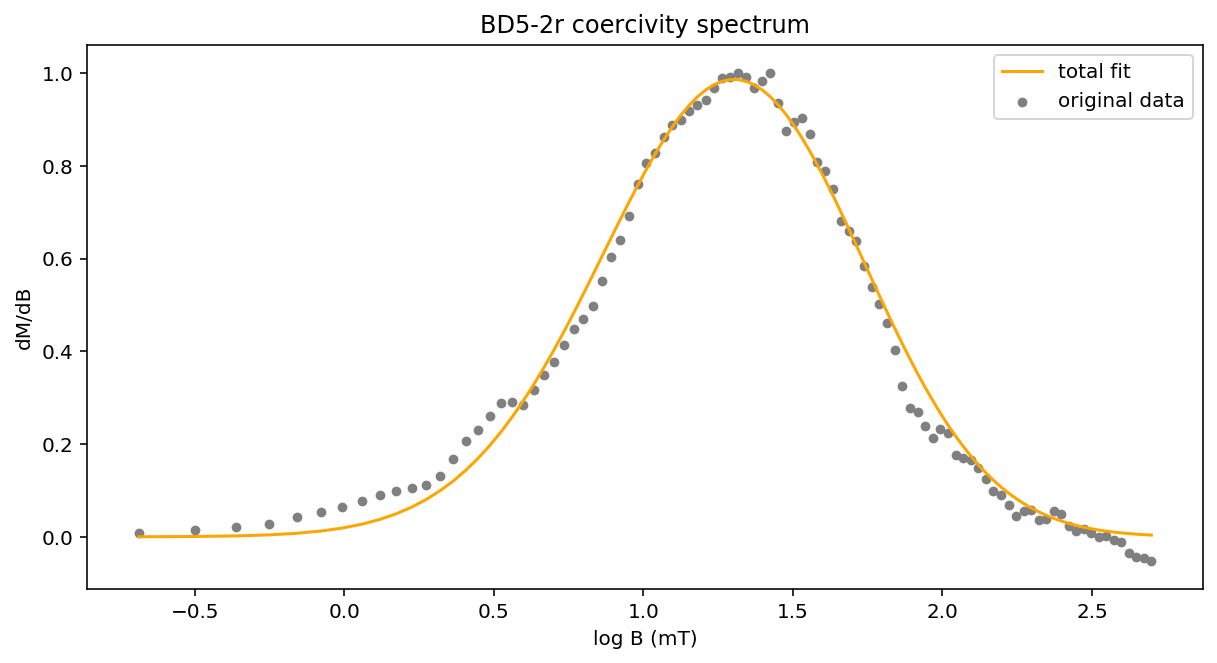

In [63]:
BD5_2_logBlist = get_VSM_bf_data(VSM_bf_measurements, 25, 0.1, 0.1)['Log_Blist'][2:]
BD5_2_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 25, 0.1, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 25, 0.1, 0.1)['Name']

BD5_2_in_list = [-1, 2., .2, 1.]
BD5_2_fit_result = plot_unmix_data(BD5_2_logBlist, BD5_2_dMdBlist, specimen_name, BD5_2_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


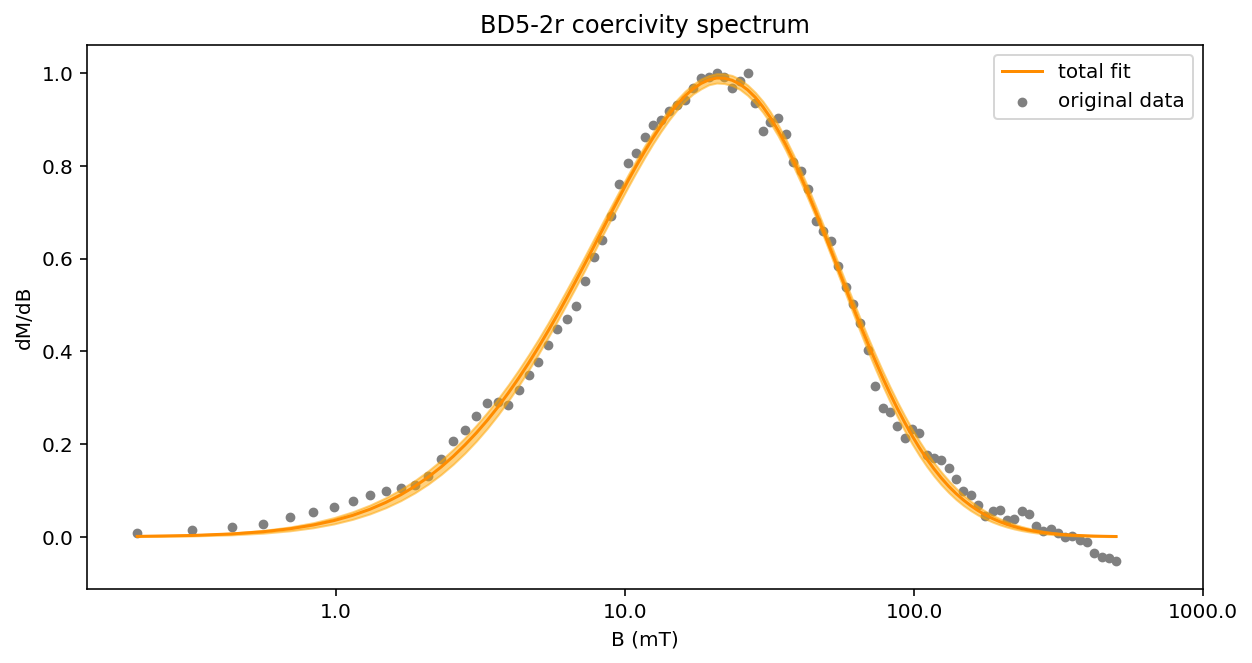

In [64]:
BD5_2_fit_error = plot_error_estimate(BD5_2_logBlist, BD5_2_dMdBlist, specimen_name, BD5_2_in_list, savefig = False)

### BD6-4r

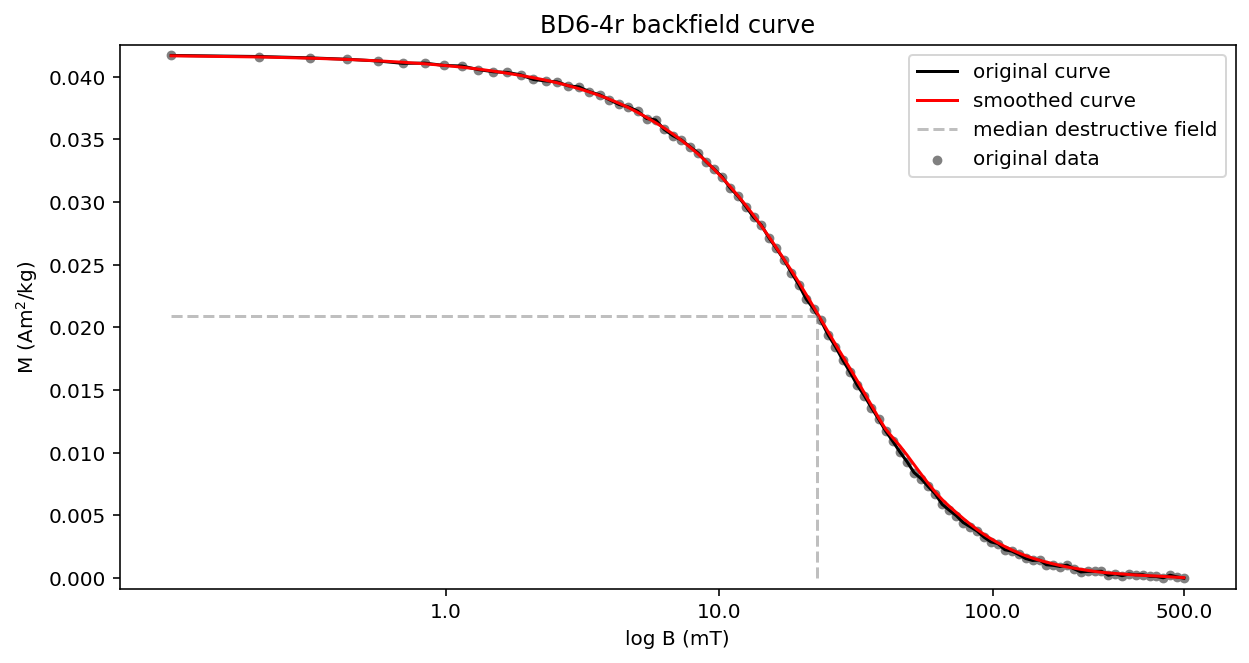

In [65]:
BD6_4_MDF = plot_VSM_bf_data(VSM_bf_measurements, 26, 0.15)

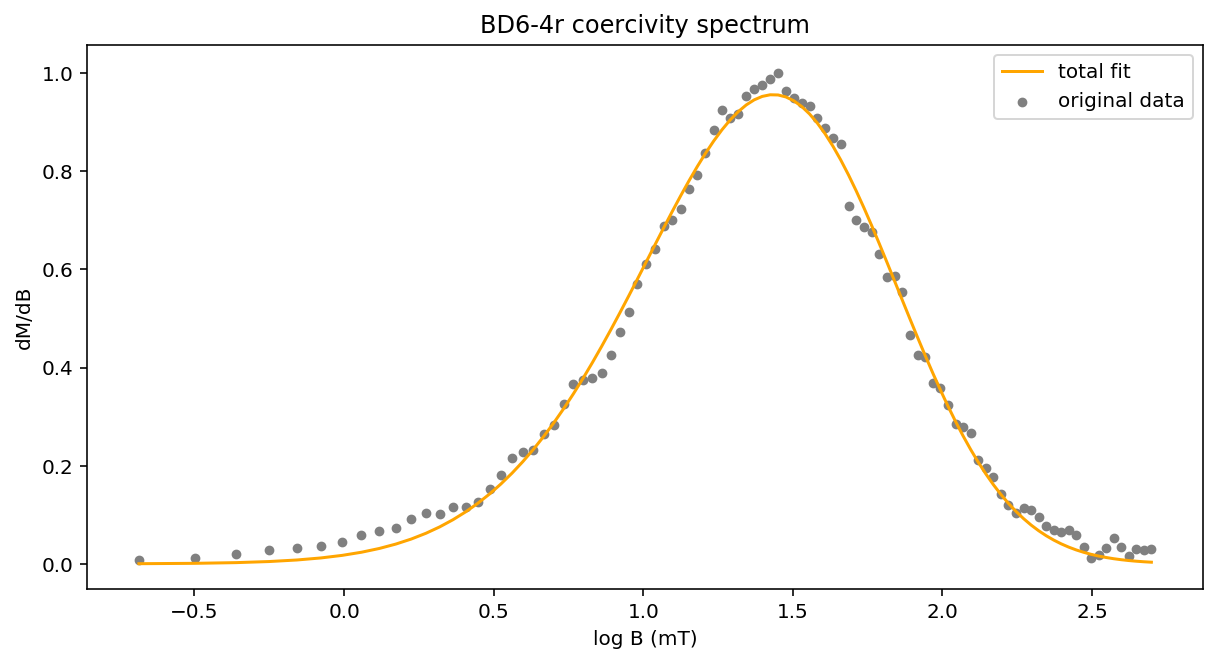

In [66]:
BD6_4_logBlist = get_VSM_bf_data(VSM_bf_measurements, 26, 0.08, 0.1)['Log_Blist'][2:]
BD6_4_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 26, 0.08, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 26, 0.08, 0.1)['Name']

BD6_4_in_list = [1, 2., .2, 1.]
BD6_4_fit_result = plot_unmix_data(BD6_4_logBlist, BD6_4_dMdBlist, specimen_name, BD6_4_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


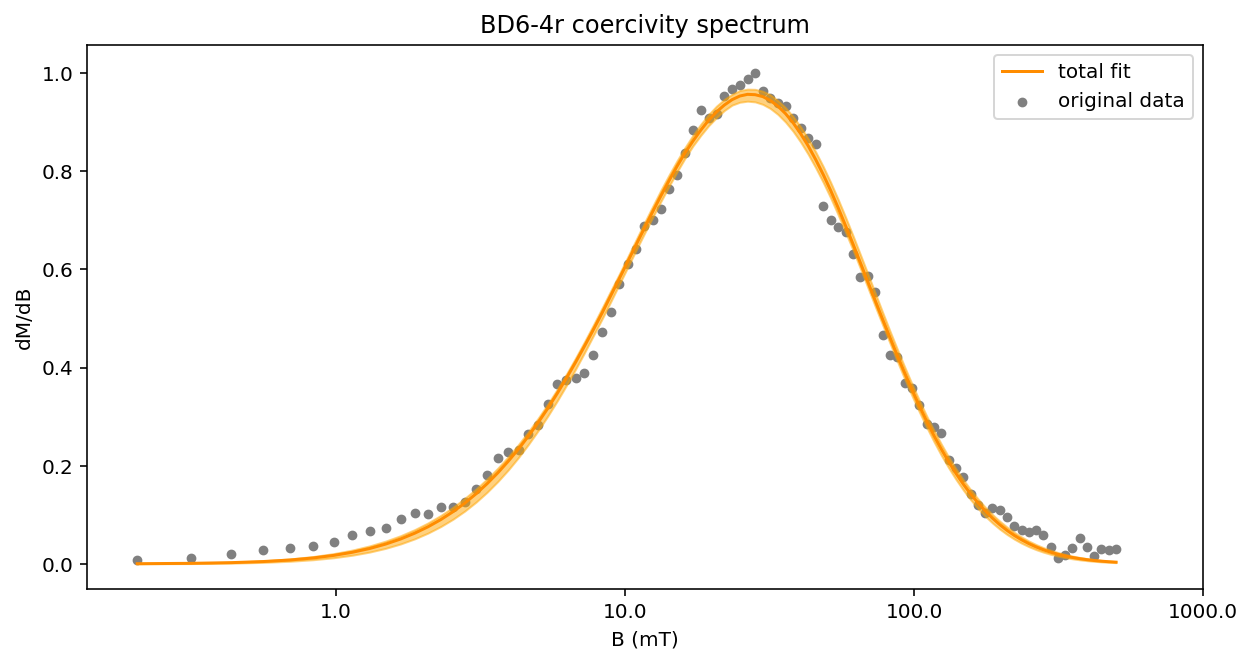

In [67]:
BD6_4_fit_error = plot_error_estimate(BD6_4_logBlist, BD6_4_dMdBlist, specimen_name, BD6_4_in_list, savefig = False)

### BD7-7r

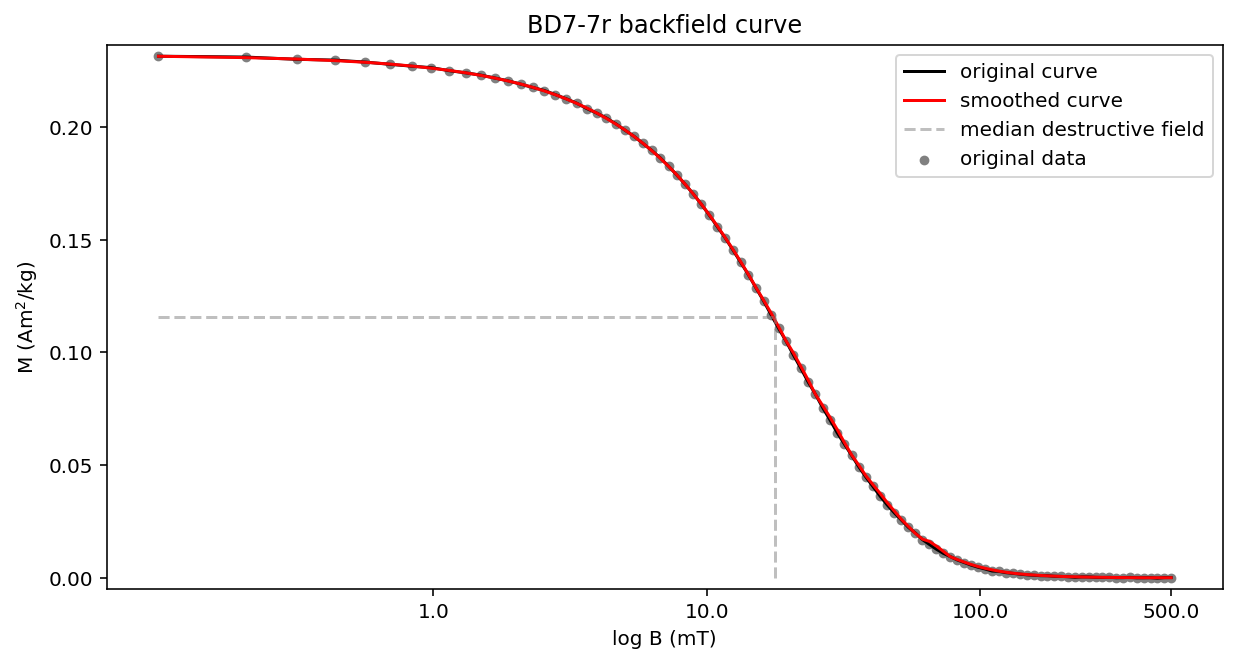

In [68]:
BD7_7_MDF = plot_VSM_bf_data(VSM_bf_measurements, 27, 0.1)

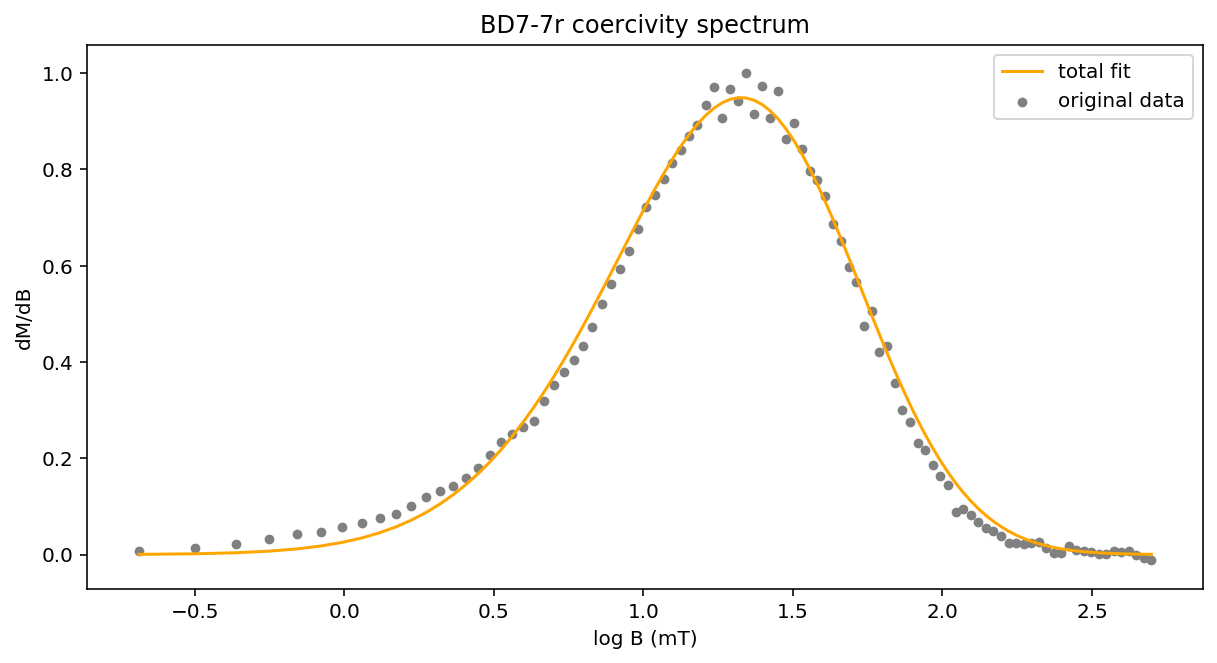

In [69]:
BD7_7_logBlist = get_VSM_bf_data(VSM_bf_measurements, 27, 0.05, 0.1)['Log_Blist'][2:]
BD7_7_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 27, 0.05, 0.1)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 27, 0.05, 0.1)['Name']

BD7_7_in_list = [1, 1.4, 1., 1.]
BD7_7_fit_result = plot_unmix_data(BD7_7_logBlist, BD7_7_dMdBlist, specimen_name, BD7_7_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


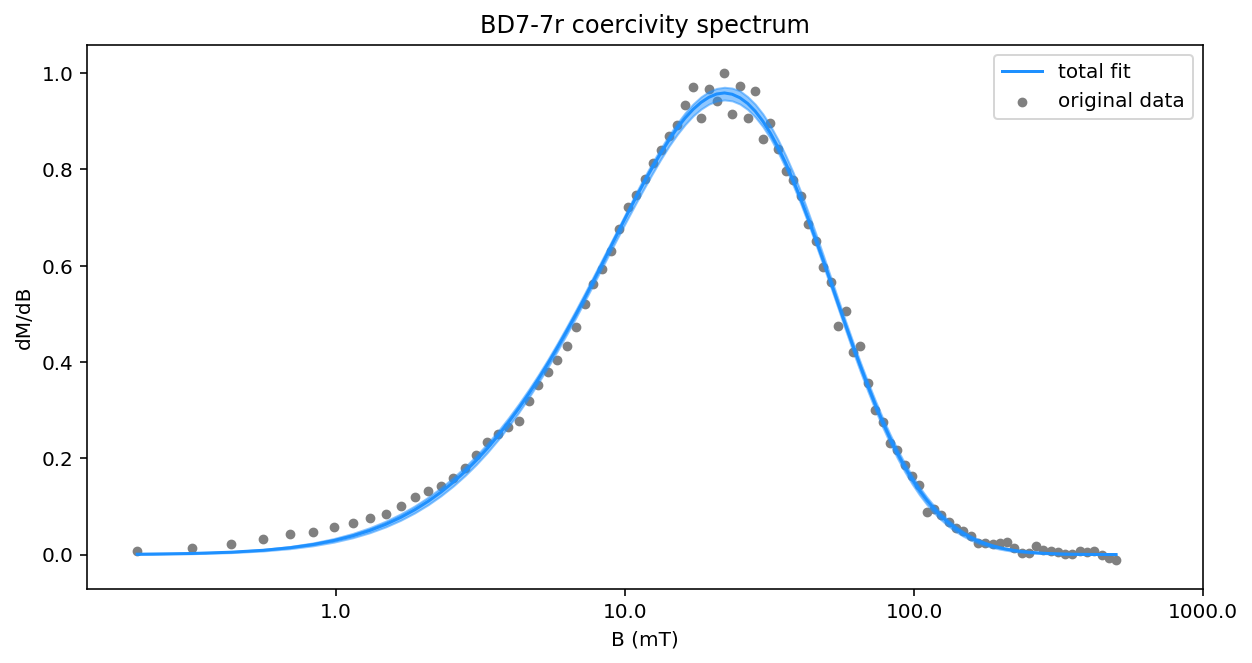

In [70]:
BD7_7_fit_error = plot_error_estimate(BD7_7_logBlist, BD7_7_dMdBlist, specimen_name, BD7_7_in_list, 
                                      init_color_code_components=['dodgerblue'], init_color_code_error=['dodgerblue'], savefig = False)

## use a single plag crystal from AX3-1 to explore potential single crystal anisotropy issue

### AX3-1-sc-000

- This is another single crystal experiment on the Lake Shore VSM. This specimen is from one of the weakest sites we have, AX3, which has the weakest 2G measurement from thermal demag. However, the petrographic work has shown that it has not been altered, there are not even too many fine cracks within the sample. 
- It is interesting that this specimen is relatively weak even for the Lake Shore to measure. The data is pretty noisy. ALso given that this one is about 0.5 gram, nearly 3 times the mass of the previous specimen, AX3-1-SC
- We have previous noisy VSM data, and new (old VSM) data with longer averaging time, which yielded better results. 

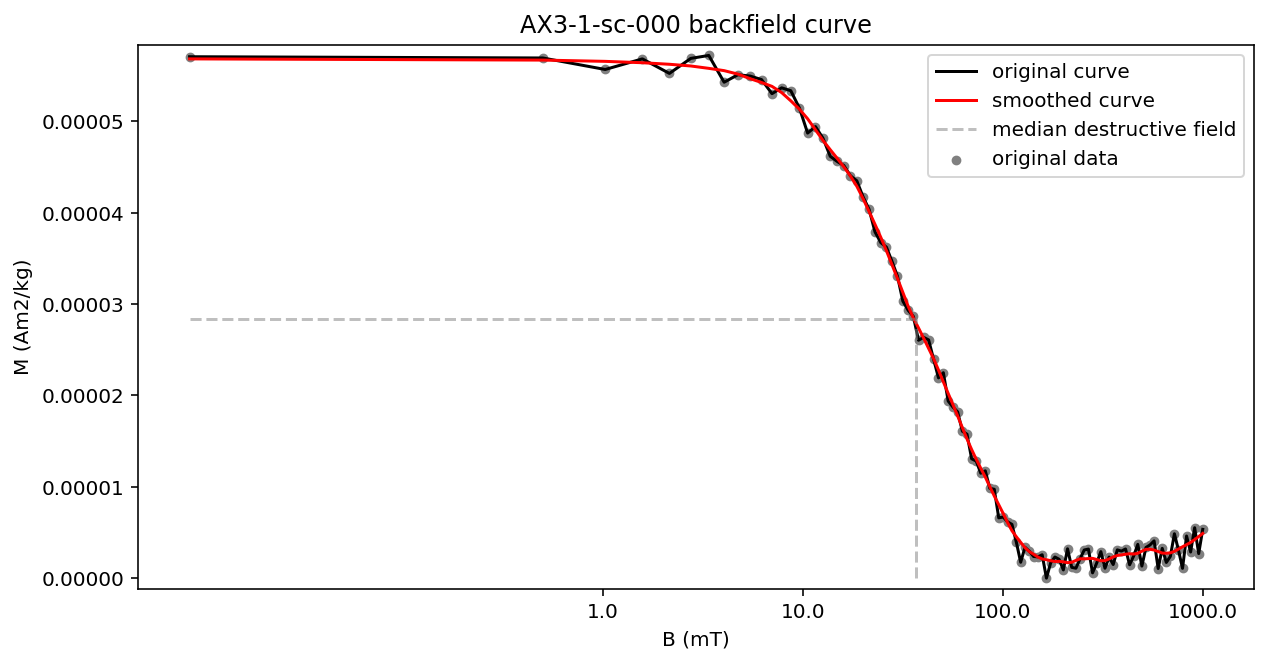

In [71]:
AX3_1_sc_000_MDF = plot_Lake_Shore_VSM_bf_data('../Data/Rock_mag/AX3-1-sc_000_hyst_custom_backfield.csv', 'AX3-1-sc-000', 0.2, log = True, mass = 0.0796)

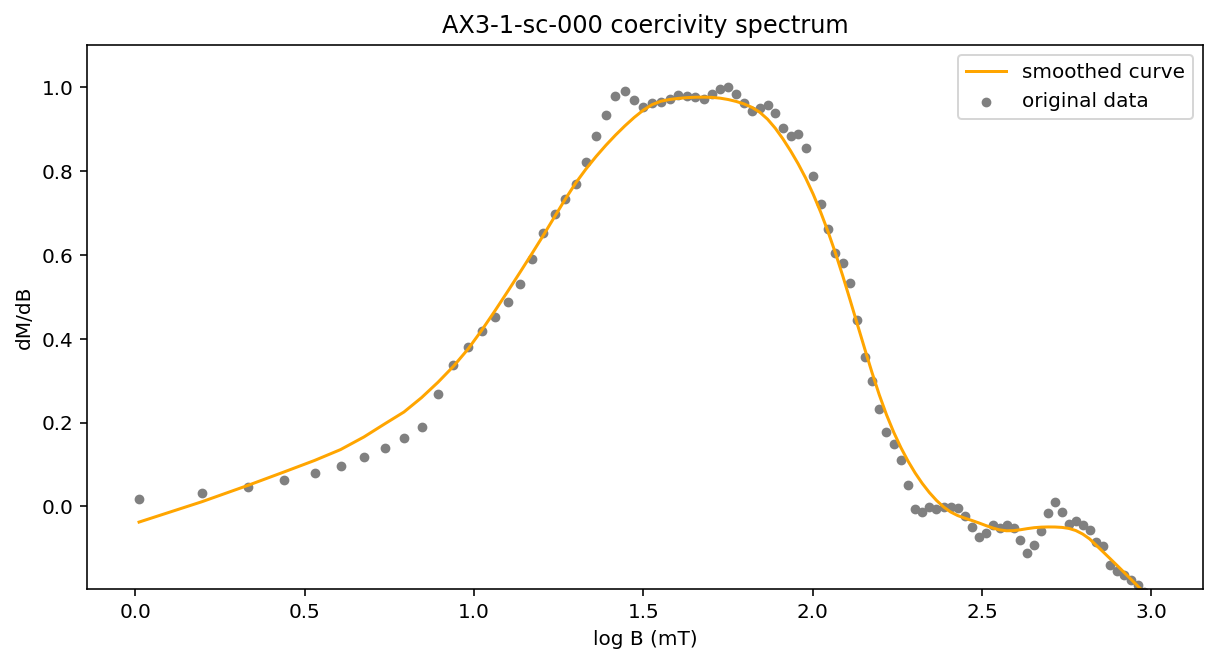

In [72]:
AX3_1_sc_000_bf = plot_Lake_Shore_VSM_bf_der_data('../Data/Rock_mag/AX3-1-sc_000_hyst_custom_backfield.csv', 'AX3-1-sc-000', 0.2, 0.2, mass = 0.0796)

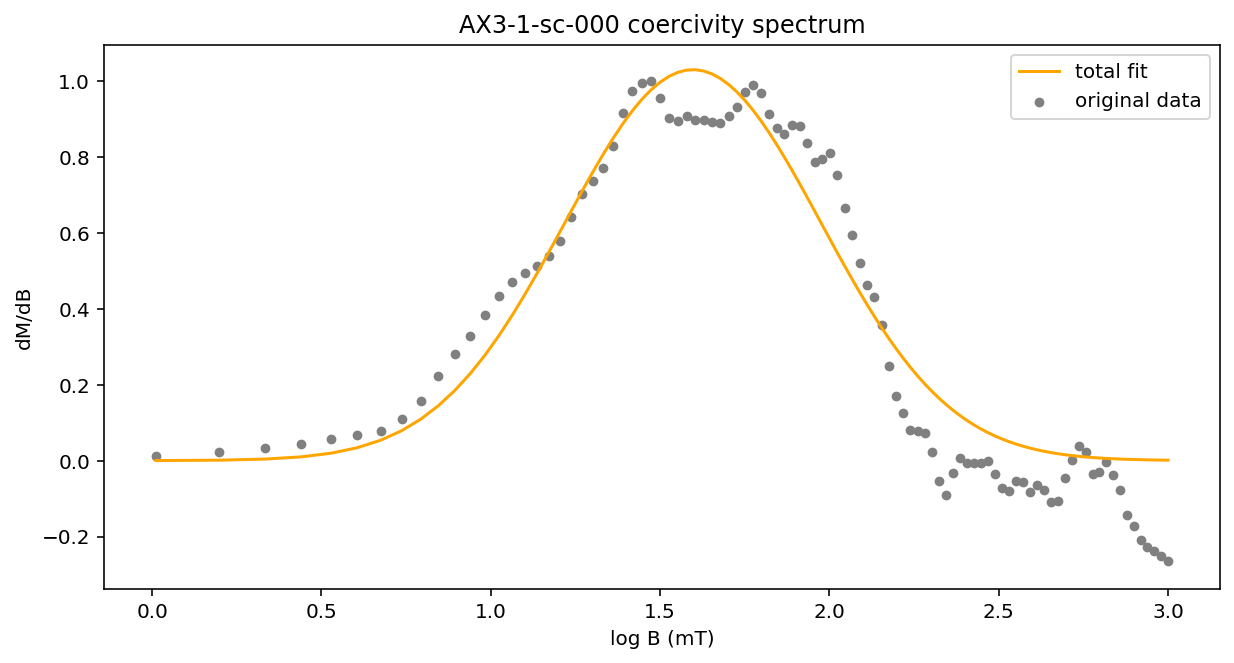

In [73]:
AX3_1_sc_000_logBlist = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_000_hyst_custom_backfield.csv', 'AX3-1-sc-000', 0.15, 0.15, mass = 0.0796)['Log_Blist'][2:]
AX3_1_sc_000_dMdBlist = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_000_hyst_custom_backfield.csv', 'AX3-1-sc-000', 0.15, 0.15, mass = 0.0796)['Derivative']
specimen_name = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_000_hyst_custom_backfield.csv', 'AX3-1-sc-000', 0.2, 0.2, mass = 0.0796)['Name']
AX3_1_in_list = [1, 2., .2, 1.]
AX3_1_sc_000_result = plot_unmix_data(AX3_1_sc_000_logBlist, AX3_1_sc_000_dMdBlist, specimen_name, AX3_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


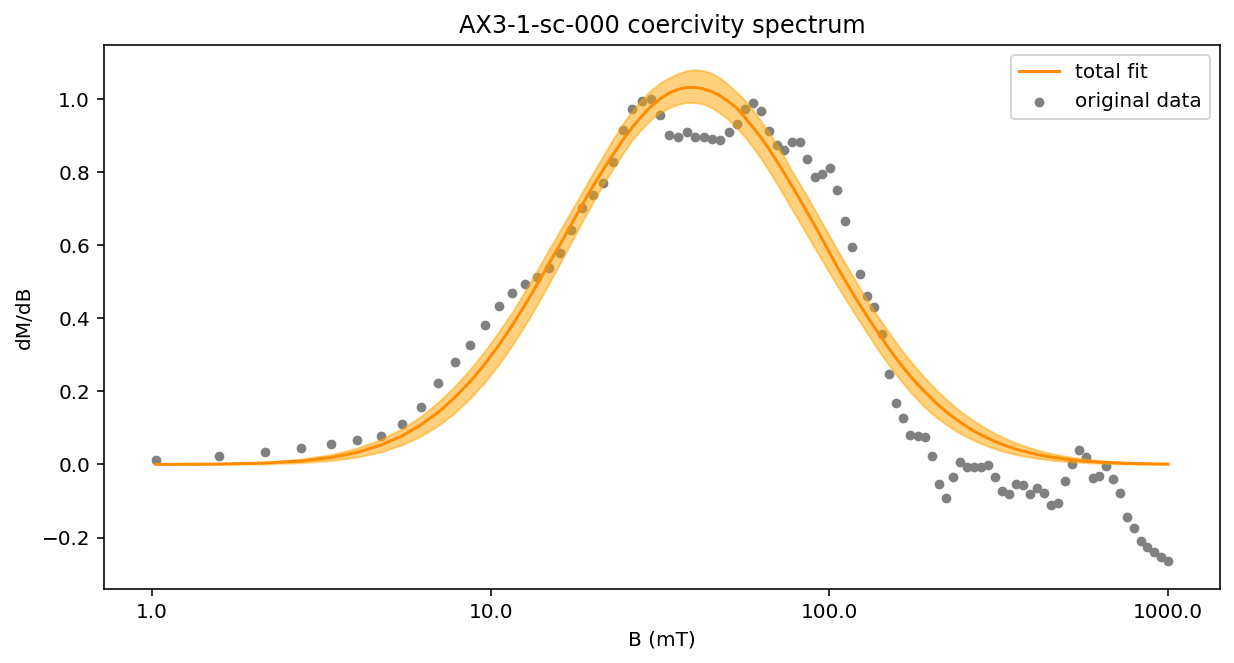

In [74]:
AX3_1_sc_000_fit_error = plot_error_estimate(AX3_1_sc_000_logBlist, AX3_1_sc_000_dMdBlist, specimen_name, AX3_1_in_list, savefig = False)

### AX3-1-sc-120

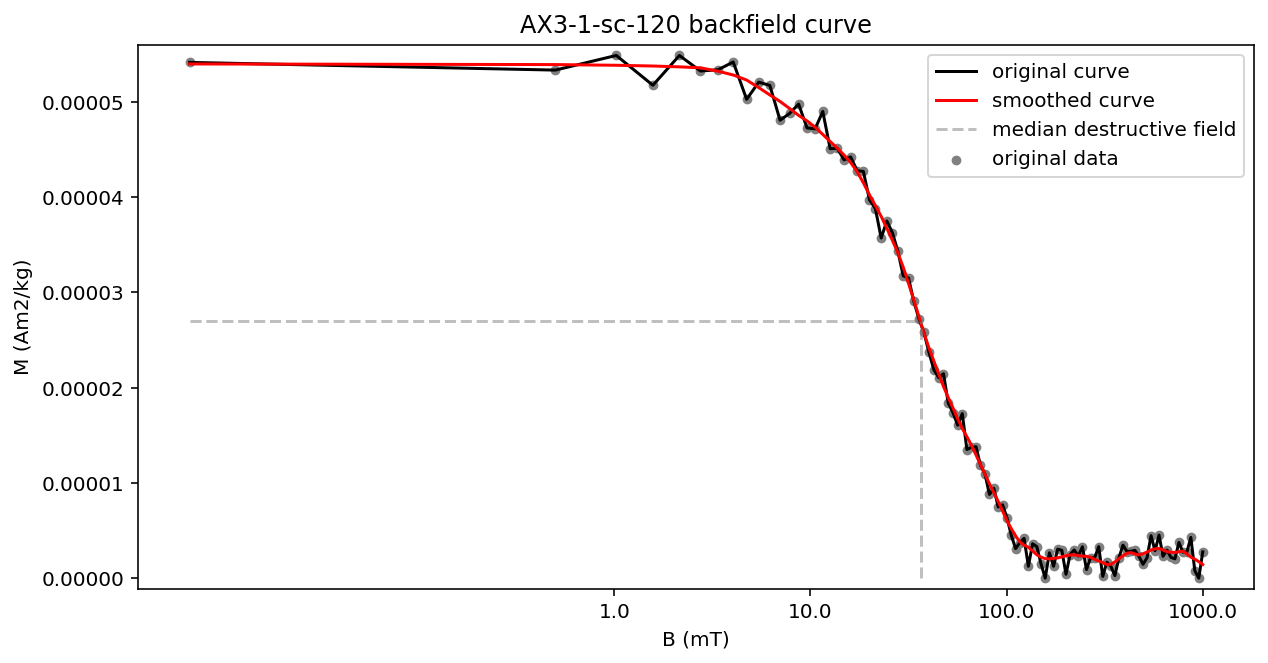

In [75]:
AX3_1_sc_120_MDF = plot_Lake_Shore_VSM_bf_data('../Data/Rock_mag/AX3-1-sc_120_hyst_custom_backfield.csv', 'AX3-1-sc-120', 0.25, log = True, mass = 0.0796)

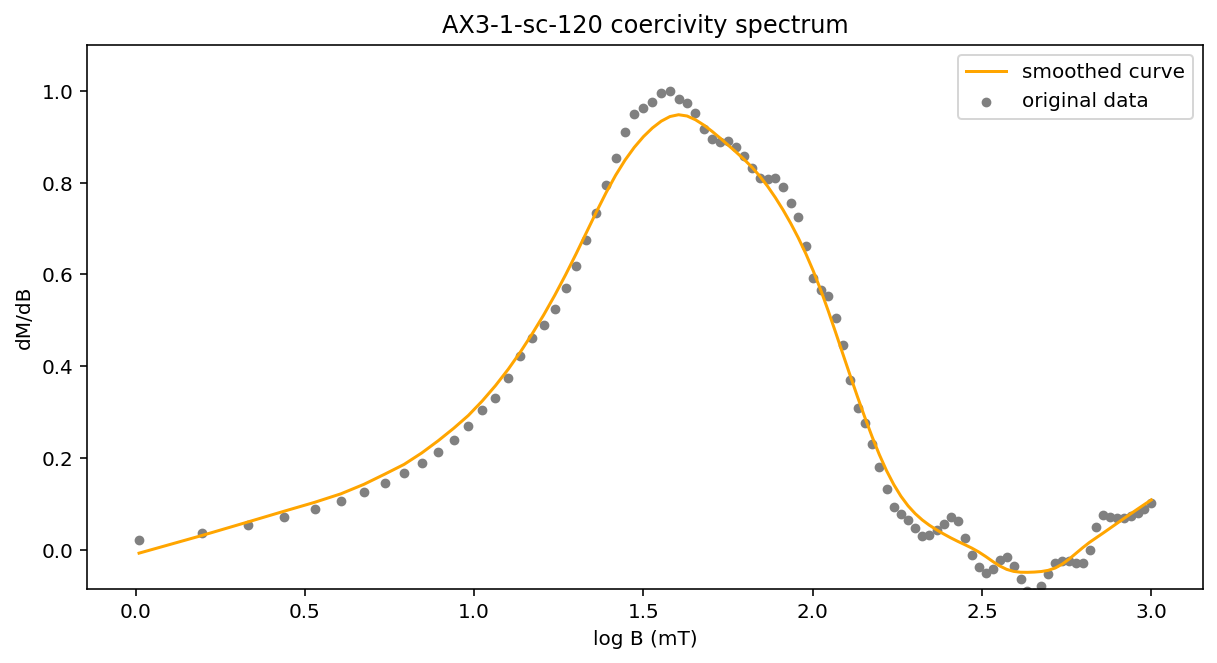

In [76]:
AX3_1_sc_120_bf = plot_Lake_Shore_VSM_bf_der_data('../Data/Rock_mag/AX3-1-sc_120_hyst_custom_backfield.csv', 'AX3-1-sc-120', 0.25, 0.2, mass = 0.0796)

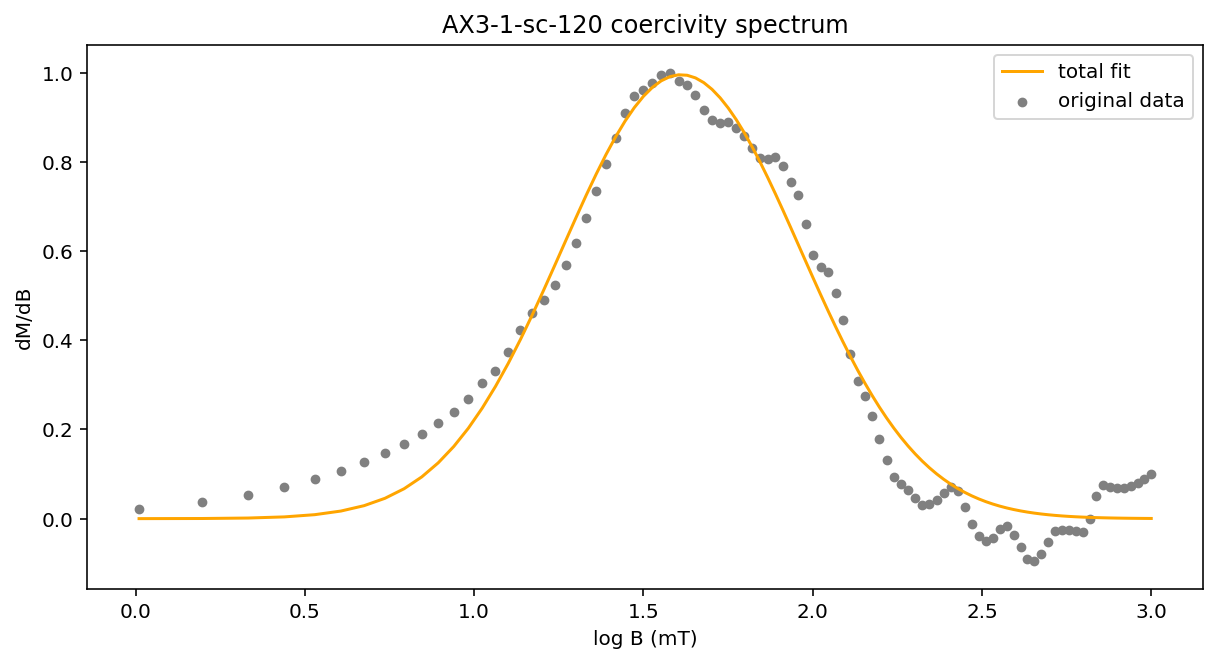

In [77]:
AX3_1_sc_120_logBlist = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_120_hyst_custom_backfield.csv', 'AX3-1-sc-120', 0.25, 0.1, mass = 0.0796)['Log_Blist'][2:]
AX3_1_sc_120_dMdBlist = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_120_hyst_custom_backfield.csv', 'AX3-1-sc-120', 0.25, 0.1, mass = 0.0796)['Derivative']
specimen_name = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_120_hyst_custom_backfield.csv', 'AX3-1-sc-120', 0.25, 0.1, mass = 0.0796)['Name']
AX3_1_sc_120_result = plot_unmix_data(AX3_1_sc_120_logBlist, AX3_1_sc_120_dMdBlist, specimen_name, AX3_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


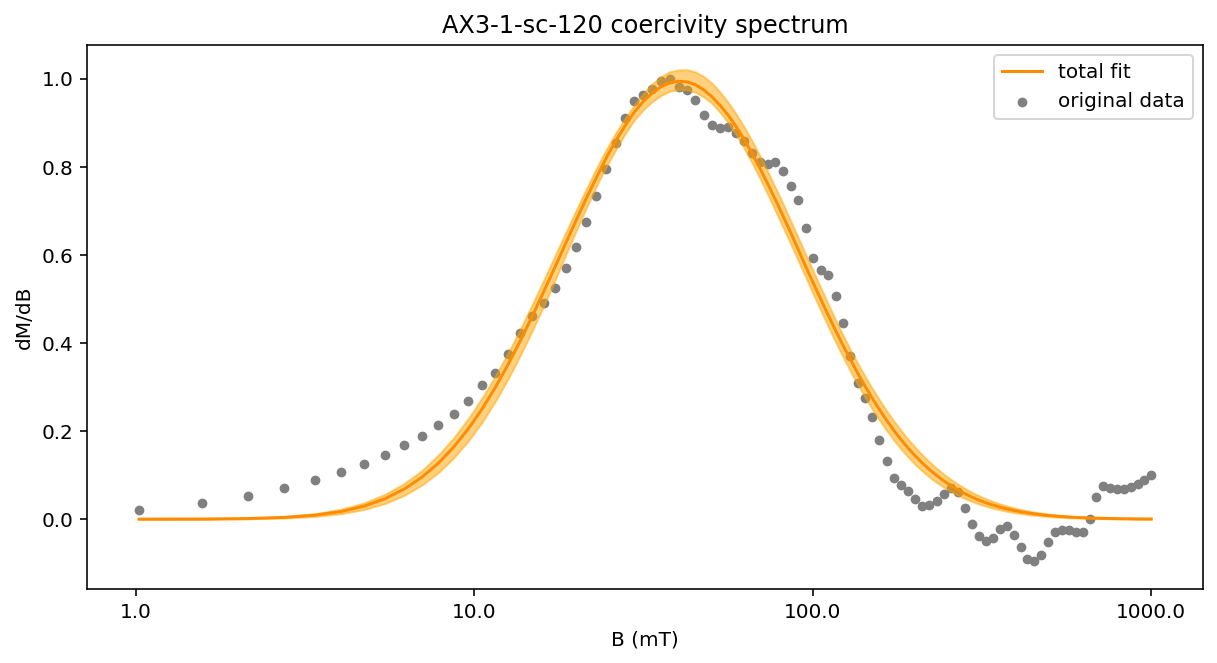

In [78]:
AX3_1_sc_120_fit_error = plot_error_estimate(AX3_1_sc_120_logBlist, AX3_1_sc_120_dMdBlist, specimen_name, AX3_1_in_list, savefig = False)

### AX3-1-sc-240

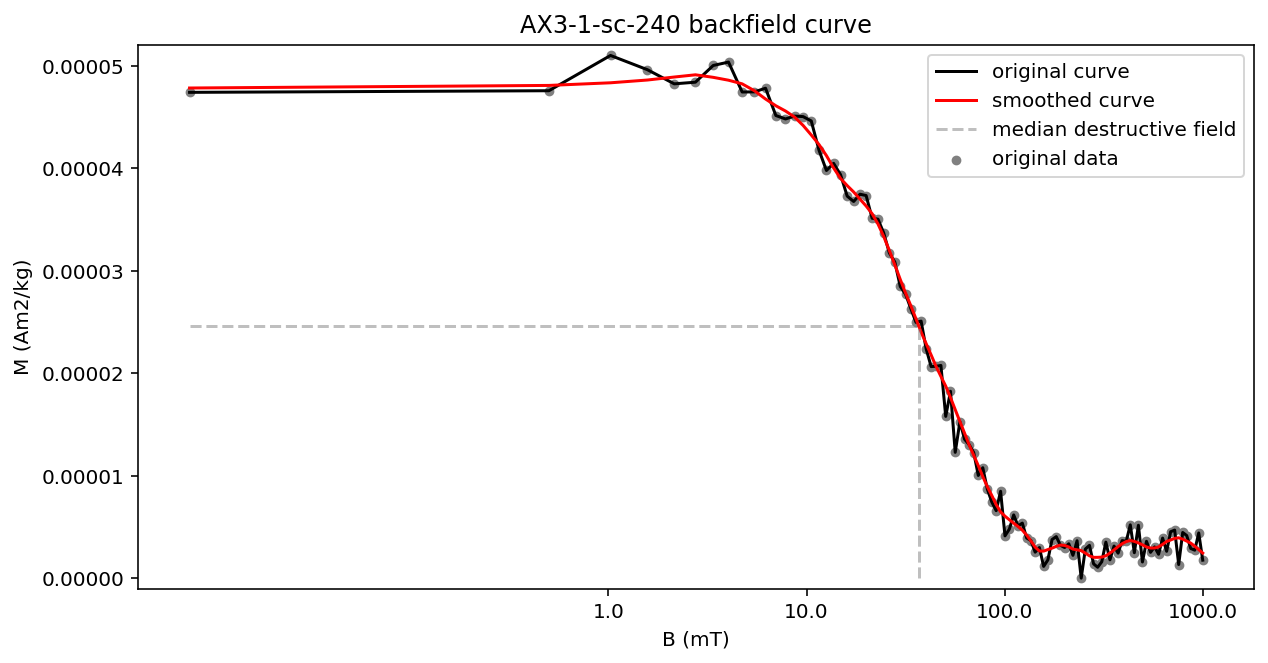

In [79]:
AX3_1_sc_240_MDF = plot_Lake_Shore_VSM_bf_data('../Data/Rock_mag/AX3-1-sc_240_hyst_custom_backfield.csv', 'AX3-1-sc-240', 0.2, log = True, mass = 0.0796)

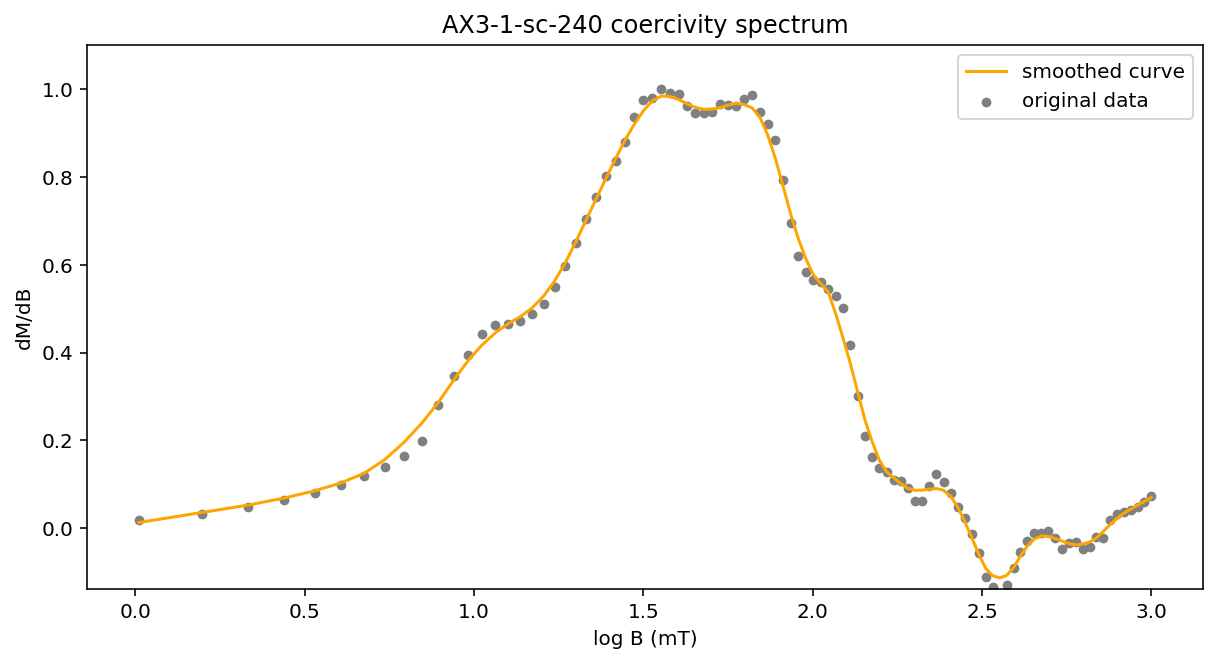

In [80]:
AX3_1_sc_240_bf = plot_Lake_Shore_VSM_bf_der_data('../Data/Rock_mag/AX3-1-sc_240_hyst_custom_backfield.csv', 'AX3-1-sc-240', 0.2, 0.1, mass = 0.0796)

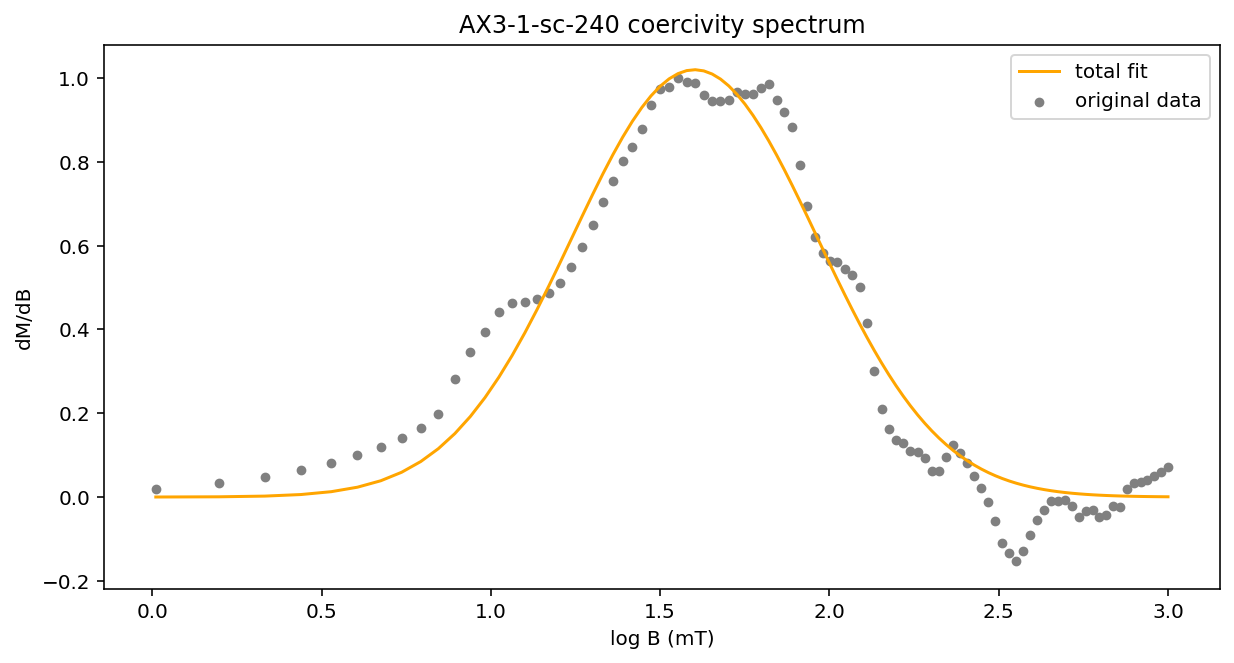

In [81]:
AX3_1_sc_240_logBlist = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_240_hyst_custom_backfield.csv', 'AX3-1-sc-240', 0.2, 0.1, mass = 0.0796)['Log_Blist'][2:]
AX3_1_sc_240_dMdBlist = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_240_hyst_custom_backfield.csv', 'AX3-1-sc-240', 0.2, 0.1, mass = 0.0796)['Derivative']
specimen_name = get_Lake_Shore_data('../Data/Rock_mag/AX3-1-sc_240_hyst_custom_backfield.csv', 'AX3-1-sc-240', 0.2, 0.1, mass = 0.0796)['Name']
AX3_1_sc_240_result = plot_unmix_data(AX3_1_sc_240_logBlist, AX3_1_sc_240_dMdBlist, specimen_name, AX3_1_in_list)

resampling finished
parameter uncertainty calculation finished
fitting uncertainty envelope estimate finished


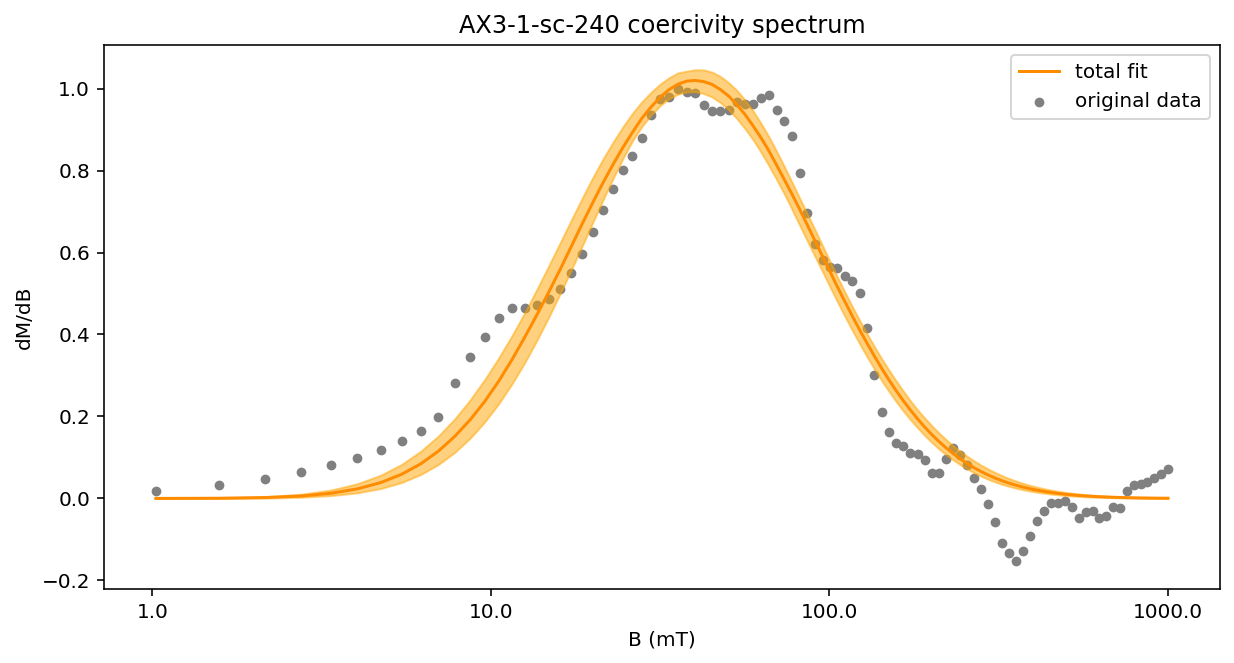

In [82]:
AX3_1_sc_240_fit_error = plot_error_estimate(AX3_1_sc_240_logBlist, AX3_1_sc_240_dMdBlist, specimen_name, AX3_1_in_list, savefig = False)

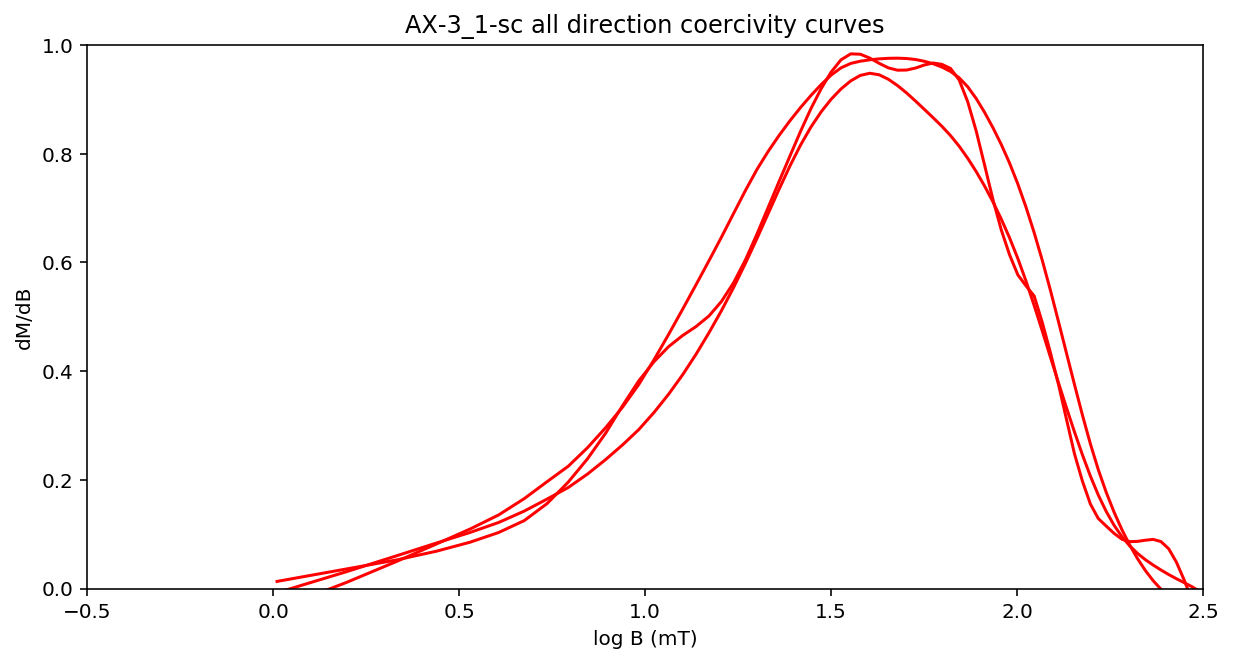

In [83]:
AX3_1_sc_all_bf = list()
# AX3_1_sc_all_bf.append(AX3_1_bulk_bf_der)
AX3_1_sc_all_bf.append(AX3_1_sc_000_bf)
AX3_1_sc_all_bf.append(AX3_1_sc_120_bf)
AX3_1_sc_all_bf.append(AX3_1_sc_240_bf)

plt.figure(figsize=(10,5))
i = 0
while i < len(AX3_1_sc_all_bf):
    plt.plot(AX3_1_sc_all_bf[i][:,0], AX3_1_sc_all_bf[i][:,1], color = 'red')
    i = i + 1

# plt.ylim(float(min(Der[1:])*0.9),float(max(Der[1:])*1.1))
# plt.yscale('log')
plt.ylim(0,1)
plt.xlim(-0.5, 2.5)
plt.xlabel('log B (mT)')
plt.ylabel('dM/dB')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
plt.title('AX-3_1-sc all direction coercivity curves')
# plt.savefig('All_coercivity_curves.pdf')
# plt.legend()
plt.show()

## Comparing coercivity unmix peak field between accepted AX PINT sites and rejected ones, and comparing to BD results

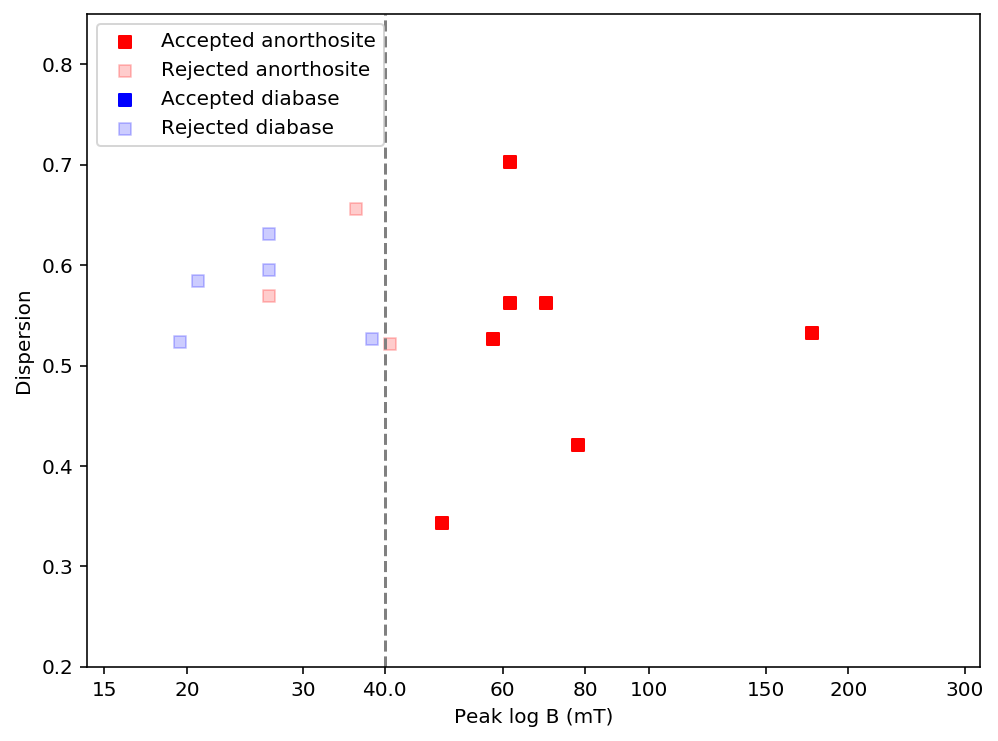

In [84]:
AX_accepted_list = [AX6_1_fit_result, AX8_1_fit_result, AX10_3_fit_result, AX11_2_fit_result, 
                    AX12_6_fit_result, AX13_1_fit_result, AX16_1_lakeshore_result]
AX_rejected_list = [AX1_1_fit_result, AX5_1_fit_result, AX7_1_fit_result]

BD_accepted_list = []
BD_rejected_list = [BD1_3_fit_result, BD2_2_fit_result, BD5_2_fit_result, BD6_4_fit_result, BD7_7_fit_result]

# sc_unmix_list = [AX3_1_sc_000_result, AX3_1_sc_120_result, AX3_1_sc_240_result]

Poor_data_list = [AX16_1_fit_result, AX9_2_fit_result, AX15_2_fit_result]

# Poor_data_list=[]

AX_accepted_peak_field_list = list()
AX_accepted_Dispersion_list = list()
AX_rejected_peak_field_list = list()
AX_rejected_Dispersion_list = list()

BD_accepted_peak_field_list = list()
BD_accepted_Dispersion_list = list()
BD_rejected_peak_field_list = list()
BD_rejected_Dispersion_list = list()

# sc_peak_field_list = list()
# sc_Dispersion_list = list()
poor_data_peak_field_list = list()
poor_data_Dispersion_list = list()

for i in range(len(AX_accepted_list)):
    AX_accepted_peak_field_list.append(AX_accepted_list[i][0])
    AX_accepted_Dispersion_list.append(AX_accepted_list[i][1])

for i in range(len(AX_rejected_list)):
    AX_rejected_peak_field_list.append(AX_rejected_list[i][0])
    AX_rejected_Dispersion_list.append(AX_rejected_list[i][1])

for i in range(len(BD_accepted_list)):
    BD_accepted_peak_field_list.append(BD_accepted_list[i][0])
    BD_accepted_Dispersion_list.append(BD_accepted_list[i][1])

for i in range(len(BD_rejected_list)):
    BD_rejected_peak_field_list.append(BD_rejected_list[i][0])
    BD_rejected_Dispersion_list.append(BD_rejected_list[i][1])

# for i in range(len(sc_unmix_list)):
#     sc_peak_field_list.append(sc_unmix_list[i][0])
#     sc_Dispersion_list.append(sc_unmix_list[i][1])
    
for i in range(len(Poor_data_list)):
    poor_data_peak_field_list.append(Poor_data_list[i][0])
    poor_data_Dispersion_list.append(Poor_data_list[i][1])


plt.figure(figsize=(8,6))
    
plt.scatter(AX_accepted_peak_field_list, AX_accepted_Dispersion_list, color = 'red', marker = 's', label = 'Accepted anorthosite')
plt.scatter(AX_rejected_peak_field_list, AX_rejected_Dispersion_list, color = 'red', marker = 's', alpha = 0.2, label = 'Rejected anorthosite')
plt.scatter(BD_accepted_peak_field_list, BD_accepted_Dispersion_list, color = 'blue', marker = 's', label = 'Accepted diabase')
plt.scatter(BD_rejected_peak_field_list, BD_rejected_Dispersion_list, color = 'blue', marker = 's', alpha = 0.2, label = 'Rejected diabase')


# plt.scatter(sc_peak_field_list, sc_Dispersion_list, color = 'orange', marker = 's', alpha = 0.5, label = 'single crystals')
# plt.scatter(poor_data_peak_field_list, poor_data_Dispersion_list, color = 'grey', marker = 's', alpha = 0.2, label = 'omitted noisy sites')


plt.plot([1.6, 1.6], [0.2, 0.85], '--', color = 'grey')
x_ticks = [15, 20, 30, 10**1.6, 60, 80, 100, 150, 200, 300]
plt.xticks(np.log10(x_ticks), [round(i,0) for i in x_ticks])
plt.xlabel('Peak log B (mT)')
plt.ylabel('Dispersion')
plt.xlim(1.15, 2.5)
plt.ylim(0.2, 0.85)
plt.legend(loc=2)
# plt.savefig('code_output/unmix_comparison.pdf')
plt.show()

## Make example unmix plots

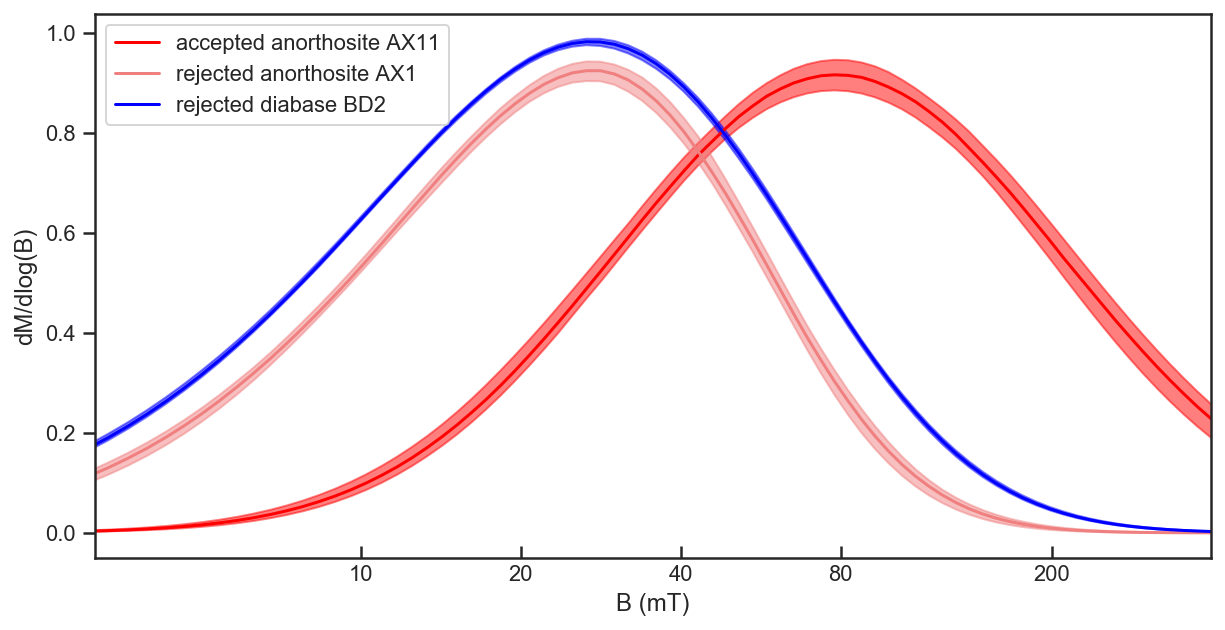

In [89]:
example_unmix_list = [AX11_2_fit_error, AX1_1_fit_error, BD2_2_fit_error]
example_color_code = ['red', 'lightcoral', 'blue']
example_labels = ['accepted anorthosite AX11', 'rejected anorthosite AX1','rejected diabase BD2' ]

# assuming there is only one list component for each element in the list
example_upper_bounds = [i[0]['upper_bounds'][0] for i in example_unmix_list]
example_lower_bounds = [i[0]['lower_bounds'][0]  for i in example_unmix_list]
example_means = [i[0]['means'][0]  for i in example_unmix_list]
example_logBlists = [i[1] for i in example_unmix_list]

plt.figure(figsize = (10,5))
for i in range(len(example_upper_bounds)):
    plt.plot(example_logBlists[i], example_means[i], color=example_color_code[i], label = example_labels[i])
    plt.fill_between(example_logBlists[i], example_upper_bounds[i], example_lower_bounds[i], color=example_color_code[i], alpha='0.5')

plt.xlabel('B (mT)')
plt.ylabel('dM/dlog(B)')
plt.xticks([np.log10(10), np.log10(20), np.log10(40), np.log10(80), np.log10(200), np.log10(400)], 
           [10, 20, 40, 80, 200, 400])
# plt.xticklabels([15, 25, 40, 60, 100, 150, 250, 400])
plt.xlim(0.5, 2.6)
plt.tick_params(axis="x",direction="in")
# plt.title('example coercivity spectrum')
plt.legend()

plt.savefig('code_output/example_unmix_plot.pdf' , bbox_inches='tight')
      
plt.legend()
plt.show()

## MDF compilation

In [86]:
AX_accepted_MDF = [AX6_1_MDF, AX8_1_MDF, AX10_3_MDF, AX11_2_MDF, AX12_6_MDF, AX13_1_MDF, AX16_1_lakeshore_MDF]
AX_rejected_MDF = [AX1_1_MDF, AX5_1_MDF, AX7_1_MDF]

BD_accepted_MDF = []
BD_rejected_MDF = [BD2_2_MDF, BD1_3_MDF, BD5_2_MDF, BD6_4_MDF, BD7_7_MDF]

# sc_MDF = [AX3_1_sc_000_MDF, AX3_1_sc_120_MDF, AX3_1_sc_240_MDF]

# Poor_data_MDF = [AX16_1_MDF, AX9_2_MDF, AX15_2_MDF]

AX_accepted_MDF_list = list()
AX_rejected_MDF_list = list()
BD_accepted_MDF_list = list()
BD_rejected_MDF_list = list()

# sc_MDF_list = list()
# poor_MDF_list = list()

for i in range(len(AX_accepted_MDF)):
    AX_accepted_MDF_list.append(AX_accepted_MDF[i][1])

for i in range(len(AX_rejected_MDF)):
    AX_rejected_MDF_list.append(AX_rejected_MDF[i][1])

for i in range(len(BD_accepted_MDF)):
    BD_accepted_MDF_list.append(BD_accepted_MDF[i][1])

for i in range(len(BD_rejected_MDF)):
    BD_rejected_MDF_list.append(BD_rejected_MDF[i][1])
# for i in range(len(sc_MDF)):
#     sc_MDF_list.append(sc_MDF[i][1])
    
# for i in range(len(Poor_data_MDF)):
#     poor_MDF_list.append(Poor_data_MDF[i][1])  

In [87]:
# try box plots to better show data above
site_col = list()
MDF_col = list()
site_col.extend(['accepted anorthosite' for i in range(len(AX_accepted_MDF_list))])
site_col.extend(['rejected anorthosite' for i in range(len(AX_rejected_MDF_list))])
# site_col.extend(['diabase BD2' for i in range(len(BD_accepted_MDF_list))])
site_col.extend(['diabase' for i in range(len(BD_rejected_MDF_list))])

# site_col.extend(['single crystal' for i in range(len(sc_MDF_list))])
# first_col.extend(['omitted sites' for i in range(len(poor_MDF_field_list))])

MDF_col.extend(AX_accepted_MDF_list)
MDF_col.extend(AX_rejected_MDF_list)
# MDF_col.extend(BD_accepted_MDF_list)
MDF_col.extend(BD_rejected_MDF_list)

# MDF_col.extend(sc_MDF_list)
# second_col.extend(poor_MDF_field_list)

list_of_tuples = list(zip(site_col, MDF_col))

MDF_unmix_df = pd.DataFrame(list_of_tuples, columns = ['site', 'MDF'])

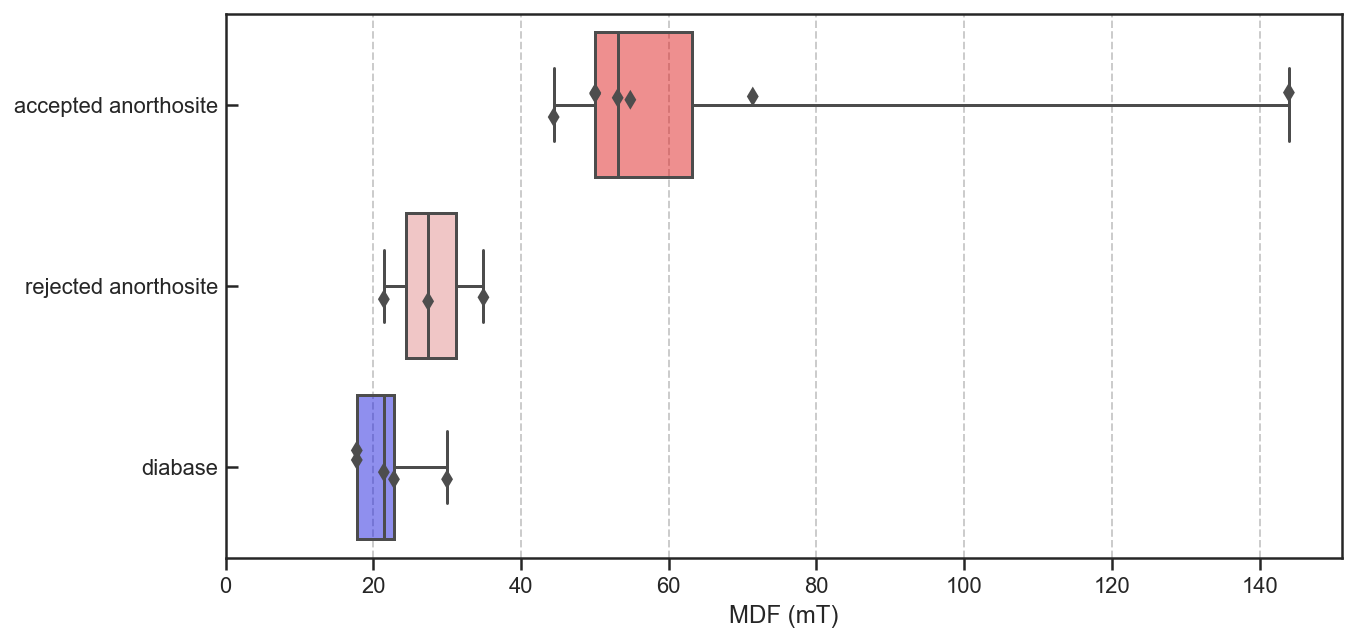

In [90]:
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='MDF', y='site', data = MDF_unmix_df,  whis=[0, 100],
             palette=['red', 'lightcoral', 'blue'], showfliers = False)

sns.stripplot(x="MDF", y="site", data=MDF_unmix_df,
              size=7, marker = 'd', color=".3", linewidth=0)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
ax.xaxis.grid(True, linestyle='--')
ax.set(ylabel="")
ax.set_xlabel('MDF (mT)')
ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax.tick_params(axis="y",direction="in")

# sns.despine(trim=True, left=True)
plt.savefig('code_output/MDF_boxplot_interquartile.pdf', bbox_inches='tight')
plt.show()